#

# Import all the libraries that we will need 

In [1]:
import copy
import csv
import dabest
import datetime
import fnmatch
import glob
from IPython.display import Image, display
import itertools
from itertools import groupby
import math
import matplotlib.cbook
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy.polynomial.polynomial import polyfit
import os
import pandas as pd
import pickle
import platform
from pylab import rcParams
import re
import scipy
from scipy import stats
from scipy.ndimage import gaussian_filter as smooth
from scipy.signal import find_peaks
import statistics
import sys
import warnings
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
startTimeNotebook = datetime.datetime.now()

# Define data path. Load other notebooks if necessary.

In [2]:
###Set the notebook screen ratio for jupyter
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:85% !important; }</style>"))

notebookPath=os.path.dirname(os.path.realpath("__file__"))
#pathToProcessingNotebooks=os.path.join(os.path.split(notebookPath)[0],"load_preprocess_rat")
#os.chdir(pathToProcessingNotebooks)   
#%run loadRat_documentationmod.ipynb
#%run plotRat_documentation_1_GeneralBehaviormod.ipynb

#### DEFINE ROOT
#folder with data 
if platform.system()=='Linux':
    root="/home/david/Desktop/testDist3Days1Rat"#2TM/20210622"#root="/home/david/Desktop/DATARUN_ANALYSIS/test0727"#new/test1203"#DATARUN ANALYSIS/all distance" #all distances" #DATARUN ANALYSIS/test0820
    savePath="/home/david/Desktop/Save"
else: #mac: if platform.system()=='Darwin':
    root="/Users/tom/Downloads/DATATEST/20210211"#AET-2/test1203"#Desktop/DATARUN_ANALYSIS/test0826"#" #current : test0826
    savePath="/Users/tom/Desktop/Save"#os.path.join(root,"ALLRATS","Fig")
print("Root: ", root)

retval = os.getcwd()
print("Current working directory: %s" % retval)#print("Notebook Path: ", notebookPath)
print("Save Path: ", savePath)   
print("Path to data is: %s"%root)
print("")
print("importing done")

Root:  /home/david/Desktop/testDist3Days1Rat
Current working directory: /home/david/Desktop/code
Save Path:  /home/david/Desktop/Save
Path to data is: /home/david/Desktop/testDist3Days1Rat

importing done


In [3]:
##DO SOMETHING WITH THAT
buggedRatSessions = ["", ""] #exclude bugged rat sessions (e.g. labview crash) from analysis
lickBug = ["Rat000 Rat000_2020_08_22_19_07_01", ""] #put complete list of invalid lick sessions, only analyze runs
"""
#there in case of KDE bug --> boundaries wrong, manually specify them to check the data 
if animal + " " + session in ["Rat000 Rat000_2020_08_22_19_07_01"]:
    params[animal, session]["boundaries"] = [700, 300]
    
#discard completely specified bugged sessions
for animal in animalList:
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList: 
        if animal + " " + session in buggedRatSessions:
            print("Rat Session %s discarded"%session)
            #animalList.remove(animal)
            sessionList.remove(session)
            print(animalList,"removed session: ", sessionList)
            print()"""

'\n#there in case of KDE bug --> boundaries wrong, manually specify them to check the data \nif animal + " " + session in ["Rat000 Rat000_2020_08_22_19_07_01"]:\n    params[animal, session]["boundaries"] = [700, 300]\n    \n#discard completely specified bugged sessions\nfor animal in animalList:\n    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]\n    for session in sessionList: \n        if animal + " " + session in buggedRatSessions:\n            print("Rat Session %s discarded"%session)\n            #animalList.remove(animal)\n            sessionList.remove(session)\n            print(animalList,"removed session: ", sessionList)\n            print()'

# Define a few utility functions / low level computation

In [4]:
def inch2cm(value): return value / 2.54 #conversion inches to cm, sometimes needed for plots
def cm2inch(value): return value * 2.54
def px2cm(value):  return value/11 #old mostafa conversion (convert pixel position to cm), not used for data anymore, but still used to plot stuff like lines on some graphs
    
#new px to cm conversion. To correct camera lens distorsion (pixels in the center of the treadmill are more precise than the ones located at the extremities), I directly applied a filter in LabView, and conversion should be uniform now, 11 px is equal to 1 cm at every point of the treadmill.
def datapx2cm(list):
    array = []
    for pos in list:
        if pos == 0:
            array.append(pos)
        elif pos > 0 and pos < 1300:
            array.append(pos/11)
        else: 
            array.append(pos)
            print("might have error in position", pos)
    return array         

#function to split lists --> used to split the raw X position array into smaller arrays (runs and stays). Later in the code we modify the array and change some values to 0, which will be used as cutting points.
def split_a_list_at_zeros(List):
    return [list(g) for k, g in groupby(List, key=lambda x:x!=0) if k]

#function to open and read from the .position files using pandas, specify the path of the file to open, the column that you want to extract from, and the extension of the file
def read_csv_pandas(path, Col=None, header=None):
    #verify that the file exists
    if not os.path.exists(path):
        print("No file %s"%path)
        return []
    try: #open the file
        csvData=pd.read_csv(path, header=header, delim_whitespace=True, low_memory=False)
    except ValueError:
        print("%s not valid (usually empty)"%path)
        return []
        #verify that the column that we specified is not empty, and return the values
    if Col is not None:
        return csvData.values[:, Col[0]] #np.insert(csvData.values[:, Col[0]], 0, 0.0)
    else:
        return csvData

#cuts session in bins
def bin_session(animal, session, data_to_cut, data_template, bins):
    output={}
    bincount = 0
    for timebin in bins:
        if timebin[0] == 0:
            start_of_bin = 0
        else:
            start_of_bin = int(np.where(data_template[animal, session] == timebin[0])[0])+1
        end_of_bin = int(np.where(data_template[animal, session] == timebin[1])[0])+1
        output[bincount] = data_to_cut[animal, session][start_of_bin : end_of_bin]
        bincount += 1 
    return output

#function to read the parameters for each rat for the session in the behav.param file. Specify the name of the parameter that you want to get from the file and optionally the value type that you want. File path is not an option, maybe change that. Dataindex is in case you don't only want the last value in line, so you can choose which value you want using its index --maybe add the option to choose a range of values. 
def read_params(paramName, dataindex = -1, valueType=str):
    #define path of the file
    behav = root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".behav_param"
    #check if it exists
    if not os.path.exists(behav):
        print("No file %s" % behav)  
    #check if it is not empty
    #if os.stat(behav).st_size == 0:
        #print("File empty %s" % behav)
    with open(behav, "r") as f:
        #scan the file for a specific parameter, if the name of the parameter is here, get the value 
        for line in f:
            if valueType is str:
                if paramName in line:
                    #get the last value of the line [-1], values are separated with _blanks_ with the .split() function
                    return int(line.split()[dataindex])  
            if valueType is float: 
                if paramName in line:
                    return float(line.split()[dataindex])

#save data as pickle 
def save_as_pickle(data, animal, session, name):
    sessionPath = root+os.sep+animal+os.sep+"Experiments"+os.sep+session
    folderPath = os.path.join(sessionPath, "Analysis")
    if not os.path.exists(folderPath):
        os.mkdir(folderPath)
    filePath = os.path.join(folderPath, name)
    pickle.dump(data, open(filePath, "wb" ))

#load data that has been pickled
def get_from_pickle(animal, session, name): # add pickle name to pick the good data
        sessionPath = root+os.sep+animal+os.sep+"Experiments"+os.sep+session
        analysisPath = os.path.join(sessionPath, "Analysis")
        picklePath = os.path.join(analysisPath, name) 
        # if not re.do, and there is a pickle, try to read it
        if os.path.exists(picklePath):
            try:
                data = pickle.load(open(picklePath, "rb"))
                return data
            except:
                print("error")
                pass

def save_plot_as_png(animal, session, filename, dpi = 'figure', transparent = True, background = 'auto'):
    sessionPath = root+os.sep+animal+os.sep+"Experiments"+os.sep+session
    folderPath = os.path.join(sessionPath, "Figures")
    if not os.path.exists(folderPath):
        os.mkdir(folderPath)
    filePath = os.path.join(folderPath, filename)
    plt.savefig(filePath, dpi=dpi, transparent=transparent, facecolor = background, edgecolor = background)

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

#small utility function to compute moving average, used to see the eventual acquisition bugs
def movinavg(interval, window_size):
    if window_size != 0:
        window = np.ones(int(window_size))/float(window_size)
    else:
        print("Error: Window size == 0")
    return np.convolve(interval, window, 'same')

def movinmedian(interval, window_size):
    if window_size != 0: window = int(window_size)
    else: print("Error: Window size == 0")
    val = pd.Series(interval)
    return val.rolling(window).median()

#function to compute speed array based on position and time arrays            
def compute_speed(dataPos, dataTime): #speed only computed along X axis. Compute along X AND Y axis?
    rawdata_speed = {}
    deltaXPos = (np.diff(dataPos))
    deltaTime = (np.diff(dataTime))
    rawdata_speed = np.divide(deltaXPos, deltaTime)
    rawdata_speed = np.append(rawdata_speed, 0)
    return rawdata_speed.astype('float32')# type of the array has to be modified to float32 (what it should be anyways, or we'll have problems doing some operations on this array), i don't know why but it's set up as 'O' type object by default. #stackexchange says that it might be linked to arrays not having the same size, or wrong dat aformat, but I've not yet seen anything strange. Converting works for now, so let's go with that. 

#group bin data by reward%
def poolByReward(data, proba):
    output = []
    for i in range(0, len(params[animal, session]['blocks'])):
        if rewardProbaBlock[animal, session][i] == proba:
            if len(data) == 1:
                output.append(data[0][i])
            if len(data) == 2:
                output.append(data[0][i]+data[1][i])
            if len(data) > 2:
                print("too much data, not intendend")
    return output

#util func to print in a given color
def colorprint(text, color, backgroundcolor = None):#print text with custom colors (text+background) colorprint("texxxxt", (R, G, B), (R, G, B)), with R, G, B [0-1]
    if isinstance(text, str) and isinstance(color, tuple):
        if  any(v > 1 or v < 0 for v in color): print("RGB must be [0-1] not [0-255]")
        else :
            if backgroundcolor == None:
                return "\033[38;2;{0};{1};{2}m{3}".format(int(color[0]*255), int(color[1]*255), int(color[2]*255), text) #takes RGB values [0:255]
            elif backgroundcolor != None:
                return "\033[38;2;{0};{1};{2}m\033[48;2;{3};{4};{5}m{6}".format(int(color[0]*255), int(color[1]*255), int(color[2]*255), int(backgroundcolor[0]*255), int(backgroundcolor[1]*255), int(backgroundcolor[2]*255), text) #takes RGB values [0:255]
    else: print("error: check input type(")

#util funct to print a progress bar
def update_progress(animal, session, progress):
    barLength = 50
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "Error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Something's WRONG...\r\n"
    if progress < 1 and progress >= 0:
        status = "Computing: %s" %session
    if progress >= 1:
        progress = 1
        status = "Done ✓ \r\n"
    block = int(round(barLength*progress))
    #text = "\rPercent: [{0}] {1}% {2}".format( "#"*block + "~~~(___C'>" + "-"*(barLength-block), int(round(progress*100)), status)
    text = "\r" + animal +"{0}".format( " "*block + "          __QQ" + " "*(barLength-block))+ " "*180 + "Progress: [{0}] {1}% {2}".format( " "*block + " ~~~(_)_\">" + " "*(barLength-block), int(round(progress*100)), status)
    sys.stdout.write(text)
    sys.stdout.flush()

# LOAD DATA
### Data is loaded in one dictionary per variable (time, position, etc.) and have [animal, session] as keys, so we have a set of data for each session of each rat
### This cell loads all the behavioral data from the files created with labview
#data in .position is as follows (as of feb 2021): 
#[0][1][2]: Step of the experiment, e.g. "Session 1 ON". Takes 3 columns because of the spaces.
#[3]: Time at which the LV iteration has been done. Depends on the acquisition frequency, clock adds 0.04s at each iteration. 
#[4]: POSITION DATA : Position on the X axis (length of the treadmill) of the animal's centroid. This position is in pixels, it needs to be converted into cm using the datapxtocm function. The conversion (11px = 1cm) has been determined in LabView as a result of a calibration to counteract the lens distorsion generated with the camera.
#[5]: Same for the position on the Y axis. 
#[6]: LICK DATA : Left hand side of the treadmill. True/1 if there is a lick False/0 if not.
#[7]: Same but Right side
#[8]: SOLENOID DATA : Same idea as just above, Left Side, but determines if the valve has been opened (might be usefull in %to get reward protocol)
#[9]: Same but Right Side valve.
#[10]: BUFFER DATA : #ID of the frame that has been analyzed by LabView in this iteration, used to check if there is acquisition bugs, difference between two consecutive frames should be == 1.
#[11]: EDITED TRACKING : True/False or 1/0 that tells wether the frame has been edited in LabView. When the animal goes too far into the sides, or when the animal rears, the tracking loses the position of the animal and places the centroid precisely at the center of the tracking area. When this happens I coded LabView to maintain the position of the centroid in the last position in which the rat was detected and resume adequate tracking when available. TLDR, eliminates the jitter when tracking is not working properly. 

# LOAD PARAMETERS
### Parameters are loaded from behav_param file for each [animal, session] in a Dict
#sessionDuration : duration of the session 
#acqPer : number of acquisition per second in labview // not used anymore (acqPer -> delta between Time value of two consecutive frames)
#waterLeft : (weight of the measuring cup + 10 drops of water - weight of the cup) --> Weight of 10 drops on the Left, in grams. divide by 10 to have weight of a drop, multiply by 1000 to have value in µL  
#waterRight : idem on right  
#weight : Weight of each rat just before the session 
#lastWeightadlib : Weight of each rat when the water bottles are removed
#lastDayadlib : Last day with ad lib water
#daysSinceadlib : compute the number of days have elapsed since "lastDayadlib"
#boundaries : initialise the boundary array, that is computed later
#bloc duration data
#probability of getting reward on each side for eeach bloc
#treadmill speed for each block

In [5]:
# initialise arrays and dicts
params = {}
totalSession = 0
extractTime, extractPositionX, extractPositionY, extractLickLeft, extractLickRight, framebuffer, solenoid_ON_Left, solenoid_ON_Right, cameraEdit = ({} for i in range(9)) 
rawTime, rawPositionX, rawPositionY, rawLickLeftX, rawLickRightX, rawLickLeftY, rawLickRightY, smoothMask, rawSpeed = ({} for i in range(9)) 
binPositionX, binPositionY, binTime, binLickLeftX, binLickRightX, binSolenoid_ON_Left, binSolenoid_ON_Right, rewardProbaBlock = ({} for i in range(8))
rat_markers={}

#old#palette = ['darkred', 'indianred', 'orangered', 'darkgreen', 'forestgreen', 'limegreen']
palette = [(0.55, 0.0, 0.0),  (0.8, 0.36, 0.36),   (1.0, 0.27, 0.0),   (0.0, 0.39, 0.0),    (0.13, 0.55, 0.13),   (0.2, 0.8, 0.2)]### we use RGB [0-1] not [0-255]. See www.colorhexa.com for conversion 
colorindex = 0

#create the list of the animals and sessions
animalindex=1
animalList = [os.path.basename(path) for path in sorted(glob.glob(root+"/Rat*"))]
for animal in animalList:
    print("Animal %s"%animal)
    print("%s out of %s" %(animalindex,len(animalList)))
    print("**********")
    animalindex += 1
    #Get the list of all sessions
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    sessionList=sorted(sessionList)
    nbSession=len(sessionList)
    
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=[palette[colorindex], "$\u2640$"]
        colorindex+=1
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=[palette[colorindex], "$\u2642$"]
        colorindex+=1  
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[palette[colorindex], "$\u2426$"]
        colorindex+=1 
    else: print("error, this is not a rat you got here")

    #loop through animals and sessions
    for index, session in enumerate(sessionList):
        totalSession += len(sessionList)
        print("Session %s/%s: %s"%(index+1,nbSession,session), "['" +animal+ "\',\'" +session + "\']")
        
        #extract/compute parameters from behav_params and create a parameter dictionnary for each rat and each session
        #change of behav_param format 07/2020 -> labview ok 27/07/2020 before nOk #format behavparam ? #catchup manual up to 27/07
        params[animal, session] = {
        "sessionDuration" : read_params("sessionDuration"),
        "acqPer" : read_params("acqPer"),
        "waterLeft" : round((read_params("waterLeft", valueType = float) - read_params("cupWeight", valueType = float))/10*1000, 2),
        "waterRight" : round((read_params("waterRight", valueType = float) - read_params("cupWeight", valueType = float))/10*1000, 2), 
        "treadmillDist" : read_params("treadmillSize"),      
        "weight" : read_params("ratWeight"), 
        "lastWeightadlib" : read_params("ratWeightadlib"),
        "lastDayadlib" : read_params("lastDayadlib"),
        "lickthresholdLeft" : read_params("lickthresholdLeft"), #added in Labview 2021/07/06. Now uses the custom lickthreshold for each side. Useful when lickdata baseline drifts and value is directly changed in LV. Only one session might be bugged, so this parameter is session specific. Before, the default value (300) was used and modified manually during the analysis. 
        "lickthresholdRight" : read_params("lickthresholdRight"),
        "realEnd" : str(read_params("ClockStop"))
        } 

        #initialize boundaries to be computed later using the KDE function
        params[animal, session]["boundaries"] = []
        #compute number of days elapsed between experiment day and removal of the water bottle
        lastDayadlib = str(datetime.datetime.strptime(str(read_params("lastDayadlib")), "%Y%m%d").date())
        match = re.search(r'\d{4}_\d{2}_\d{2}_\d{2}_\d{2}_\d{2}', session)
        experimentDay = str(datetime.datetime.strptime(match.group(), '%Y_%m_%d_%H_%M_%S'))
        daysSinceadlib = datetime.date(int(experimentDay[0:4]), int(experimentDay[5:7]), int(experimentDay[8:10])) - datetime.date(int(lastDayadlib[0:4]), int(lastDayadlib[5:7]), int(lastDayadlib[8:10]))
        params[animal, session]["daysSinceadLib"] = daysSinceadlib.days
        if params[animal, session]['realEnd'] != 'None':
            startExpe = datetime.time(int(experimentDay[11:13]), int(experimentDay[14:16]), int(experimentDay[17:19]))
            endExpe = datetime.time(hour = int(params[animal, session]['realEnd'][0:2]), minute = int(params[animal, session]['realEnd'][2:4]), second = int(params[animal, session]['realEnd'][4:6]))
            params[animal, session]["realSessionDuration"] = datetime.datetime.combine(datetime.date(1, 1, 1), endExpe) - datetime.datetime.combine(datetime.date(1, 1, 1), startExpe)
        else:
            params[animal, session]["realSessionDuration"] = None
        #determine block duration set based on the block timing defined in labview. 1 block in labview is comprised of a ON period and a OFF period. Max 12 blocks in LabView (12 On + 12 Off)*repeat.
        blocklist = []# raw blocks from LabView -> 1 block (ON+OFF) + etc
        for blockN in range(1,13): #13? or more ? Max 12 blocks, coded in LabView...
            #add block if  block >0 seconds then get data from file. 
            #Data from behav_params as follows: Block N°: // ON block Duration // OFF block duration // Repeat block // % reward ON // % reward OFF // Treadmill speed.
            if read_params("Block "+ str(blockN), dataindex =  -6, valueType = str) != 0:
                blocklist.append([read_params("Block "+ str(blockN), dataindex =  -6, valueType = str), read_params("Block "+ str(blockN), dataindex =  -5, valueType = str), read_params("Block "+ str(blockN), dataindex =  -4, valueType = str), read_params("Block "+ str(blockN), dataindex =  -3, valueType = str), read_params("Block "+ str(blockN), dataindex =  -2, valueType = str), read_params("Block "+ str(blockN), dataindex =  -1, valueType = str), blockN])
        #create an array [start_block, end_block] for each block using the values we have just read -> 1 block ON + 1 bloc OFF + etc.
        timecount, blockON_start, blockON_end, blockOFF_start, blockOFF_end = 0, 0, 0, 0, 0
        blocks = [] #blocks that we are going to use in the data processing. 1 block ON + 1 bloc OFF + etc.
        rewardP_ON = [] #probability of getting the reward in each ON phase 
        rewardP_OFF = [] #same for OFF
        treadmillSpeed = [] #treadmill speed for each block (ON + OFF blocks not differenciated for now)
        rewardProbaBlock[animal, session] = []
        for block in blocklist:
            for repeat in range(0, block[2]): #in essence blocks = [a, b], [b, c], [c, d], ...
                #print(block)
                blockON_start = timecount
                timecount += block[0]
                blockON_end = timecount
                blockOFF_start = timecount
                timecount += block[1]
                blockOFF_end = timecount
                blocks.append([blockON_start, blockON_end])
                blocks.append([blockOFF_start, blockOFF_end])
                rewardP_ON.append(block[3])
                rewardP_OFF.append(block[4])
                rewardProbaBlock[animal, session].extend(block[3:5])
                treadmillSpeed.append(block[5])
        params[animal, session]["blocks"], params[animal, session]["rewardP_ON"], params[animal, session]["rewardP_OFF"], params[animal, session]["treadmillSpeed"] = blocks, rewardP_ON, rewardP_OFF, treadmillSpeed

        #Extract data for each .position file generated from LabView
        #Data loaded : time array, position of the animal X and Y axis, Licks to the left and to the right, and frame number
        extractTime[animal, session]      = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[3])#old format = 5
        extractPositionX[animal, session] = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[4])#old format = 6
        extractPositionY[animal, session] = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[5])
        extractLickLeft[animal, session]  = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[6])
        extractLickRight[animal, session] = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[7])
        solenoid_ON_Left[animal, session] = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[8])
        solenoid_ON_Right[animal, session]= read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[9])
        framebuffer[animal, session]      = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[10])
        cameraEdit[animal, session]       = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[11])

        #Cut leftover data at the end of the session (e.g. session is 1800s long, data goes up to 1820s because session has not been stopped properly/stopped manually, so we remove the extra 20s)
        rawTime[animal, session]       = extractTime[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]
        rawPositionX[animal, session]  = extractPositionX[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]
        rawPositionY[animal, session]  = extractPositionY[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]
        rawLickLeftX[animal, session]  = extractLickLeft[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]
        rawLickLeftY[animal, session]  = extractLickLeft[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]# not needed, check
        rawLickRightX[animal, session] = extractLickRight[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]
        rawLickRightY[animal, session] = extractLickRight[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]#
        solenoid_ON_Left[animal, session] = solenoid_ON_Left[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]
        solenoid_ON_Right[animal, session] = solenoid_ON_Right[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]#
        
        #convert data from px to cm
        rawPositionX[animal, session], rawPositionY[animal, session] = datapx2cm(rawPositionX[animal, session]), datapx2cm(rawPositionY[animal, session])
        rawSpeed[animal, session] = compute_speed(rawPositionX[animal, session], rawTime[animal, session])
        smoothMask[animal,session] = np.array([True])

        #smoothing
        smoothPos, smoothSpeed = True, True
        sigmaPos, sigmaSpeed = 2, 2 #seems to work, less: not smoothed enough, more: too smoothed, not sure how to objectively compute an optimal value.
        if smoothPos == True:
            if smoothSpeed == True:
                #print("smooth pos and speed")
                rawPositionX[animal, session] = smooth(rawPositionX[animal, session], sigmaPos)
                rawSpeed[animal, session] = smooth(compute_speed(rawPositionX[animal, session], rawTime[animal, session]), sigmaSpeed)
            else:
                #print("smooth pos")
                rawPositionX[animal, session] = smooth(rawPositionX[animal, session], sigmaPos)

        ### LOAD LICK DATA -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
        # Licks == measure of conductance at the reward port. Conductance is ____ and when lick, increase of conductance so ___|_|___, we define it as a lick if it is above a threshold. But baseline value can randomly increase like this ___----, so baseline can be above threshold, so false detections. -> compute moving median to get the moving baseline (median, this way we eliminate the peaks in the calculation of the baseline) and then compare with threshold. __|_|__---|---|----
        window = 200
        if params[animal, session]["lickthresholdLeft"] == None: params[animal, session]["lickthresholdLeft"] = 300
        if params[animal, session]["lickthresholdRight"] == None:  params[animal, session]["lickthresholdRight"] = 300
        rawLickLeftX[animal, session] = [k if i-j >= params[animal, session]["lickthresholdLeft"] else 0 for i, j, k in zip(rawLickLeftX[animal, session], movinmedian(rawLickLeftX[animal, session], window), rawPositionX[animal, session])]
        rawLickRightX[animal, session] = [k if i-j >= params[animal, session]["lickthresholdRight"] else 0 for i, j, k in zip(rawLickRightX[animal, session], movinmedian(rawLickRightX[animal, session], window), rawPositionX[animal, session])]
        
        #Specify if a session has lick data problems, so we don't discard the whole session (keep the run behavior, remove lick data)     
        if all(v == 0 for v in rawLickLeftX[animal, session]):
            params[animal, session]["hasLick"] = False
        elif all(v == 0 for v in rawLickRightX[animal, session]):
            params[animal, session]["hasLick"] = False       
        elif animal + " " + session in lickBug:
            params[animal, session]["hasLick"] = False
        else:
            params[animal, session]["hasLick"] = True
        #print("Lick data for this session: ", animal, params[animal, session]["hasLick"])

        #print(animal, "Data loaded")
  
#clear_output()

Animal RatF00
1 out of 2
**********
Session 1/6: RatF00_2021_07_18_10_36_33 ['RatF00','RatF00_2021_07_18_10_36_33']
Session 2/6: RatF00_2021_07_18_15_09_13 ['RatF00','RatF00_2021_07_18_15_09_13']
Session 3/6: RatF00_2021_07_19_13_12_15 ['RatF00','RatF00_2021_07_19_13_12_15']
Session 4/6: RatF00_2021_07_19_15_25_33 ['RatF00','RatF00_2021_07_19_15_25_33']
Session 5/6: RatF00_2021_07_20_10_09_39 ['RatF00','RatF00_2021_07_20_10_09_39']
Session 6/6: RatF00_2021_07_20_15_10_08 ['RatF00','RatF00_2021_07_20_15_10_08']
Animal RatM00
2 out of 2
**********
Session 1/6: RatM00_2021_07_18_10_39_28 ['RatM00','RatM00_2021_07_18_10_39_28']
Session 2/6: RatM00_2021_07_18_15_11_10 ['RatM00','RatM00_2021_07_18_15_11_10']
Session 3/6: RatM00_2021_07_19_10_35_22 ['RatM00','RatM00_2021_07_19_10_35_22']
Session 4/6: RatM00_2021_07_19_15_27_18 ['RatM00','RatM00_2021_07_19_15_27_18']
Session 5/6: RatM00_2021_07_20_10_11_03 ['RatM00','RatM00_2021_07_20_10_11_03']
Session 6/6: RatM00_2021_07_20_15_12_06 ['RatM00

# Water data. Drop size and volume rewarded
### Compute drop size for each reward port. Determine if drops are equal, or which one is bigger. Assign properties (e.g. line width for plots) accordingly.
### Two next boxes could easily be integrated in the general params dict, not sure for understandability.

In [6]:
# add this in loop ^
water={}
water[animal, session] = {}
#print(round(params[animal, session]["waterLeft"], 1), "µL/drop")
#print(round(params[animal, session]["waterRight"], 1), "µL/drop")
limitWater_diff = 5 #in%, if waterRight > waterLeft + X% or waterRight < waterLeft - X% we consider that Left is different from Right, maybe try 5% #modify that, 5% in a big drop is more than 5% in a small drop 

for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]): 
        watL = round(params[animal, session]["waterLeft"], 1)
        watR = round(params[animal, session]["waterRight"], 1)
        if watL-(watL*limitWater_diff/100) <= watR <= watL+(watL*limitWater_diff/100):
            print(session, "::", watL, watR, "     same L-R")
            #print(watL-(watL*limitWater_diff/100))
            #print(watL+(watL*limitWater_diff/100))
            water[animal, session] = ["Same Reward Size", "Same Reward Size", 2, 2]
        elif watL < watR:
            print(session, "::", watL, watR, "     bigR")
            water[animal, session] = ["Small Reward", "Big Reward", 1, 5]
        elif watL > watR:
            print(session, "::", watL, watR, "     bigL")
            water[animal, session] = ["Big Reward", "Small Reward", 5, 1]
        else:
            print(session, "error, bypass? Y/N")

RatF00_2021_07_18_10_36_33 :: 12.9 12.6      same L-R
RatF00_2021_07_18_15_09_13 :: 12.9 12.6      same L-R
RatF00_2021_07_19_13_12_15 :: 12.4 12.0      same L-R
RatF00_2021_07_19_15_25_33 :: 12.4 12.0      same L-R
RatF00_2021_07_20_10_09_39 :: 12.4 12.0      same L-R
RatF00_2021_07_20_15_10_08 :: 12.4 12.0      same L-R
RatM00_2021_07_18_10_39_28 :: 13.2 13.2      same L-R
RatM00_2021_07_18_15_11_10 :: 13.2 13.2      same L-R
RatM00_2021_07_19_10_35_22 :: 12.7 12.8      same L-R
RatM00_2021_07_19_15_27_18 :: 12.7 12.8      same L-R
RatM00_2021_07_20_10_11_03 :: 12.7 12.8      same L-R
RatM00_2021_07_20_15_12_06 :: 12.7 12.8      same L-R


# def plot() functions

In [7]:
###------------------------------------------------------------------------------------------------------------------
### INDIVIDUAL FIGURES
###------------------------------------------------------------------------------------------------------------------

# This function plots the base trajectory of the rat. Parameters are time : time data, position : X position data, lickL/R, lick data, maxminstep for x and y axis, color and marker of the plot, width of the axis, and x y labels
def plot_BASEtrajectory(time, position, lickLeft, lickRight, maxminstep, maxminstep2, color = [], marker = [], linewidth = [], xyLabels=["N","Bins"]):   
    #select data that we want to plot
    plt.plot(time, position, color=color[0], marker=marker[0], linewidth = linewidth[0])#easy time againt position of the animal
    plt.plot(time, [None if x == 0 else x for x in lickLeft], color=color[1], marker=marker[1], markersize = marker[2])#lick data, plot position in which the animal licked, NoLick = we don't care so None
    plt.plot(time, [None if x == 0 else x for x in lickRight], color=color[1], marker=marker[1], markersize = marker[2])
    #configure plot
    traj = plt.gca()
    #configure ax xy span
    traj.set_xlim(maxminstep[0]-maxminstep[2],maxminstep[1]+maxminstep[2])
    traj.set_ylim(maxminstep2[0]-maxminstep2[2],maxminstep2[1]+maxminstep2[2])
    #configure xy style
    traj.set_xlabel(xyLabels[1],fontsize=12,labelpad=0)
    traj.set_ylabel(xyLabels[0],fontsize=12,labelpad=-1)
    traj.xaxis.set_ticks_position('bottom')
    traj.yaxis.set_ticks_position('left')
    traj.get_xaxis().set_tick_params(direction='out',pad=2)
    traj.get_yaxis().set_tick_params(direction='out',pad=2)
    #remove unnecessary axes
    traj.spines['top'].set_color("none")
    traj.spines['right'].set_color("none")
    return traj

def plot_BASEtrajectoryV2(rewardProbaBlock, blocks, barplotaxes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1):
    ax1 = plt.gca()
    for i in range(0, len(blocks)):
        plt.axvspan(blocks[i][0], blocks[i][1], color='grey', alpha=rewardProbaBlock[i]/250, label = "%reward: " + str(rewardProbaBlock[i]) if animal == animalList[0] and (i == 0 or i == 1) else "")
    plt.plot(rawTime[animal, session], goodPos[animal, session], label = "run", color="dodgerblue", linewidth = 1)
    plt.plot(rawTime[animal, session], badPos[animal, session], label = "wait", color="orange", linewidth = 1)
    plt.plot(rawTime[animal, session], [None if x == 0 else x for x in rawLickLeftX[animal, session]], color= "b", marker="o", markersize = 1)#lick data, plot position in which the animal licked, NoLick = we don't care so None
    plt.plot(rawTime[animal, session], [None if x == 0 else x for x in rawLickRightX[animal, session]], color= "b", marker="o", markersize = 1)
    
    ax1.set_xlabel(xyLabels[0], fontsize = xyLabels[6])
    ax1.set_ylabel(xyLabels[2], fontsize = xyLabels[6])
    ax1.set_xlim([barplotaxes[0], barplotaxes[1]])
    ax1.set_ylim([barplotaxes[0], barplotaxes[3]+30])
    ax1.spines['bottom'].set_linewidth(linewidth[0])
    ax1.spines['left'].set_linewidth(linewidth[0])
    ax1.spines['top'].set_color("none")
    ax1.spines['right'].set_color("none")
    ax1.tick_params(width=2, labelsize = xyLabels[7])
    #x_ticks = np.arange(1800, 3300, 300)
    #ax1.set_xticks(x_ticks)
    #ax1.set_xticklabels([int(val / 60) for val in ax1.get_xticks().tolist()])
    return ax1

def plot_peak(data, animal, session, leftBoundaryPeak, rightBoundaryPeak, kde, maxminstep, maxminstep2, marker = [], xyLabels=["N","Bins"]):
    #fig, ax = plt.subplots(figsize=(3,6))
    bins = np.arange(120)
    xx = np.linspace(0, 120, 120)
    xline1 = [leftBoundaryPeak, leftBoundaryPeak]
    xline2 = [rightBoundaryPeak, rightBoundaryPeak]
    border = 5
    yline = [0, 0.01]
    peak = plt.gca()
    if platform.system()== 'Darwin':
        peak.hist(data, normed=True, bins=bins, alpha=0.3, orientation='horizontal') #bugged on linux, working on mac
    #plot kde + boundaries
    peak.plot(kde(xx), xx, color = 'r')
    peak.plot(yline, xline1, ":", color='k')
    peak.plot(yline, xline2, ":", color='k')
    peak.plot(yline, [xline1[0]+border, xline1[0]+border], ":", color='k', alpha = 0.5)
    peak.plot(yline, [xline2[0]-border, xline2[0]-border], ":", color='k', alpha = 0.5)
    #configure plot
    peak.set_xlim(maxminstep[0]-maxminstep[2],maxminstep[1]+maxminstep[2])
    peak.set_ylim(maxminstep2[0]-maxminstep2[2],maxminstep2[1]+maxminstep2[2])
    peak.set_xlabel(xyLabels[1],fontsize=12,labelpad=0)
    peak.set_ylabel(xyLabels[0],fontsize=12,labelpad=-1)
    peak.spines['top'].set_color("none")
    peak.spines['left'].set_color("none")
    peak.spines['right'].set_color("none")
    peak.yaxis.set_ticks_position('left')
    peak.xaxis.set_ticks_position('bottom')
    peak.get_xaxis().set_tick_params(direction='out',pad=2)
    peak.get_yaxis().set_tick_params(direction='out',pad=2)
    peak.axes.get_yaxis().set_visible(False)
    return peak

#function to plot the tracks of each runs and stays
def plot_tracks(animal, session, good_PosdataRight, good_TimedataRight, bad_PosdataRight, bad_TimedataRight, index, bounds, xylim, color, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1): 
    tracksplot = plt.gca()
    tracksplot.set_title(title[0], fontsize = title[1], pad=50)
    for i, j in zip(good_PosdataRight, good_TimedataRight):
        plt.plot(np.subtract(j, j[0]), i, color = color[0], linewidth=0.3, label="Good Item" if i == good_PosdataRight[0] and index ==0 else "")
    for k, l in zip(bad_PosdataRight, bad_TimedataRight):
        plt.plot(np.subtract(l, l[0]), k, color = color[1], linewidth=0.3,  label="Bad Item" if k == bad_PosdataRight[0] and index == 0 else "")
    tracksplot.set_title(title[0], fontsize = title[1])
    tracksplot.set_xlabel(xyLabels[0], fontsize = xyLabels[2])
    tracksplot.set_ylabel(xyLabels[1], fontsize = xyLabels[2])
    tracksplot.set_xlim([xylim[0], xylim[1]])
    tracksplot.set_ylim([xylim[2], xylim[3]])
    tracksplot.spines['top'].set_color("none")
    tracksplot.spines['right'].set_color("none")
    xline1 = [bounds[0], bounds[0]]
    xline2 = [bounds[1], bounds[1]]
    yline = [0,20]
    plt.plot(yline, xline1, ":", color='k')
    plt.plot(yline, xline2, ":", color='k')
    if index == 0:
        tracksplot.legend()
    return tracksplot

#function to plot the cumulative distribution of the run speeds and stay times        
def cumul_plot(gooddataRight, gooddataLeft, baddataRight, baddataLeft, barplotaxes, maxminstepbin, scatterplotaxes, legend, color, xyLabels=["","","",""], title=[None], linewidth = 1):      
    cumul = plt.gca()
    custom_legend = [Line2D([0], [0], color = color[0], lw=legend[3]), Line2D([0], [0], color = color[1], lw=legend[2])]
    plt.hist(gooddataRight, np.arange(maxminstepbin[0],maxminstepbin[1], maxminstepbin[2]), weights=np.ones_like(gooddataRight)/float(len(gooddataRight + baddataRight)), color = color[0], histtype = 'step', cumulative = True, linewidth = legend[3])
    plt.hist(gooddataLeft, np.arange(maxminstepbin[0],maxminstepbin[1], maxminstepbin[2]), weights=np.ones_like(gooddataLeft)/float(len(gooddataLeft + baddataLeft)), color =color[1], histtype = 'step', cumulative = True, linewidth = legend[2])
    plt.hist(baddataRight, np.arange(maxminstepbin[0],maxminstepbin[1], maxminstepbin[2]), weights=np.ones_like(baddataRight)/float(len(gooddataRight + baddataRight)), color =color[2], histtype = 'step', cumulative = True, linewidth = legend[3])
    plt.hist(baddataLeft, np.arange(maxminstepbin[0],maxminstepbin[1], maxminstepbin[2]), weights=np.ones_like(baddataLeft)/float(len(gooddataLeft + baddataLeft)), color =color[3], histtype = 'step', cumulative = True, linewidth = legend[2])
    #plt.hist(gooddataRight + baddataRight, np.arange(maxminstepbin[0],maxminstepbin[1], maxminstepbin[2]), weights=np.ones_like(gooddataRight + baddataRight)/float(len(gooddataRight + baddataRight)), color ='r', histtype = 'step', cumulative = True, linewidth = legend[3])
    #plt.hist(gooddataLeft + baddataLeft, np.arange(maxminstepbin[0],maxminstepbin[1], maxminstepbin[2]), weights=np.ones_like(gooddataLeft + baddataLeft)/float(len(gooddataRight + baddataRight)), color ='r', histtype = 'step', cumulative = True, linewidth = legend[2])
    cumul.set_title(title[0], fontsize = title[1], pad=50)
    cumul.set_xlabel(xyLabels[0], fontsize = xyLabels[2])
    cumul.set_ylabel(xyLabels[1], fontsize = xyLabels[2])
    cumul.set_xlim([barplotaxes[0], barplotaxes[1]])
    cumul.set_ylim([barplotaxes[2], barplotaxes[3]])
    cumul.spines['bottom'].set_linewidth(linewidth[0])
    cumul.spines['left'].set_linewidth(linewidth[0])
    cumul.spines['top'].set_color("none")
    cumul.spines['right'].set_color("none")
    cumul.tick_params(width=2, labelsize = xyLabels[2]) 
    plt.tight_layout(pad=0.5)
    cumul.legend(custom_legend, [legend[0], legend[1]], bbox_to_anchor = (0., 1.02, 1., .102), loc='lower left', mode="expand", borderaxespad=0., frameon = False)
    return cumul

#function to plot the scatter data of run times and stay times
def distribution_plot(gooddataRight, gooddataLeft, baddataRight, baddataLeft, barplotaxes, maxminstepbin, scatterplotaxes, legend, color, xyLabels=["","","",""], title=[None], linewidth = 1):
    distr = plt.gca()
    plt.scatter(np.random.normal(1, 0.05, len(gooddataRight)), gooddataRight, s=20, color = color[0], marker = "$\u25ba$", label=legend[0])
    plt.scatter(np.random.normal(2, 0.05, len(gooddataLeft)), gooddataLeft, s=20, color = color[1], marker = "$\u25c4$", label=legend[1])
    plt.scatter(np.random.normal(1, 0.05, len(baddataRight)), baddataRight, s=20, color = color[2], alpha = 0.2, marker = "$\u25ba$", label=legend[2])
    plt.scatter(np.random.normal(2, 0.05, len(baddataLeft)), baddataLeft, s=20, color = color[3], alpha = 0.2, marker = "$\u25c4$", label=legend[3])
    plt.scatter(1.2, np.mean(gooddataRight), s=25, color = color[0])
    plt.scatter(2.2, np.mean(gooddataLeft), s=25, color = color[1])
    plt.boxplot(gooddataRight, positions = [1.35])
    plt.boxplot(gooddataLeft, positions = [2.35])
    distr.set_xlabel(xyLabels[1], fontsize = xyLabels[4])
    distr.set_ylabel(xyLabels[0], fontsize = xyLabels[4])
    distr.set_title(title[0], fontsize = title[1], pad=50)
    distr.set_xlim([scatterplotaxes[0], scatterplotaxes[1]])
    distr.set_ylim([scatterplotaxes[2], scatterplotaxes[3]])
    distr.set_xticks([1,2])
    distr.set_xticklabels([xyLabels[2],xyLabels[3]], fontsize = xyLabels[5])
    distr.spines['bottom'].set_linewidth(linewidth[0])
    distr.spines['left'].set_linewidth(linewidth[0])
    distr.spines['top'].set_color("none")
    distr.spines['right'].set_color("none")
    distr.tick_params(width=2, labelsize = xyLabels[5])
    handles, labels = distr.get_legend_handles_labels()
    distr.legend([handles[0], handles[2], handles[1], handles[3]], [legend[0], legend[2], legend[1], legend[3]], bbox_to_anchor = (0., 1.02, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0., frameon = False)
    return distr

#plot a blank plot to have some space
def blank_plot():
    blk = plt.gca()
    blk.axis('off') 

#plot the average running speed/stay time for each rat. 
def plot_recap(gooddataRight, gooddataLeft, baddataRight, baddataLeft, axes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1): 
    for animal in animalList:
        for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
            recap = plt.gca()
            plt.scatter(1, np.mean(gooddataRight[animal, session]), s=500, color =rat_markers[animal][0], marker=rat_markers[animal][1])
            plt.scatter(2, np.mean(gooddataLeft[animal, session]), s=500, color =rat_markers[animal][0], marker=rat_markers[animal][1])
            plt.plot((1, 2), (np.mean(gooddataRight[animal, session]),np.mean(gooddataLeft[animal, session])), color = rat_markers[animal][0], label=animal)
            plt.scatter(1, np.mean(list(itertools.chain.from_iterable(list(gooddataRight.values())))), s=40, color ='k')
            plt.scatter(2, np.mean(list(itertools.chain.from_iterable(list(gooddataLeft.values())))), s=40, color ='k')
            plt.plot((1, 2), (np.mean(list(itertools.chain.from_iterable(list(gooddataRight.values())))), np.mean(list(itertools.chain.from_iterable(list(gooddataLeft.values()))))), color='k')
            if baddataRight != [] and baddataLeft != []:
                plt.scatter(1, np.mean(gooddataRight[animal, session] + baddataRight[animal, session]), s=500, color =rat_markers[animal][0], marker=rat_markers[animal][1], alpha = 0.05)
                plt.scatter(2, np.mean(gooddataLeft[animal, session] + baddataLeft[animal, session]), s=500, color =rat_markers[animal][0], marker=rat_markers[animal][1], alpha = 0.05)
                plt.plot((1, 2), (np.mean(gooddataRight[animal, session] + baddataRight[animal, session]), np.mean(gooddataLeft[animal, session] + baddataLeft[animal, session])), color = rat_markers[animal][0], alpha = 0.05)
                plt.scatter(1, np.mean(list(itertools.chain.from_iterable(list(gooddataRight.values()))) + list(itertools.chain.from_iterable(list(baddataRight.values())))), s=40, color ='k', alpha = 0.01)
                plt.scatter(2, np.mean(list(itertools.chain.from_iterable(list(gooddataLeft.values()))) + list(itertools.chain.from_iterable(list(baddataLeft.values())))), s=40, color ='k', alpha = 0.01)
                plt.plot((1, 2), (np.mean(list(itertools.chain.from_iterable(list(gooddataRight.values()))) + list(itertools.chain.from_iterable(list(baddataRight.values())))), np.mean(list(itertools.chain.from_iterable(list(gooddataLeft.values()))) + list(itertools.chain.from_iterable(list(baddataLeft.values()))))), color='k', alpha = 0.01)
            recap.set_xlabel(xyLabels[2], fontsize = xyLabels[4])
            recap.set_ylabel(xyLabels[3], fontsize = xyLabels[4])
            recap.set_title(title[0], fontsize = title[1])
            recap.set_xlim([axes[0], axes[1]])
            recap.set_ylim([axes[2], axes[3]])
            recap.set_xticks([1,2])
            recap.set_xticklabels([xyLabels[0],xyLabels[1]], fontsize = xyLabels[4])
            recap.spines['bottom'].set_linewidth(linewidth[0])
            recap.spines['left'].set_linewidth(linewidth[0])
            recap.spines['top'].set_color("none")
            recap.spines['right'].set_color("none")
            recap.tick_params(width=2, labelsize = xyLabels[5])
            plt.legend()
    return recap

#plot rat speed along run
def plot_speed(animal, session, good_PosdataRight, good_TimedataRight, bad_PosdataRight, bad_TimedataRight, index, bounds, xylim, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1 ): 
    ax = plt.gca()
    for i, j in zip(good_PosdataRight, good_TimedataRight):
        time = np.subtract(j, j[0])
        iabs =  [abs(ele) for ele in i]
        plt.plot(np.subtract(j, j[0]), iabs, color='g' , linewidth=0.3, label="Good Item" if i == good_PosdataRight[0] and index ==0 else "")
        if len(np.where(i == max(i))[0]) == 1:
            maxspeed = max(iabs)
            maxspeedtime = np.where(iabs == maxspeed)[0]
            plt.scatter(time[maxspeedtime], maxspeed, color ='darkgreen', s=20)
        else: print(max(i))
    for k, l in zip(bad_PosdataRight, bad_TimedataRight):
        time = np.subtract(l, l[0])
        kabs =  [abs(ele) for ele in k]
        plt.plot(np.subtract(l, l[0]), kabs, color='r', linewidth=0.3,  label="Bad Item" if k == bad_PosdataRight[0] and index == 0 else "")
        if len(np.where(k == max(k))[0]) == 1:
            maxspeed = max(kabs)
            maxspeedtime = np.where(kabs == maxspeed)[0]
            plt.scatter(time[maxspeedtime], maxspeed, color ='darkred', s=20)
        else: print(max(k))
    ax.set_title(title[0], fontsize = title[1])
    ax.set_xlabel(xyLabels[0], fontsize = xyLabels[2])
    ax.set_ylabel(xyLabels[1], fontsize = xyLabels[2])
    ax.set_xlim([xylim[0], xylim[1]])
    ax.set_ylim([xylim[2], xylim[3]])
    ax.spines['top'].set_color("none")
    ax.spines['right'].set_color("none")
    xline1 = [bounds[0], bounds[0]]
    xline2 = [bounds[1], bounds[1]]
    yline = [0,20]
    plt.plot(yline, xline1, ":", color='k')
    plt.plot(yline, xline2, ":", color='k')
    if index == 0:
        ax.legend()
    return ax

#plot per block
def plot_figBin(data, rewardProbaBlock, blocks, barplotaxes, color, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1):
    warnings.simplefilter("ignore", category=RuntimeWarning)
    binplot = plt.gca()
    for i in range(0, len(blocks)):
        plt.axvspan(blocks[i][0]/60, blocks[i][1]/60, color='grey', alpha=rewardProbaBlock[i]/250, label = "%reward: " + str(rewardProbaBlock[i]) if animal == animalList[0] and (i == 0 or i == 1) else "")
        plt.scatter(np.full((1, 1), (blocks[i][1] + blocks[i][0])/120), data[i], s=50, color = color[0], label = animal if i == 0 else "")
        for i in range(0, len(blocks)-1):
            plt.plot(((blocks[i][1] + blocks[i][0])/120, (blocks[i+1][1] + blocks[i+1][0])/120), (data[i], data[i+1]), color = color[0], linewidth = 1)
    binplot.set_title(title[0], fontsize = title[1])
    binplot.set_xlabel(xyLabels[0], fontsize = xyLabels[2])
    binplot.set_ylabel(xyLabels[1], fontsize = xyLabels[2])
    binplot.set_xlim([barplotaxes[0], barplotaxes[1]])
    binplot.set_ylim([barplotaxes[2], barplotaxes[3]])
    binplot.spines['bottom'].set_linewidth(linewidth[0])
    binplot.spines['left'].set_linewidth(linewidth[0])
    binplot.spines['top'].set_color("none")
    binplot.spines['right'].set_color("none")
    binplot.tick_params(width=2, labelsize = xyLabels[3])
    return binplot

#plot block per %reward
def plot_figBinMean(ax, dataLeft, dataRight, color, ylim):
    warnings.simplefilter("ignore", category=RuntimeWarning)
    two_groups_unpaired = dabest.load(pd.DataFrame(dict([(k,pd.Series(v)) for k,v in {"10%\nreward" : dataLeft, "90%\nreward" : dataRight}.items()])), idx=("10%\nreward", "90%\nreward"), resamples=5000)
    dabestplot = two_groups_unpaired.mean_diff.plot(ax = ax, raw_marker_size=7, es_marker_size=5, custom_palette= {"10%\nreward" : color[0], "90%\nreward" : color[0]}, group_summaries='mean_sd', group_summary_kwargs={'lw':3, 'alpha':0.8}, reflines_kwargs= {'linestyle':'dashed', 'linewidth':0.8, 'color' : 'black'}, swarm_ylim=(ylim), swarm_label = "", contrast_label = "mean difference", halfviolin_alpha=0.5, violinplot_kwargs={'widths':0.5});
    ax.axvspan(-0.5, 0.5, color='grey', alpha = 10/250) #when plot is ax, swarm is ax, contrast is ax.contrast_axes..
    ax.axvspan( 0.5, 1.5, color='grey', alpha = 90/250)
    return ax

###------------------------------------------------------------------------------------------------------------------
### COMPOSITE FIGURES
###------------------------------------------------------------------------------------------------------------------

#overview of the session: trajectory(runs +stay in different colors), licks, blocks, boundaries
def plot_overviewsession(animal, session):
    fig = plt.figure(constrained_layout = True, figsize=(32, 5))
    fig.suptitle(session, y= 1, fontsize = 24)
    gs = fig.add_gridspec(1, 30)
    ax00 = fig.add_subplot(gs[0, 0:2])
    ax00 = plot_peak(rawPositionX[animal, session], animal, session, leftBoundaryPeak[animal, session], rightBoundaryPeak[animal, session], kde[animal, session],[0.05, 0, 0],[0,120,0],  marker = [""], xyLabels=["Position (cm)", "%"])
    ax01 = fig.add_subplot(gs[0, 2:30])
    ax01 = plot_BASEtrajectoryV2(rewardProbaBlock[animal, session], params[animal, session]['blocks'], barplotaxes = [0, params[animal, session]['sessionDuration'], 50, 90, 0, 22, 10], 
            xyLabels=["Time (min)","", "Position (cm)", "", "", "", 14, 12], title=[session, "", "", "", 16], linewidth = [1.5])
    plt.plot([0,read_params("sessionDuration")], [params[animal, session]["boundaries"][0], params[animal, session]["boundaries"][0]], ":", color='k', alpha = 0.5)
    plt.plot([0,read_params("sessionDuration")], [params[animal, session]["boundaries"][1], params[animal, session]["boundaries"][1]], ":", color='k', alpha = 0.5)
   
#plot trajectory/speed/speed in Tm with run stay separation
def plot_runstaycut(animal, session):   
    fig = plt.figure(constrained_layout = True, figsize=(32, 10))
    fig.suptitle(session, y= 1, fontsize = 24)
    gs = fig.add_gridspec(3, 30)
    ax10 = fig.add_subplot(gs[0, 0:30])
    ax11 = fig.add_subplot(gs[1, 0:30])
    ax12 = fig.add_subplot(gs[2, 0:30])
    ax10.plot(rawTime[animal, session], goodPos[animal, session])
    ax10.plot(rawTime[animal, session], badPos[animal, session])
    ax10.set_xlabel('time (s)')
    ax10.set_ylabel('position (cm)')
    ax10.set_xlim(0,3600)
    ax10.set_ylim(0,120)
    ax11.plot(rawTime[animal,session], goodSpeed[animal,session])
    ax11.plot(rawTime[animal,session], badSpeed[animal, session])
    ax11.set_xlabel('time (s)')
    ax11.set_ylabel('speed (cm/s)')
    ax11.set_xlim(0, 3600)
    ax11.set_ylim(-200,200)
    ax12.scatter(rawPositionX[animal,session], goodSpeed[animal,session], s=0.5)
    ax12.scatter(rawPositionX[animal,session], badSpeed[animal,session], s=0.5)
    ax12.set_xlabel('position (cm)')
    ax12.set_ylabel('speed (cm/s)')
    ax12.set_xlim(0,130)
    ax12.set_ylim(-150,150)
    yline = [0, 120]
    xline = [0,0]
    ax12.plot(yline, xline, ":", color='k')
    
#plot tracks for runs to Left/Right and stays in Left/Right
def plot_behavPos(animal, session):
    fig = plt.figure(constrained_layout = False, figsize=(32, 6))
    plt.suptitle(session, y= 1, fontsize = 24)
    gs = fig.add_gridspec(1, 21)
    ax0 = fig.add_subplot(gs[0, 0:5])
    ax0 = plot_tracks(animal, session, good_XtrackRunToRight[animal, session], good_timeRunToRight[animal, session], bad_XtrackRunToRight[animal, session], bad_timeRunToRight[animal, session], index, params[animal, session]["boundaries"], xylim = [-0.1, 2, 0, 120], xyLabels=["Time (s)","X Position (cm)", 14], title=["To Right" + "\n" + "To " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", 12], linewidth = [1.5])
    ax1 = fig.add_subplot(gs[0, 5:10])       
    ax1 = plot_tracks(animal, session, good_XtrackRunToLeft[animal, session], good_timeRunToLeft[animal, session], bad_XtrackRunToLeft[animal, session], bad_timeRunToLeft[animal, session], index, params[animal, session]["boundaries"], xylim = [-0.1, 2, 0, 120], xyLabels=["Time (s)","", 14], title=["To Left" + "\n" + "To " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", 12], linewidth = [1.5])
    ax2 = fig.add_subplot(gs[0, 10:11])
    ax2 = blank_plot()
    ax3 = fig.add_subplot(gs[0, 11:16])  
    ax3 = plot_tracks(animal, session, good_XtrackStayInRight[animal, session], good_TtrackStayInRight[animal, session], bad_XtrackStayInRight[animal, session], bad_TtrackStayInRight[animal, session], index, params[animal, session]["boundaries"], xylim = [-1, 10, params[animal, session]['treadmillDist']-40, params[animal, session]['treadmillDist']], xyLabels=["Time (s)","X Position (cm)", 14, 12], title=["In Right" + "\n" + "In " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", 12], linewidth = [1.5])
    ax4 = fig.add_subplot(gs[0, 16:21])
    ax4 = plot_tracks(animal, session, good_XtrackStayInLeft[animal, session], good_TtrackStayInLeft[animal, session], bad_XtrackStayInLeft[animal, session], bad_TtrackStayInLeft[animal, session], index, params[animal, session]["boundaries"], xylim = [-1, 10, 0, 40], xyLabels=["Time (s)","", 14, 12], title=["In Left" + "\n" + "In " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", 12], linewidth = [1.5])

#plot cumul and distribution plots for runs to Left/Right and stays in Left/Right
def plot_baseBehav(animal, session):
    fig = plt.figure(constrained_layout = False, figsize=(32, 6))
    plt.suptitle(session, y= 1, fontsize = 24)
    gs = fig.add_gridspec(1, 21)
    ax0 = fig.add_subplot(gs[0, 0:5])
    ax0 = cumul_plot(good_speedRunToRight[animal, session], good_speedRunToLeft[animal, session], bad_speedRunToRight[animal, session], bad_speedRunToLeft[animal, session], barplotaxes = [0, 120, 0, 1], maxminstepbin = [0,120,1], scatterplotaxes = [0, 0, 0, 0], xyLabels=["Speed cm/s","Cumulative Frequency Run Speed", 14, 12], title=["Cumulative Plot Good Run Speed", 16], linewidth = [1.5], legend = ["To Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
    ax1 = fig.add_subplot(gs[0, 5:10])       
    ax1 = distribution_plot(good_speedRunToRight[animal, session], good_speedRunToLeft[animal, session], bad_speedRunToRight[animal, session], bad_speedRunToLeft[animal, session], barplotaxes = [0, 0, 0, 0], maxminstepbin = [0, 120, 1], scatterplotaxes = [0.5, 2.5, 0, 120], xyLabels=["Speed (cm/s)", "Direction of run", "To Right" + "\n" + water[animal, session][1], "To Left" + "\n" + water[animal, session][0], 14, 12], title=["Distribution of All Run Speed", 16], linewidth = [1.5], legend = ["To Right: Good Runs ", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])
    ax2 = fig.add_subplot(gs[0, 10:11])
    ax2 = blank_plot()
    ax3 = fig.add_subplot(gs[0, 11:16])  
    ax3 = cumul_plot(good_timeStayInRight[animal, session], good_timeStayInLeft[animal, session], bad_timeStayInRight[animal, session], bad_timeStayInLeft[animal, session], barplotaxes = [0, 15, 0, 1], maxminstepbin = [0, 15, 0.1], scatterplotaxes = [0, 0, 0, 0], xyLabels=["Time in zone (s)","Cumulative Frequency Time In Zone", 14, 12], title=["Cumulative Plot Good Time In Zone", 16], linewidth = [1.5], legend = ["In Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
    ax4 = fig.add_subplot(gs[0, 16:21])
    ax4 = distribution_plot(good_timeStayInRight[animal, session], good_timeStayInLeft[animal, session], bad_timeStayInRight[animal, session], bad_timeStayInLeft[animal, session], barplotaxes = [0, 0, 0, 0], maxminstepbin = [0,30,1], scatterplotaxes = [0.5, 2.5, 0, 30], xyLabels=["Time in zone (s)", "Zone", "In Right" + "\n" + water[animal, session][1], "In Left" + "\n" + water[animal, session][0], 14, 12], title=["Distribution of All Time In Zone", 16], linewidth = [1.5], legend = ["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"]) 
    
#plot cumul and distribution plots preLick, lickTime and postLick.
def plot_lickData(animal, session):
    #if params[animal, session]["hasLick"] == True:
    fig = plt.figure(constrained_layout = False, figsize=(32, 6))
    plt.suptitle(session, y= 1, fontsize = 24)
    gs = fig.add_gridspec(1, 32)
    ax0 = fig.add_subplot(gs[0, 0:5])
    ax0 = cumul_plot(lick_arrivalRight[animal, session], lick_arrivalLeft[animal, session], [], [], barplotaxes = [0, 2, 0, 1], maxminstepbin = [0,2,0.1], scatterplotaxes = [0.5, 2.5, 0, 100], xyLabels=["Time (s)","Cumulative Frequency", 14, 12], title=["Cumulative Plot preDrink Time", 16], linewidth = [1.5], legend = ["In Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
    ax1 = fig.add_subplot(gs[0, 5:10])
    ax1 = distribution_plot(lick_arrivalRight[animal, session], lick_arrivalLeft[animal, session], [], [], barplotaxes = [0, 100, 0, 1], maxminstepbin = [0, 100, 1], scatterplotaxes = [0.5, 2.5, 0, 2], xyLabels=["Time (s)", "Zone", "In Right" + "\n" + water[animal, session][1], "In Left" + "\n" + water[animal, session][0], 14, 12], title=["Distribution preDrink Time", 16], linewidth = [1.5], legend = ["In Right", "In Left", " ", " "])
    ax2 = fig.add_subplot(gs[0, 10:11])
    ax2 = blank_plot()
    ax3 = fig.add_subplot(gs[0, 11:16])
    ax3 = cumul_plot(lick_drinkingRight[animal, session], lick_drinkingLeft[animal, session], [], [], barplotaxes = [0, 4, 0, 1], maxminstepbin = [0,4,0.1], scatterplotaxes = [0.5, 2.5, 0, 100], xyLabels=["Time (s)","Cumulative Frequency", 14, 12], title=["Cumulative Plot Drink Time", 16], linewidth = [1.5], legend = ["In Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
    ax4 = fig.add_subplot(gs[0, 16:21])
    ax4 = distribution_plot(lick_drinkingRight[animal, session], lick_drinkingLeft[animal, session], [], [], barplotaxes = [0, 100, 0, 1], maxminstepbin = [0, 100, 1], scatterplotaxes = [0.5, 2.5, 0, 4], xyLabels=["Time (s)", "Zone", "In Right" + "\n" + water[animal, session][1], "In Left" + "\n" + water[animal, session][0], 14, 12], title = ["Distribution of Drink Time", 16], linewidth = [1.5], legend = ["In Right", "In Left", " ", " "])
    ax5 = fig.add_subplot(gs[0, 21:22])
    ax5 = blank_plot()
    ax6 = fig.add_subplot(gs[0, 22:27])
    ax6 = cumul_plot(lick_waitRight[animal, session], lick_waitLeft[animal, session], [], [], barplotaxes = [0, 10, 0, 1], maxminstepbin = [0,10,0.1], scatterplotaxes = [0.5, 2.5, 0, 100], xyLabels=["Time (s)","Cumulative Frequency", 14, 12], title=["Cumulative Plot postDrink Time", 16], linewidth = [1.5], legend = ["In Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
    ax7 = fig.add_subplot(gs[0, 27:32])
    ax7 = distribution_plot(lick_waitRight[animal, session], lick_waitLeft[animal, session], [], [], barplotaxes = [0, 100, 0, 1], maxminstepbin = [0, 100, 1], scatterplotaxes = [0.5, 2.5, 0, 10], xyLabels=["Time (s)", "Zone", "In Right" + "\n" + water[animal, session][1], "In Left" + "\n" + water[animal, session][0], 14, 12], title = ["Distribution of postDrink Time", 16], linewidth = [1.5], legend = ["In Right", "In Left", " ", " "])

#plot runs left vs.right, wait left vs. right, (prelick, lick, post lick) left vs.right.
def plot_recapBehav():
    fig = plt.figure(constrained_layout = False, figsize=(32, 6))
    plt.suptitle("RECAP", y= 1, fontsize = 24)
    gs = fig.add_gridspec(1, 20)
    ax0 = fig.add_subplot(gs[0, 0:5])
    ax0 = plot_recap(good_speedRunToRight, good_speedRunToLeft, bad_speedRunToRight, bad_speedRunToLeft, axes = [0.5, 2.5, 20, 120], xyLabels=["To Right" + "\n" + "To " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left" + "\n" + "To " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", "Direction", "Speed (cm/s)", 14, 12], title=["Recap dist/run duration", 16], linewidth = [1.5])
    plt.axvspan(0.5, 2.5, color='red', alpha=0.05)
    ax1 = fig.add_subplot(gs[0, 5:10])
    ax1 = plot_recap(good_timeStayInRight, good_timeStayInLeft, bad_timeStayInRight, bad_timeStayInLeft, axes = [0.5, 2.5, 0, 5], xyLabels=["In Right" + "\n" + "In " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left" + "\n" + "In " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", "Side", "Time (s)", 14, 12], title=["Recap time in sides", 16], linewidth = [1.5])
    ax2 = fig.add_subplot(gs[0, 10:11])
    ax2 = blank_plot()
    ax3 = fig.add_subplot(gs[0, 11:14])
    ax3 = plot_recap(lick_arrivalRight, lick_arrivalLeft, [], [], axes = [0.5, 2.5, 0, 5], xyLabels=["In Right" + "\n" + "In " + water[animal, session][1], "In Left" + "\n" + "In " + water[animal, session][0], "Side", "Time (s)", 14, 12], title=["Time pre-drink", 16], linewidth = [1.5])
    ax4 = fig.add_subplot(gs[0, 14:17])
    ax4 = plot_recap(lick_drinkingRight, lick_drinkingLeft, [], [], axes = [0.5, 2.5, 0, 5], xyLabels=["In Right" + "\n" + "In " + water[animal, session][1], "In Left" + "\n" + "In " + water[animal, session][0], "Side", "Time (s)", 14, 12], title=["Time spent drinking", 16], linewidth = [1.5])
    ax5 = fig.add_subplot(gs[0, 17:20])
    ax5 = plot_recap(lick_waitRight, lick_waitLeft, [], [], axes = [0.5, 2.5, 0, 5], xyLabels=["In Right" + "\n" + "In " + water[animal, session][1], "In Left" + "\n" + "In " + water[animal, session][0], "Side", "Time (s)", 14, 12], title=["Time post-drink = wait", 16], linewidth = [1.5])
    plt.axvspan(0.5, 2.5, color='red', alpha=0.05)
    
#plot speed along run to left/right, and left + right
def plot_figSpeed(animal, session):
    fig = plt.figure(constrained_layout = False, figsize=(32, 6))
    plt.suptitle(session, y= 1, fontsize = 24)
    gs = fig.add_gridspec(1, 17)
    ax0 = fig.add_subplot(gs[0, 0:5])
    ax0 = plot_speed(animal, session, good_instantSpeedRight[animal, session], good_timeRunToRight[animal, session], bad_instantSpeedRight[animal, session], bad_timeRunToRight[animal, session], index, [0,0], color=['lightgreen', 'tomato'], xylim = [-0.1, 4, 0, 200], xyLabels=["Time (s)","X Speed (cm/s)", 14], title=["To Right" + "\n" + "To " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", 12], linewidth = [1.5])
    ax1 = fig.add_subplot(gs[0, 5:10])
    ax1 = plot_speed(animal, session, good_instantSpeedLeft[animal, session], good_timeRunToLeft[animal, session], bad_instantSpeedLeft[animal, session], bad_timeRunToLeft[animal, session], index, [0,0], xylim = [-0.1, 4, 0, 200], color=['darkgreen', 'darkred'], xyLabels=["Time (s)","", 14], title=["To Left" + "\n" + "To " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", 12], linewidth = [1.5])
    ax2 = fig.add_subplot(gs[0, 10:12])
    ax2 = blank_plot()
    ax3 = fig.add_subplot(gs[0, 12:17])
    ax3 = plot_speed(animal, session, good_instantSpeedRight[animal, session]+good_instantSpeedLeft[animal, session], good_timeRunToRight[animal, session]+good_timeRunToLeft[animal, session], bad_instantSpeedRight[animal, session]+bad_instantSpeedLeft[animal, session], bad_timeRunToRight[animal, session]+bad_timeRunToLeft[animal, session], index, [0,0], color=['green', 'red'], xylim = [-0.1, 4, 0, 200], xyLabels=["Time (s)","", 14], title=["Speed" + "\n" + " To left and to right", 12], linewidth = [0.5])

#plot max speed analysis
def plot_speedCharacteristics(animal, session):
    fig = plt.figure(constrained_layout = False, figsize=(32, 10))
    fig.suptitle(session, y= 1, fontsize = 24)
    gs = fig.add_gridspec(2, 32)
    ax00 = fig.add_subplot(gs[0, 0:5])
    ax00 = cumul_plot([i[0] for i in good_maxSpeedRight[animal, session]], [i[0] for i in good_maxSpeedLeft[animal, session]], [i[0] for i in bad_maxSpeedRight[animal, session]], [i[0] for i in bad_maxSpeedRight[animal, session]], barplotaxes = [0, 200, 0, 1], maxminstepbin = [0,200,1], scatterplotaxes = [0.5, 2.5, 0, 100], xyLabels=["Speed cm/s","Cumulative Frequency MAX Run Speed", 14, 12], title=["Cumulative Plot MAX Run Speed", 16], linewidth = [1.5], legend = ["To Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
    ax01 = fig.add_subplot(gs[0, 5:10])
    ax01 = distribution_plot([i[0] for i in good_maxSpeedRight[animal, session]], [i[0] for i in good_maxSpeedLeft[animal, session]], [i[0] for i in bad_maxSpeedRight[animal, session]], [i[0] for i in bad_maxSpeedRight[animal, session]], barplotaxes = [0, 100, 0, 1], maxminstepbin = [0, 100, 1], scatterplotaxes = [0.5, 2.5, 0, 200], xyLabels=["Speed (cm/s)", "Direction of run", "To Right" + "\n" + water[animal, session][1], "To Left" + "\n" + water[animal, session][0], 14, 12], title = ["Distribution of MAX Run Speed", 16], linewidth = [1.5], legend = ["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])
    ax02 = fig.add_subplot(gs[0, 10:11])
    ax02 = blank_plot()
    ax03 = fig.add_subplot(gs[0, 11:32])
    ax03 = plot_BASEtrajectory(rawTime[animal, session],rawPositionX[animal, session], rawLickLeftX[animal, session], rawLickRightX[animal, session], [0, 3600,1],[0,120,1],  color = ["b", "c"], marker = ["", "o", 1], linewidth = [0.5], xyLabels=["Position (cm)", "Time(s)"])
    for item in good_maxSpeedRight[animal, session]: plt.scatter(item[2], item[1], c='g', label = "Good to Right" if item == good_maxSpeedRight[animal, session][0] else "")
    for item in bad_maxSpeedRight[animal, session]: plt.scatter(item[2], item[1], c='r', label = "Bad to Right" if item == bad_maxSpeedRight[animal, session][0] else "")
    for item in good_maxSpeedLeft[animal, session]: plt.scatter(item[2], item[1], c='y', label = "Good to Left" if item == good_maxSpeedLeft[animal, session][0] else "")
    for item in bad_maxSpeedLeft[animal, session]: plt.scatter(item[2], item[1], c='r', label = "Bad to Left" if item == bad_maxSpeedLeft[animal, session][0] else "")
    plt.legend(bbox_to_anchor = (0., 1.02, 1., .102), loc = 'best')
    ax1 = fig.add_subplot(gs[1, 0:5])
    #treadmill speed not taken in account
    #ax1 = cumul_plot(speedToRightCharacteristics[animal, session][0], speedToLeftCharacteristics[animal, session][0], speedToRightCharacteristics[animal, session][3], speedToLeftCharacteristics[animal, session][3], barplotaxes = [0, 250, 0, 1], maxminstepbin = [0, 250, 1], scatterplotaxes = [0, 0, 0, 0], xyLabels=["Speed cm/s","Cumulative Frequency MAX Run Speed", 14, 12], title=["CumulPlt MAXrunSpeed <TreadmillCorrected>", 16], linewidth = [1.5], legend = ["To Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
    #treadmill corrected speed
    ax1 = cumul_plot(speedToRightCharacteristics[animal, session][6], speedToLeftCharacteristics[animal, session][6], speedToRightCharacteristics[animal, session][7], speedToLeftCharacteristics[animal, session][7], barplotaxes = [0, 250, 0, 1], maxminstepbin = [0, 250, 1], scatterplotaxes = [0, 0, 0, 0], xyLabels=["Speed cm/s","Cumulative Frequency MAX Run Speed", 14, 12], title=["CumulPlt MAXrunSpeed <TreadmillCorrected>", 16], linewidth = [1.5], legend = ["To Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
    ax2 = fig.add_subplot(gs[1, 5:10])
    #no TM speed
    #ax2distribution_plot(speedToRightCharacteristics[animal, session][0], speedToLeftCharacteristics[animal, session][0], speedToRightCharacteristics[animal, session][3], speedToLeftCharacteristics[animal, session][3], barplotaxes = [0, 0, 0, 0], maxminstepbin = [0, 0, 0], scatterplotaxes = [0.5, 2.5, 0, 250], xyLabels=["Speed (cm/s)", "Direction of run", "To Right" + "\n" + water[animal, session][1], "To Left" + "\n" + water[animal, session][0], 14, 12], title = ["Distr. of MAXrunSpeed <TreadmillCorrected>", 16], linewidth = [1.5], legend = ["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])
    #treadmill corrected speed
    ax2 = distribution_plot(speedToRightCharacteristics[animal, session][6], speedToLeftCharacteristics[animal, session][6], speedToRightCharacteristics[animal, session][7], speedToLeftCharacteristics[animal, session][7], barplotaxes = [0, 0, 0, 0], maxminstepbin = [0, 0, 0], scatterplotaxes = [0.5, 2.5, 0, 250], xyLabels=["Speed (cm/s)", "Direction of run", "To Right" + "\n" + water[animal, session][1], "To Left" + "\n" + water[animal, session][0], 14, 12], title = ["Distr. of MAXrunSpeed <TreadmillCorrected>", 16], linewidth = [1.5], legend = ["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])
    ax3 = fig.add_subplot(gs[1,10:11])
    ax3 = blank_plot()
    ax4 = fig.add_subplot(gs[1, 11:16]) #where maxspeed
    ax4 = cumul_plot(speedToRightCharacteristics[animal, session][1], speedToLeftCharacteristics[animal, session][1], speedToRightCharacteristics[animal, session][4], speedToLeftCharacteristics[animal, session][4], barplotaxes = [0, 120, 0, 1], maxminstepbin = [0, 120, 1], scatterplotaxes = [0, 0, 0, 0], xyLabels=["Position maxSpeed reached (cm)", "Cumulative Frequency MAX runSpeed Position", 14, 12], title=["CumulPlt MAXrunSpeed Position from start of run", 16], linewidth = [1.5], legend = ["To Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
    ax5 = fig.add_subplot(gs[1, 16:21])
    ax5 = distribution_plot(speedToRightCharacteristics[animal, session][1], speedToLeftCharacteristics[animal, session][1], speedToRightCharacteristics[animal, session][4], speedToLeftCharacteristics[animal, session][4], barplotaxes = [0, 0, 0, 0], maxminstepbin = [0, 0, 0], scatterplotaxes = [0.5, 2.5, 0, 120], xyLabels=["X Position (cm)", "Direction of run", "To Right" + "\n" + water[animal, session][1], "To Left" + "\n" + water[animal, session][0], 14, 12], title = ["Distr. MAXrunSpeed Position from start of run", 16], linewidth = [1.5], legend = ["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])
    ax6 = fig.add_subplot(gs[1, 21:22])
    ax6 = blank_plot()
    ax7 = fig.add_subplot(gs[1, 22:27]) #when maxspeed
    ax7 = cumul_plot(speedToRightCharacteristics[animal, session][2], speedToLeftCharacteristics[animal, session][2], speedToRightCharacteristics[animal, session][5], speedToLeftCharacteristics[animal, session][5], barplotaxes = [0, 2.5, 0, 1], maxminstepbin = [0, 2.5, 0.04], scatterplotaxes = [0, 0, 0, 0], xyLabels=["Time MAX runSpeed reached (s)","Cumulative Frequency", 14, 12], title=["CumulPlt Time of MAXrunSpeed from start of run", 16], linewidth = [1.5], legend = ["To Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
    ax8 = fig.add_subplot(gs[1, 27:32])
    ax8 = distribution_plot(speedToRightCharacteristics[animal, session][2], speedToLeftCharacteristics[animal, session][2], speedToRightCharacteristics[animal, session][5], speedToLeftCharacteristics[animal, session][5], barplotaxes = [0, 0, 0, 0], maxminstepbin = [0, 0, 0], scatterplotaxes = [0.5, 2.5, 0, 2.5], xyLabels=["Time MAX runSpeed reached (s)", "Direction of run", "To Right" + "\n" + water[animal, session][1], "To Left" + "\n" + water[animal, session][0], 14, 12], title = ["Distr. Time of MAXrunSpeed from start of run", 16], linewidth = [1.5], legend = ["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])

###------------------------------------------------------------------------------------------------------------------
### BIG FIG
###------------------------------------------------------------------------------------------------------------------

def omegafigure(animal, session):   
    fig = plt.figure(constrained_layout = False, figsize=(32, 42))
    fig.suptitle(session, y=0.9, fontsize = 24)
    gs = fig.add_gridspec(70, 75)

    ax00 = fig.add_subplot(gs[0:7, 0:5])
    ax00 = plot_peak(rawPositionX[animal, session], animal, session, leftBoundaryPeak[animal, session], rightBoundaryPeak[animal, session], kde[animal, session],[0.05, 0, 0],[0,120,0],  marker = [""], xyLabels=["Position (cm)", "%"])
    ax01 = fig.add_subplot(gs[0:7, 6:75])
    ax01 = plot_BASEtrajectoryV2(rewardProbaBlock[animal, session], params[animal, session]['blocks'], barplotaxes = [0, params[animal, session]['sessionDuration'], 50, 90, 0, 22, 10],  xyLabels=["Time (min)","", "Position (cm)", "", "", "", 14, 12], title=[session, "", "", "", 16], linewidth = [1.5])
    plt.plot([0,read_params("sessionDuration")], [params[animal, session]["boundaries"][0], params[animal, session]["boundaries"][0]], ":", color='k', alpha = 0.5)
    plt.plot([0,read_params("sessionDuration")], [params[animal, session]["boundaries"][1], params[animal, session]["boundaries"][1]], ":", color='k', alpha = 0.5)
    
    gs00 = gs[8:13, 0:75].subgridspec(2,75)
    ax11 = fig.add_subplot(gs00[0, 0:75])
    ax12 = fig.add_subplot(gs00[1, 0:75])
    ax11.plot(rawTime[animal,session], goodSpeed[animal,session], color = 'dodgerblue')
    ax11.plot(rawTime[animal,session], badSpeed[animal, session], color = 'orange')
    ax11.set_xlabel('time (s)')
    ax11.set_ylabel('speed (cm/s)')
    ax11.set_xlim(0, 3600)
    ax11.set_ylim(-200,200)
    ax11.spines['top'].set_color("none")
    ax11.spines['right'].set_color("none")
    ax11.spines['left'].set_color("none")
    ax11.spines['bottom'].set_color("none")
    ax12.scatter(rawPositionX[animal,session], goodSpeed[animal,session], color = 'dodgerblue', s=0.5)
    ax12.scatter(rawPositionX[animal,session], badSpeed[animal,session], color = 'orange', s=0.5)
    ax12.set_xlabel('position (cm)')
    ax12.set_ylabel('speed (cm/s)')
    ax12.set_xlim(0,130)
    ax12.set_ylim(-150,150)
    ax12.spines['top'].set_color("none")
    ax12.spines['right'].set_color("none")
    ax12.spines['left'].set_color("none")
    ax12.spines['bottom'].set_color("none")
    yline = [0, 120]
    xline = [0,0]
    ax12.plot(yline, xline, ":", color='k')
    
    ax20 = fig.add_subplot(gs[17:22, 0:10])
    ax20 = plot_tracks(animal, session, good_XtrackRunToRight[animal, session], good_timeRunToRight[animal, session], bad_XtrackRunToRight[animal, session], bad_timeRunToRight[animal, session], index, params[animal, session]["boundaries"], xylim = [-0.1, 2, 0, 120], color=['paleturquoise', 'tomato'],  xyLabels=["Time (s)","X Position (cm)", 14], title=["Tracking run to Right",  16], linewidth = [1.5])
    ax21 = fig.add_subplot(gs[17:22, 15:25])       
    ax21 = plot_tracks(animal, session, good_XtrackRunToLeft[animal, session], good_timeRunToLeft[animal, session], bad_XtrackRunToLeft[animal, session], bad_timeRunToLeft[animal, session], index, params[animal, session]["boundaries"], xylim = [-0.1, 2, 0, 120], color = ['darkcyan', 'darkred'], xyLabels=["Time (s)","", 14], title=["Tracking run to Left", 16], linewidth = [1.5])
    ax20 = fig.add_subplot(gs[17:22, 30:40])
    ax20 = cumul_plot(good_speedRunToRight[animal, session], good_speedRunToLeft[animal, session], bad_speedRunToRight[animal, session], bad_speedRunToLeft[animal, session], barplotaxes = [0, 120, 0, 1], maxminstepbin = [0,120,1], scatterplotaxes = [0, 0, 0, 0], color = ['paleturquoise', 'darkcyan', 'tomato', 'darkred'], xyLabels=["Speed cm/s","Cumulative Frequency Run Speed", 14, 12], title=["Cumulative Plot Good Run Speed", 16], linewidth = [1.5], legend = ["To Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
    ax21 = fig.add_subplot(gs[17:22, 45:55])       
    ax21 = distribution_plot(good_speedRunToRight[animal, session], good_speedRunToLeft[animal, session], bad_speedRunToRight[animal, session], bad_speedRunToLeft[animal, session], barplotaxes = [0, 0, 0, 0], maxminstepbin = [0, 120, 1], scatterplotaxes = [0.5, 2.5, 0, 120], color = ['paleturquoise', 'darkcyan', 'tomato', 'darkred'], xyLabels=["Speed (cm/s)", "Direction of run", "To Right" + "\n" + water[animal, session][1], "To Left" + "\n" + water[animal, session][0], 14, 12], title=["Distribution of All Run Speed", 16], linewidth = [1.5], legend = ["To Right: Good Runs ", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])
    
    gs23 = gs[15:22, 60:75].subgridspec(2,2)
    ax231 = fig.add_subplot(gs23[0, 0:2])
    ax231.scatter(list(range(1, len(framebuffer[animal, session]))), [ x-1 for x in np.diff(framebuffer[animal, session])], s=5)
    ax231.set_xlabel("frame index")
    ax231.set_ylabel("dFrame -1 (0 is ok)")
    ax232 = fig.add_subplot(gs23[1, 0:2])
    ax232.plot(np.diff(rawTime[animal, session]), label = "data")
    ax232.plot(movinavg(np.diff(rawTime[animal, session]), 100), label="moving average")
    ax232.set_xlim(0, len(np.diff(rawTime[animal, session])))
    ax232.set_ylim(0, 0.1)
    ax232.set_xlabel("frame index")
    ax232.set_ylabel("time per frame (s)")
    
    ax30 = fig.add_subplot(gs[25:30, 0:10])
    ax30 = cumul_plot([i[0] for i in good_maxSpeedRight[animal, session]], [i[0] for i in good_maxSpeedLeft[animal, session]], [i[0] for i in bad_maxSpeedRight[animal, session]], [i[0] for i in bad_maxSpeedRight[animal, session]], barplotaxes = [0, 200, 0, 1], maxminstepbin = [0,200,1], scatterplotaxes = [0.5, 2.5, 0, 100], color=['lightgreen', 'darkgreen', 'tomato', 'darkred'], xyLabels=["Speed cm/s","Cumulative Frequency MAX Run Speed", 14, 12], title=["Cumulative Plot MAX Run Speed", 16], linewidth = [1.5], legend = ["To Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
    ax31 = fig.add_subplot(gs[25:30, 15:25])
    ax31 = distribution_plot([i[0] for i in good_maxSpeedRight[animal, session]], [i[0] for i in good_maxSpeedLeft[animal, session]], [i[0] for i in bad_maxSpeedRight[animal, session]], [i[0] for i in bad_maxSpeedRight[animal, session]], barplotaxes = [0, 100, 0, 1], maxminstepbin = [0, 100, 1], scatterplotaxes = [0.5, 2.5, 0, 200], color=['lightgreen', 'darkgreen', 'tomato', 'darkred'], xyLabels=["Speed (cm/s)", "Direction of run", "To Right" + "\n" + water[animal, session][1], "To Left" + "\n" + water[animal, session][0], 14, 12], title = ["Distribution of MAX Run Speed", 16], linewidth = [1.5], legend = ["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])
    ax32 = fig.add_subplot(gs[25:30, 30:40])
    ax32 = plot_speed(animal, session, good_instantSpeedRight[animal, session], good_timeRunToRight[animal, session], bad_instantSpeedRight[animal, session], bad_timeRunToRight[animal, session], index, [0,0], xylim = [-0.1, 4, 0, 200], xyLabels=["Time (s)","X Speed (cm/s)", 14], title=["To Right" + "\n" + "To " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", 12], linewidth = [1.5])
    ax33 = fig.add_subplot(gs[25:30, 45:55])
    ax33 = plot_speed(animal, session, good_instantSpeedLeft[animal, session], good_timeRunToLeft[animal, session], bad_instantSpeedLeft[animal, session], bad_timeRunToLeft[animal, session], index, [0,0], xylim = [-0.1, 4, 0, 200], xyLabels=["Time (s)","", 14], title=["To Left" + "\n" + "To " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", 12], linewidth = [1.5])
    ax34 = fig.add_subplot(gs[25:30, 60:70])
    ax34 = plot_speed(animal, session, good_instantSpeedRight[animal, session]+good_instantSpeedLeft[animal, session], good_timeRunToRight[animal, session]+good_timeRunToLeft[animal, session], bad_instantSpeedRight[animal, session]+bad_instantSpeedLeft[animal, session], bad_timeRunToRight[animal, session]+bad_timeRunToLeft[animal, session], index, [0,0], xylim = [-0.1, 4, 0, 200], xyLabels=["Time (s)","", 14], title=["Speed" + "\n" + " To left and to right", 12], linewidth = [0.5])
    
    ax40 = fig.add_subplot(gs[35:40, 0:8])
    #treadmill speed not taken in account
    #ax40 = cumul_plot(speedToRightCharacteristics[animal, session][0], speedToLeftCharacteristics[animal, session][0], speedToRightCharacteristics[animal, session][3], speedToLeftCharacteristics[animal, session][3], barplotaxes = [0, 250, 0, 1], maxminstepbin = [0, 250, 1], scatterplotaxes = [0, 0, 0, 0], color=['lightgreen', 'darkgreen', 'tomato', 'darkred'], xyLabels=["Speed cm/s","Cumulative Frequency MAX Run Speed", 14, 12], title=["CumulPlt MAXrunSpeed <TreadmillCorrected>", 16], linewidth = [1.5], legend = ["To Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
    #treadmill corrected speed
    ax40 = cumul_plot(speedToRightCharacteristics[animal, session][6], speedToLeftCharacteristics[animal, session][6], speedToRightCharacteristics[animal, session][7], speedToLeftCharacteristics[animal, session][7], barplotaxes = [0, 250, 0, 1], maxminstepbin = [0, 250, 1], scatterplotaxes = [0, 0, 0, 0], color=['lightgreen', 'darkgreen', 'tomato', 'darkred'], xyLabels=["Speed cm/s","Cumulative Frequency MAX Run Speed", 14, 12], title=["CumulPlt MAXrunSpeed \n<TreadmillCorrected>", 16], linewidth = [1.5], legend = ["To Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
    ax41 = fig.add_subplot(gs[35:40, 12:23])
    #no TM speed
    #ax41 = distribution_plot(speedToRightCharacteristics[animal, session][0], speedToLeftCharacteristics[animal, session][0], speedToRightCharacteristics[animal, session][3], speedToLeftCharacteristics[animal, session][3], barplotaxes = [0, 0, 0, 0], maxminstepbin = [0, 0, 0], scatterplotaxes = [0.5, 2.5, 0, 250], color=['lightgreen', 'darkgreen', 'tomato', 'darkred'], xyLabels=["Speed (cm/s)", "Direction of run", "To Right" + "\n" + water[animal, session][1], "To Left" + "\n" + water[animal, session][0], 14, 12], title = ["Distr. of MAXrunSpeed <TreadmillCorrected>", 16], linewidth = [1.5], legend = ["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])
    #treadmill corrected speed
    ax41 = distribution_plot(speedToRightCharacteristics[animal, session][6], speedToLeftCharacteristics[animal, session][6], speedToRightCharacteristics[animal, session][7], speedToLeftCharacteristics[animal, session][7], barplotaxes = [0, 0, 0, 0], maxminstepbin = [0, 0, 0], scatterplotaxes = [0.5, 2.5, 0, 250], color=['lightgreen', 'darkgreen', 'tomato', 'darkred'], xyLabels=["Speed (cm/s)", "Direction of run", "To Right" + "\n" + water[animal, session][1], "To Left" + "\n" + water[animal, session][0], 14, 12], title = ["Distr. of MAXrunSpeed \n<TreadmillCorrected>", 16], linewidth = [1.5], legend = ["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])
    ax42 = fig.add_subplot(gs[35:40, 26:34]) #where maxspeed
    ax42 = cumul_plot(speedToRightCharacteristics[animal, session][1], speedToLeftCharacteristics[animal, session][1], speedToRightCharacteristics[animal, session][4], speedToLeftCharacteristics[animal, session][4], barplotaxes = [0, 120, 0, 1], maxminstepbin = [0, 120, 1], scatterplotaxes = [0, 0, 0, 0], color=['lightgreen', 'darkgreen', 'tomato', 'darkred'], xyLabels=["Position maxSpeed reached (cm)", "Cumulative Frequency MAX runSpeed Position", 14, 12], title=["CumulPlt MAXrunSpeed \nPosition from start of run", 16], linewidth = [1.5], legend = ["To Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
    ax43 = fig.add_subplot(gs[35:40, 38:49])
    ax43 = distribution_plot(speedToRightCharacteristics[animal, session][1], speedToLeftCharacteristics[animal, session][1], speedToRightCharacteristics[animal, session][4], speedToLeftCharacteristics[animal, session][4], barplotaxes = [0, 0, 0, 0], maxminstepbin = [0, 0, 0], scatterplotaxes = [0.5, 2.5, 0, 120], color=['lightgreen', 'darkgreen', 'tomato', 'darkred'], xyLabels=["X Position (cm)", "Direction of run", "To Right" + "\n" + water[animal, session][1], "To Left" + "\n" + water[animal, session][0], 14, 12], title = ["Distr. MAXrunSpeed \nPosition from start of run", 16], linewidth = [1.5], legend = ["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])
    ax44 = fig.add_subplot(gs[35:40, 52:60]) #when maxspeed
    ax44 = cumul_plot(speedToRightCharacteristics[animal, session][2], speedToLeftCharacteristics[animal, session][2], speedToRightCharacteristics[animal, session][5], speedToLeftCharacteristics[animal, session][5], barplotaxes = [0, 2.5, 0, 1], maxminstepbin = [0, 2.5, 0.04], scatterplotaxes = [0, 0, 0, 0], color=['lightgreen', 'darkgreen', 'tomato', 'darkred'], xyLabels=["Time MAX runSpeed reached (s)","Cumulative Frequency", 14, 12], title=["CumulPlt Time of \nMAXrunSpeed from start of run", 16], linewidth = [1.5], legend = ["To Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
    ax45 = fig.add_subplot(gs[35:40, 64:75])
    ax45 = distribution_plot(speedToRightCharacteristics[animal, session][2], speedToLeftCharacteristics[animal, session][2], speedToRightCharacteristics[animal, session][5], speedToLeftCharacteristics[animal, session][5], barplotaxes = [0, 0, 0, 0], maxminstepbin = [0, 0, 0], scatterplotaxes = [0.5, 2.5, 0, 2.5], color=['lightgreen', 'darkgreen', 'tomato', 'darkred'], xyLabels=["Time MAX runSpeed reached (s)", "Direction of run", "To Right" + "\n" + water[animal, session][1], "To Left" + "\n" + water[animal, session][0], 14, 12], title = ["Distr. Time of MAXrunSpeed \nfrom start of run", 16], linewidth = [1.5], legend = ["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])

    ax50 = fig.add_subplot(gs[45:50, 0:10])  
    ax50 = plot_tracks(animal, session, good_XtrackStayInRight[animal, session], good_TtrackStayInRight[animal, session], bad_XtrackStayInRight[animal, session], bad_TtrackStayInRight[animal, session], index, params[animal, session]["boundaries"], xylim = [-1, 10, params[animal, session]['treadmillDist']-40, params[animal, session]['treadmillDist']], color=['moccasin', 'tomato'], xyLabels=["Time (s)","X Position (cm)", 14, 12], title=["Tracking in Right", 16], linewidth = [1.5])
    ax51 = fig.add_subplot(gs[45:50, 15:25])
    ax51 = plot_tracks(animal, session, good_XtrackStayInLeft[animal, session], good_TtrackStayInLeft[animal, session], bad_XtrackStayInLeft[animal, session], bad_TtrackStayInLeft[animal, session], index, params[animal, session]["boundaries"], xylim = [-1, 10, 0, 40], color = ['darkorange', 'darkred'], xyLabels=["Time (s)","", 14, 12], title=["Tracking in Left", 16], linewidth = [1.5])
    ax52 = fig.add_subplot(gs[45:50, 30:40])  
    ax52 = cumul_plot(good_timeStayInRight[animal, session], good_timeStayInLeft[animal, session], bad_timeStayInRight[animal, session], bad_timeStayInLeft[animal, session], barplotaxes = [0, 15, 0, 1], maxminstepbin = [0, 15, 0.1], scatterplotaxes = [0, 0, 0, 0], color = ['moccasin', 'darkorange', 'tomato', 'darkred'], xyLabels=["Time in zone (s)","Cumulative Frequency Time In Zone", 14, 12], title=["Cumulative Plot Good Time In Zone", 16], linewidth = [1.5], legend = ["In Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
    ax53 = fig.add_subplot(gs[45:50, 45:60])
    ax53 = distribution_plot(good_timeStayInRight[animal, session], good_timeStayInLeft[animal, session], bad_timeStayInRight[animal, session], bad_timeStayInLeft[animal, session], barplotaxes = [0, 0, 0, 0], maxminstepbin = [0,30,1], scatterplotaxes = [0.5, 2.5, 0, 30], color = ['moccasin', 'darkorange', 'tomato', 'darkred'], xyLabels=["Time in zone (s)", "Zone", "In Right" + "\n" + water[animal, session][1], "In Left" + "\n" + water[animal, session][0], 14, 12], title=["Distribution of All Time In Zone", 16], linewidth = [1.5], legend = ["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"]) 
    
    ax60 = fig.add_subplot(gs[55:60, 0:8])
    ax60 = cumul_plot(lick_arrivalRight[animal, session], lick_arrivalLeft[animal, session], [], [], barplotaxes = [0, 2, 0, 1], maxminstepbin = [0,2,0.1], scatterplotaxes = [0.5, 2.5, 0, 100], color=['moccasin', 'darkorange', 'tomato', 'darkred'], xyLabels=["Time (s)","Cumulative Frequency", 14, 12], title=["Cumulative Plot preDrink Time", 16], linewidth = [1.5], legend = ["In Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
    ax61 = fig.add_subplot(gs[55:60, 12:23])
    ax61 = distribution_plot(lick_arrivalRight[animal, session], lick_arrivalLeft[animal, session], [], [], barplotaxes = [0, 100, 0, 1], maxminstepbin = [0, 100, 1], scatterplotaxes = [0.5, 2.5, 0, 2], color=['moccasin', 'darkorange', 'tomato', 'darkred'], xyLabels=["Time (s)", "Zone", "In Right" + "\n" + water[animal, session][1], "In Left" + "\n" + water[animal, session][0], 14, 12], title=["Distribution preDrink Time", 16], linewidth = [1.5], legend = ["In Right", "In Left", " ", " "])
    ax62 = fig.add_subplot(gs[55:60, 26:34])
    ax62 = cumul_plot(lick_drinkingRight[animal, session], lick_drinkingLeft[animal, session], [], [], barplotaxes = [0, 4, 0, 1], maxminstepbin = [0,4,0.1], scatterplotaxes = [0.5, 2.5, 0, 100], color=['moccasin', 'darkorange', 'tomato', 'darkred'], xyLabels=["Time (s)","Cumulative Frequency", 14, 12], title=["Cumulative Plot Drink Time", 16], linewidth = [1.5], legend = ["In Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
    ax63 = fig.add_subplot(gs[55:60, 38:49])
    ax63 = distribution_plot(lick_drinkingRight[animal, session], lick_drinkingLeft[animal, session], [], [], barplotaxes = [0, 100, 0, 1], maxminstepbin = [0, 100, 1], scatterplotaxes = [0.5, 2.5, 0, 4], color=['moccasin', 'darkorange', 'tomato', 'darkred'], xyLabels=["Time (s)", "Zone", "In Right" + "\n" + water[animal, session][1], "In Left" + "\n" + water[animal, session][0], 14, 12], title = ["Distribution of Drink Time", 16], linewidth = [1.5], legend = ["In Right", "In Left", " ", " "])
    ax64 = fig.add_subplot(gs[55:60, 52:60])
    ax64 = cumul_plot(lick_waitRight[animal, session], lick_waitLeft[animal, session], [], [], barplotaxes = [0, 10, 0, 1], maxminstepbin = [0,10,0.1], scatterplotaxes = [0.5, 2.5, 0, 100], color=['moccasin', 'darkorange', 'tomato', 'darkred'], xyLabels=["Time (s)","Cumulative Frequency", 14, 12], title=["Cumulative Plot postDrink Time", 16], linewidth = [1.5], legend = ["In Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
    ax65 = fig.add_subplot(gs[55:60, 64:75])
    ax65 = distribution_plot(lick_waitRight[animal, session], lick_waitLeft[animal, session], [], [], barplotaxes = [0, 100, 0, 1], maxminstepbin = [0, 100, 1], scatterplotaxes = [0.5, 2.5, 0, 10], color=['moccasin', 'darkorange', 'tomato', 'darkred'], xyLabels=["Time (s)", "Zone", "In Right" + "\n" + water[animal, session][1], "In Left" + "\n" + water[animal, session][0], 14, 12], title = ["Distribution of postDrink Time", 16], linewidth = [1.5], legend = ["In Right", "In Left", " ", " "])
    
    foo = {}
    for i in range (0, len(params[animal, session]['blocks'])): foo[i] = [j[0] for j in good_maxSpeedRightBin[animal, session][i]] + [k[0] for k in good_maxSpeedLeftBin[animal, session][i]]
    ax70 = fig.add_subplot(gs[63:70, 0:9])
    ax70 = plot_figBin([nb_runsBin[animal, session][i]/(int((blocks[i][1]-blocks[i][0])/60)) for i in range(0, len(blocks))], rewardProbaBlock[animal, session], params[animal, session]['blocks'], barplotaxes = [0, params[animal, session]['sessionDuration']/60, 0, 25], color = ['k'], xyLabels=["Time (min)", "\u0023 runs / min", 14, 12], title=["", 16], linewidth = [1.5]);
    ax72 = fig.add_subplot(gs[63:70, 20:29])
    ax72 = plot_figBin([np.mean(good_speedRunToLeftBin[animal, session][i]+good_speedRunToRightBin[animal, session][i]) for i in range(0, len(blocks))], rewardProbaBlock[animal, session], params[animal, session]['blocks'], barplotaxes = [0, params[animal, session]['sessionDuration']/60, 0, 100], color = ['dodgerblue'], xyLabels=["Time (min)","Avg. run speed (cm/s)", 14, 12], title=["", 16], linewidth = [1.5]);
    ax74 = fig.add_subplot(gs[63:70, 40:49])
    ax74 = plot_figBin([np.mean(speedToLeftCharacteristicsBin[animal, session][i][0]+speedToRightCharacteristicsBin[animal, session][i][0]) for i in range(0, len(blocks))], rewardProbaBlock[animal, session], params[animal, session]['blocks'], barplotaxes = [0, params[animal, session]['sessionDuration']/60, 0, 150], color = ['red'], xyLabels=["Time (min)", "Average max speed (cm/s)", 14, 12], title=["", 16], linewidth = [1.5]);
    ax76 = fig.add_subplot(gs[63:70, 60:69])
    ax76 = plot_figBin([np.mean(good_timeStayInLeftBin[animal, session][i]+good_timeStayInRightBin[animal, session][i]) for i in range(0, len(blocks))], rewardProbaBlock[animal, session], params[animal, session]['blocks'], barplotaxes = [0, params[animal, session]['sessionDuration']/60, 0, 25], color = ['orange'], xyLabels=["Time (min)","Avg. time in sides (s)", 14, 12], title=["", 16], linewidth = [1.5]);

    ax71 = fig.add_subplot(gs[63:70, 10:15])
    ax71 = plot_figBinMean(ax71, [i/(int((params[animal, session]['blocks'][block][1]-params[animal, session]['blocks'][block][0])/60)) for block, i in enumerate(poolByReward([nb_runsBin[animal, session]], params[animal, session]["rewardP_OFF"][0]))], [i/(int((params[animal, session]['blocks'][block][1]-params[animal, session]['blocks'][block][0])/60)) for block, i in enumerate(poolByReward([nb_runsBin[animal, session]], params[animal, session]["rewardP_ON"][0]))], color = ['k'], ylim = (0, 25))
    ax73 = fig.add_subplot(gs[63:70, 30:35])
    ax73 = plot_figBinMean(ax73, [np.mean(i) for i in poolByReward([good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session]], params[animal, session]["rewardP_OFF"][0])], [np.mean(i) for i in poolByReward([good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session]], params[animal, session]["rewardP_ON"][0])], color = ['dodgerblue'], ylim = (0, 100))
    ax75 = fig.add_subplot(gs[63:70, 50:55])
    ax75 = plot_figBinMean(ax75, [np.mean(i) for i in poolByReward([foo], params[animal, session]["rewardP_ON"][0])], [np.mean(i) for i in poolByReward([foo], params[animal, session]["rewardP_OFF"][0])], color = ['red'], ylim = (0, 150))
    ax77 = fig.add_subplot(gs[63:70, 70:75])
    ax77 = plot_figBinMean(ax77, [np.mean(i) for i in poolByReward([good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session]], params[animal, session]["rewardP_OFF"][0])], [np.mean(i) for i in poolByReward([good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session]], params[animal, session]["rewardP_ON"][0])], color = ['orange'], ylim = (0, 25))

# def Processing() functions

In [8]:
###------------------------------------------------------------------------------------------------------------------
### compute position KDE
###------------------------------------------------------------------------------------------------------------------

# Function to compute start of run and end of run boundaries
# animals lick in the extremities, so they spend more time there, so probability of them being there is more important than the probability of being in the middle of the apparatus. we compute the two average positions of these resting points. We defined a run as the trajectory of the animal between the resting points. So we have to find these resting points. In later stages of the experiments the start/end of runs is defined based on the speed of the animals. 
# function params : data is X position array for the session that we analyse, height = parameter to define a limit to the probability of detecting a place as significantly more probable than another.
#We use a KDE (Kernel Density Estimate) to find said places. See testhitopeak.ipynb 2nd method for histogram. histogram is coded in next cell between """ """, but does not work on linux
def extract_boundaries(data, animal, session, height = None):
    kde = stats.gaussian_kde(data)
    #compute KDE = get the position probability curve and compute peaks of the curve
    peak_pos, peak_height = [], []
    nb_samples = 120 #played a bit with the values, this works (number of data bins, we chose 1 per cm, also tested 10 bins per cm)
    samples = np.linspace(0, 120, nb_samples)
    probs = kde.evaluate(samples)
    maxima_index = find_peaks(probs, height) 
    peak_pos = maxima_index[0]
    peak_height = maxima_index[1]["peak_heights"]
    #print("values", peak_pos, peak_height)
    # if there is more than two peaks (e.g. an animal decides to stay in the middle of the treadmill), only keep the two biggest peaks (should be the extremities) and remove the extra peak/s if there is one or more
    peak_posLeft, peak_heightLeft, peak_posRight, peak_heightRight = [], [], [], []
    for i, j in zip(peak_pos, peak_height):
        if i < params[animal, session]['treadmillDist']/2:
            peak_posLeft.append(i)
            peak_heightLeft.append(j)
        if i > params[animal, session]['treadmillDist']/2:
            peak_posRight.append(i)
            peak_heightRight.append(j)
    leftBoundaryPeak = peak_posLeft[np.argmax(peak_heightLeft)]
    rightBoundaryPeak = peak_posRight[np.argmax(peak_heightRight)]
    #print("computing bounds", animal, leftBoundaryPeak, rightBoundaryPeak) 
    return leftBoundaryPeak, rightBoundaryPeak, kde

###------------------------------------------------------------------------------------------------------------------
### mask to separate runs and stays based on speed
###------------------------------------------------------------------------------------------------------------------

def convert_scale(number): #convert scale, looping through i=0:120 and convert to 60:-60 which correspnds to the speed to the right (0 to 60) and to the left (0 to -60)
    old_min=0
    old_max=120
    new_max=-60
    new_min=60
    return int(((number- old_min) / (old_max - old_min)) * (new_max - new_min) + new_min)

def filterspeed(animal, session, dataPos, dataSpeed, dataTime, threshold):
    #dissociate runs from non runs, we want a cut off based on animal, speed. How to define this speed? If we plot the speed of the animal in function of the X position in the apparatus, so we can see that there is some blobs of speeds close to 0 and near the extremities of the treadmill, these are the ones that we want to define as non running speeds. With this function we want to compute the area of these points of data (higher density, this technique might not work when animals are not properly trained) in order to differentiate them.
    middle = (params[animal, session]["treadmillDist"])/2                     
    xmin, xmax = 0, 120 #specify the x and y range of the window that we want to analyse
    ymin, ymax =-60, 60
    position = np.array(dataPos, dtype = float) #data needs to be transformed to float perform the KDE
    speed = np.array(dataSpeed, dtype = float)
    time = np.array(dataTime, dtype = float)
    X, Y = np.mgrid[xmin:xmax:120j, ymin:ymax:120j]#create 2D grid to compute KDE
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([position, speed])
    kernel = stats.gaussian_kde(values)#compute KDE, this gives us an estimation of the point density
    Z = np.reshape(kernel(positions).T, X.shape)
    #Using the KDE that we just computed, we select the zones that have a density above a certain threshold (after testing 0.0001 seems to work well), which roughly corresponds to the set of data that we want to extract.
    # We loop through the 2D array, if the datapoint is > threshold we get the line (speed limit) and the row (X position in cm). This gives us the speed limit for each part of the 
    # treadmill, so basically a zone delimited with speed limits (speed limits can be different in different points of the zone).
    i, j = [], [] #i is the set of speeds (lines) for which we will perform operations, j is the set of positions (rows) for each speed for which we will perform operations
    for line in range(0, len(np.rot90(Z))):
        if len(np.where(np.rot90(Z)[line]> threshold)[0]) > 1:
            i.append(convert_scale(line))
            j.append(np.where(np.rot90(Z)[line] > threshold)[0])
    #create a mask using the zone computed before and combine them. We have two zones (left and right), so we perform the steps on each side, first part is on the left.
    rawMask = np.array([])
    for line, pos in zip(i, j): #pos is the array of positions for which the speed of the animal is under the speed limit. "11 [ 7  8  9 10 11]" for instance here the speed limit is 11 cm/s, and is attained between 7 and 11cm on the treadmill. "10 [  4   5   6   7   8   9  10  11  12  13 105 106 107 108 109 110]" when we decrease the speed limit, here 10, we here have 2 zones, one between 4 and 13cm and another between 105 and 110cm. we continue through these speed values (roughly from 11 to 0, then from 0 to -10 in this example)
        if pos[pos<middle].size:
            low = pos[pos<middle][0]#first value of the array, explained above (7)
            high = pos[pos<middle][-1]#last value of the array (11)
            a = np.ma.masked_less(position, high)#take everything left of the rightmost point, if the value is ok == True
            b = np.ma.masked_greater(position,low)#take everything right of the leftmost point
            c = np.ma.masked_less(speed, line+0.5)#take everything below the high point
            d = np.ma.masked_greater(speed,line-0.5)#take everything above the low point
            mask = np.logical_and(a.mask,b.mask)#first combination for all the rows (=Xposition), keep the intersection of mask a AND b, so keep all between the leftmost and rightmost points
            mask2 = np.logical_and(c.mask, d.mask)#second combination for all the lines (=speed), keep the intersection of mask c AND d, so keep all between speed+0.5:speed-0.5
            combiLeft = np.logical_and(mask, mask2)# combine the first and the second mask, so we only keep the intersection of the two masks, intersection is TRUE, the rest is FALSE
            if not rawMask.size:#must do that for the first iteration so it's not empty
                rawMask = combiLeft
            else : rawMask = np.logical_xor(combiLeft, rawMask) # merge the newly computed mask with the previously computed masks. We use XOR so that the TRUE values of the new mask are added to the complete mask. Same step left and right just add to the existing full mask wether the new mask is on the left or the right. 
        #same as above for the right part
        if pos[pos>middle].size:
            low = pos[pos>middle][0]
            high = pos[pos>middle][-1]
            a = np.ma.masked_less(position, high)
            b = np.ma.masked_greater(position,low)
            c = np.ma.masked_less(speed, line+0.5)
            d = np.ma.masked_greater(speed,line-0.5)
            mask = np.logical_and(a.mask,b.mask)
            mask2 = np.logical_and(c.mask, d.mask)
            combiRight = np.logical_and(mask, mask2)
            if not rawMask.size:
                rawMask = combiRight
            else : rawMask = np.logical_xor(combiRight, rawMask)
    return ~rawMask

# this function allows to smooth the mask that we created above. Basically if we have something like [False, True, False], the middle TRUE might break a long line of FALSE, 
# so we check the mask and replace these T/F. Obviously the break can be >1, so this function checks for gaps of size "N", so if N = 5 we look from the [False, True, False] sequence
# up to [False, True, True,True,True,True,True, False] sequence. By checking for small gaps first it is not so computationally expensive, we then check for bigger gaps once the 
# small ones have been filled. After multiple tests a first pass at 10 then a second pass at 20 provides good results. Have to do 2 passes, maybe modify the function to have 
# N == [10, 20] and loop through these values. Done but does not give intended results, check that later not important and previous version works fine. 
# If suggestion is worked out, can look for a way to add this function in the function just above and do one big function that computes the finished mask. 
def cutoff_smooth(mask, N):    
    modified_mask = []
    modified_mask = mask
    for i in range(0, len(mask)-N):
        seq = [mask[i], mask[i+1], mask[i+2]]
        checkTrue = [False, True, False]
        checkFalse= [True, False, True]        
        for j in range(2, N):
            if seq == checkTrue:
                mask[i+1] = False
            elif seq == checkFalse:
                mask[i+1] = True
            seq.append(mask[i+j])
            checkTrue.insert(-2, True)
            checkFalse.insert(-2, False)
    return modified_mask

# new mask smoothing, what it does is if we have a small part of running in either sides between parts of not running, we say that this is not running and modify the mask. 
# So we have to set up all possible cases and generate an appropriate response, but in all cases encountered this problems was only in the waiting times and not in running. 
def removeSplits_Mask(inputMask, inputPos, animal, session):
    correctedMask = [list(val) for key, val in groupby(inputMask[animal, session], lambda x: x == True)]
    splitPos = []
    middle = (params[animal, session]['boundaries'][1]+ params[animal, session]['boundaries'][0]) / 2
    count = [0, 0, 0, 0, 0, 0]
    start, end = 0, 0
    for elem in correctedMask:
        start = end
        end = start + len(elem)
        splitPos.append(inputPos[animal,session][start:end])
    for m, p in zip(correctedMask, splitPos):
        if p[0] < middle and p[-1] < middle:
            if m[0] == False: pass #print("in L")
            if m[0] == True: #print("bug")
                correctedMask[count[5]] = [False for val in m]
                count[0] += 1
            count[5] += 1 
            #print(m, p, "all left")  
        elif p[0] > middle and p[-1] > middle:
            if m[0] == False: pass #print("in R")
            if m[0] == True: #print("bug")
                correctedMask[count[5]] = [False for val in m]
                count[1] += 1
            count[5] += 1 
            #print(m, p, "all right")
        elif p[0] < middle and p[-1] > middle:
            if m[0] == True: pass #print("runLR")
            if m[0] == False:
                #print("bug")
                correctedMask[count[5]] = [True for val in m]
                count[2] += 1
            count[5] += 1 
            #print(m, p, "left right")
        elif p[0] > middle and p[-1] < middle:
            if m[0] == True: pass #print("runRL")
            if m[0] == False: #print("bug")
                correctedMask[count[5]] = [True for val in m]
                count[3] += 1
            count[5] += 1 
            #print(m, p, "right left")
        else: #print(m,p,"bbb")
            count[4] += 1 
            count[5] += 1
    #print(count)
    return np.concatenate(correctedMask)

###------------------------------------------------------------------------------------------------------------------
### separate runs/stays * left/right into dicts
###------------------------------------------------------------------------------------------------------------------

def extract_runSpeed(dataPos, dataSpeed, dataTime, dataLickR, dataLickL, mask, animal, session, boundary, limspeed, hasLick):
    runs = {}
    stays = {}
    goodPos, badPos = [], []
    goodSpeed, badSpeed = [], []
    goodTime, badTime = [], []
    good_speedRunToRight, good_speedRunToLeft, good_XtrackRunToRight, good_XtrackRunToLeft, good_timeRunToRight, good_timeRunToLeft = ([] for i in range(6)) 
    bad_speedRunToRight, bad_speedRunToLeft, bad_XtrackRunToRight, bad_XtrackRunToLeft, bad_timeRunToRight, bad_timeRunToLeft = ([] for i in range(6)) 
    all_speedRunToRight, all_speedRunToLeft, all_timeRunToRight, all_timeRunToLeft = ([] for i in range(4)) 
    good_timeStayInRight, good_timeStayInLeft, good_XtrackStayInRight, good_XtrackStayInLeft, good_TtrackStayInRight, good_TtrackStayInLeft = ([] for i in range(6)) 
    bad_timeStayInRight, bad_timeStayInLeft, bad_XtrackStayInRight, bad_XtrackStayInLeft, bad_TtrackStayInRight, bad_TtrackStayInLeft = ([] for i in range(6)) 
    all_timeStayInRight, all_timeStayInLeft, all_TtrackStayInRight, all_TtrackStayInLeft = ([] for i in range(4)) 
    lick_arrivalRight, lick_drinkingRight, lick_waitRight, lick_arrivalLeft, lick_drinkingLeft, lick_waitLeft = ([] for i in range(6)) 
    good_instantSpeedRight, bad_instantSpeedRight, all_instantSpeedRight, good_instantSpeedLeft, bad_instantSpeedLeft, all_instantSpeedLeft = ([] for i in range(6))
    good_maxSpeedRight, bad_maxSpeedRight, all_maxSpeedRight, good_maxSpeedLeft, bad_maxSpeedLeft, all_maxSpeedLeft = ([] for i in range(6))
    position = np.array(dataPos[animal, session], dtype = float)
    speed = np.array(dataSpeed[animal, session], dtype = float)
    time = np.array(dataTime[animal, session], dtype = float)
    goodPos = [val[0] if val[1] == False  else None for val in [[i, j] for i, j in zip(position, mask)]]
    badPos  = [val[0] if val[1] == True else None for val in [[i, j] for i, j in zip(position, mask)]]
    goodSpeed = [val[0] if val[1] == False  else None for val in [[i, j] for i, j in zip(speed, mask)]]
    badSpeed  = [val[0] if val[1] == True else None for val in [[i, j] for i, j in zip(speed, mask)]]
    goodTime = [val[0] if val[1] == False  else None for val in [[i, j] for i, j in zip(time, mask)]]
    badTime  = [val[0] if val[1] == True else None for val in [[i, j] for i, j in zip(time, mask)]]
    stays[animal, session] = [[e[0], e[1], e[2], e[3], e[4]] if [e[0], e[1], e[2]] != [None, None, None] else 0 for e in [[i, j, k, l, m] for i, j, k, l, m in zip(goodPos, goodSpeed, goodTime, dataLickR[animal, session], dataLickL[animal, session])]]
    runs[animal, session] = [[e[0], e[1], e[2]] if [e[0], e[1], e[2]] != [None, None, None] else 0 for e in [[i, j, k] for i, j, k, in zip(badPos, badSpeed, badTime)]]
    for run in split_a_list_at_zeros(runs[animal, session]):
        distanceRun = abs(run[0][0]-run[-1][0]) #calculate distance run as the distance between first and last value
        totaltimeRun = [] #calculate time as sum of time interval between frames
        xTrackRun = []
        instantSpeed = []
        maxSpeed = []
        for item in run:
            xTrackRun.append(item[0])
            instantSpeed.append(abs(item[1]))
            totaltimeRun.append(item[2])
        if np.sum(np.diff(totaltimeRun)) != 0:
            speedRun = distanceRun/np.sum(np.diff(totaltimeRun)) #pb number of items ?
            maxSpeed = [max(instantSpeed), xTrackRun[np.argmax(instantSpeed)], totaltimeRun[np.argmax(instantSpeed)]] #[max speed reached during the run, where it was reached, and when]
            if run[0][0] < ((boundary[0]+boundary[1])/2): #check if the subsplit starts on the left or the right -> determine if the animal is running left or right
                if run[-1][0] > ((boundary[0]+boundary[1])/2): #check if the subsplit is ending on the other side -> determine if this is a run 
                    if limspeed[0] is not None:#check if there is a limspeed : if not compute all the runs -> used to compute limspeed, then second pass use it to disciminate good/bad items (2 stdev above/below mean)
                        #check if this is a good or bad run and assign im to the good or bad array accordingly
                        if speedRun > limspeed[0][0] and speedRun < limspeed[0][1]: #good run array
                            good_speedRunToRight.append(speedRun)
                            good_XtrackRunToRight.append(xTrackRun)
                            good_timeRunToRight.append(totaltimeRun)  
                            good_instantSpeedRight.append(instantSpeed) 
                            good_maxSpeedRight.append(maxSpeed)
                        else: #bad run array
                            bad_speedRunToRight.append(speedRun)
                            bad_XtrackRunToRight.append(xTrackRun)
                            bad_timeRunToRight.append(totaltimeRun)
                            bad_instantSpeedRight.append(instantSpeed)
                            bad_maxSpeedRight.append(maxSpeed)
                    else:  #all runs array first pass
                        all_speedRunToRight.append(speedRun)
                        all_timeRunToRight.append(totaltimeRun)
                        all_instantSpeedRight.append(instantSpeed)
                        all_maxSpeedRight.append(maxSpeed)
            elif run[0][0]>((boundary[0]+boundary[1])/2): #same thing for the runs that go to the other side
                if run[-1][0]<((boundary[0]+boundary[1])/2):
                    if limspeed[1] is not None:
                        if speedRun > limspeed[1][0] and speedRun < limspeed[1][1]:
                            good_speedRunToLeft.append(speedRun)   
                            good_XtrackRunToLeft.append(xTrackRun)
                            good_timeRunToLeft.append(totaltimeRun)
                            good_instantSpeedLeft.append(instantSpeed) 
                            good_maxSpeedLeft.append(maxSpeed)
                        else:
                            bad_speedRunToLeft.append(speedRun)
                            bad_XtrackRunToLeft.append(xTrackRun)
                            bad_timeRunToLeft.append(totaltimeRun)
                            bad_instantSpeedLeft.append(instantSpeed)
                            bad_maxSpeedLeft.append(maxSpeed)
                    else:
                        all_speedRunToLeft.append(speedRun)
                        all_timeRunToLeft.append(totaltimeRun)
                        all_instantSpeedLeft.append(instantSpeed)
                        all_maxSpeedLeft.append(maxSpeed)
    for stay in split_a_list_at_zeros(stays[animal, session]):
        tInZone = []
        xTrackStay = []
        lickR = []
        lickL = []
        for item in stay:
            xTrackStay.append(item[0])
            tInZone.append(item[2])
            lickR.append(item[3])
            lickL.append(item[4])
        totaltimeStay = np.sum(np.diff(tInZone))
        if stay[0][0] > ((boundary[0]+boundary[1]) / 2): #first identify if the subsplit created is on the left or right by comparing to the middle
            if hasLick == True: #put hasLick as a param
                if not all(v == 0 for v in lickR): # if empty put in bad stay
                    #bad_timeStayInRight.append(totaltimeStay)
                    #bad_XtrackStayInRight.append(xTrackStay)
                    #bad_TtrackStayInRight.append(tInZone)
                    #continue
                    pre = []
                    drink = []
                    post = []
                    for t, l in zip(tInZone[0:np.min(np.nonzero(lickR))], lickR[0:np.min(np.nonzero(lickR))]):
                        pre.append(t)
                    for t, l in zip(tInZone[np.min(np.nonzero(lickR)):np.max(np.nonzero(lickR))], lickR[np.min(np.nonzero(lickR)):np.max(np.nonzero(lickR))]):
                        drink.append(t)
                    for t, l in zip(tInZone[np.max(np.nonzero(lickR)):-1], lickR[np.max(np.nonzero(lickR)):-1]):
                        post.append(t)
                    #drink <- dig in that later on to have more info on lick (lick rate, number of licks, etc.)
                    lick_arrivalRight.append(np.sum(np.diff(pre)))
                    lick_drinkingRight.append(np.sum(np.diff(drink)))
                    lick_waitRight.append(np.sum(np.diff(post)))
            if limspeed[0] is not None:
                if totaltimeStay > limspeed[0][0] and totaltimeStay < limspeed[0][1]:# and xTrackStay[0] > boundary[0] and xTrackStay[-1] > boundary[0]:
                    good_timeStayInRight.append(totaltimeStay)
                    good_XtrackStayInRight.append(xTrackStay)
                    good_TtrackStayInRight.append(tInZone)
                else:
                    bad_timeStayInRight.append(totaltimeStay)
                    bad_XtrackStayInRight.append(xTrackStay)
                    bad_TtrackStayInRight.append(tInZone)
            else:
                all_timeStayInRight.append(totaltimeStay)
                all_TtrackStayInRight.append(tInZone)
        elif stay[0][0] < ((boundary[0] + boundary[1]) / 2):
            if hasLick == True: #put hasLick as a param
                if not all(v == 0 for v in lickL):
                    #bad_timeStayInLeft.append(totaltimeStay)
                    #bad_XtrackStayInLeft.append(xTrackStay)
                    #bad_TtrackStayInLeft.append(tInZone)
                    #continue
                    preL = []
                    drinkL = []
                    postL = []
                    for t, l in zip(tInZone[0:np.min(np.nonzero(lickL))], lickR[0:np.min(np.nonzero(lickL))]):
                        preL.append(t)
                    for t, l in zip(tInZone[np.min(np.nonzero(lickL)):np.max(np.nonzero(lickL))], lickL[np.min(np.nonzero(lickL)):np.max(np.nonzero(lickL))]):
                        drinkL.append(t)
                    for t, l in zip(tInZone[np.max(np.nonzero(lickL)):-1], lickL[np.max(np.nonzero(lickL)):-1]):
                        postL.append(t)
                    lick_arrivalLeft.append(np.sum(np.diff(preL)))
                    lick_drinkingLeft.append(np.sum(np.diff(drinkL)))
                    lick_waitLeft.append(np.sum(np.diff(postL)))
            if limspeed[1] is not None:
                if totaltimeStay > limspeed[1][0] and totaltimeStay < limspeed[1][1]:# and xTrackStay[0] < boundary[1] and xTrackStay[-1] < boundary[1]:
                    good_timeStayInLeft.append(totaltimeStay)   
                    good_XtrackStayInLeft.append(xTrackStay)
                    good_TtrackStayInLeft.append(tInZone)
                else:
                    bad_timeStayInLeft.append(totaltimeStay)
                    bad_XtrackStayInLeft.append(xTrackStay)
                    bad_TtrackStayInLeft.append(tInZone)
            else:
                all_timeStayInLeft.append(totaltimeStay)
                all_TtrackStayInRight.append(tInZone)    
    return all_speedRunToRight, all_speedRunToLeft, all_timeRunToRight, all_timeRunToLeft, all_timeStayInRight, all_timeStayInLeft, all_TtrackStayInRight, all_TtrackStayInLeft, all_instantSpeedRight, all_instantSpeedLeft, all_maxSpeedRight, all_maxSpeedLeft, good_speedRunToRight, good_speedRunToLeft, good_XtrackRunToRight, good_XtrackRunToLeft, good_timeRunToRight, good_timeRunToLeft, bad_speedRunToRight, bad_speedRunToLeft, bad_XtrackRunToRight,bad_XtrackRunToLeft, bad_timeRunToRight, bad_timeRunToLeft, good_instantSpeedRight, good_instantSpeedLeft, good_maxSpeedRight, good_maxSpeedLeft, bad_instantSpeedRight, bad_instantSpeedLeft, bad_maxSpeedRight, bad_maxSpeedLeft, good_timeStayInRight, good_timeStayInLeft, good_XtrackStayInRight, good_XtrackStayInLeft, good_TtrackStayInRight, good_TtrackStayInLeft, bad_timeStayInRight, bad_timeStayInLeft, bad_XtrackStayInRight, bad_XtrackStayInLeft, bad_TtrackStayInRight, bad_TtrackStayInLeft, lick_arrivalRight, lick_drinkingRight, lick_waitRight, lick_arrivalLeft, lick_drinkingLeft, lick_waitLeft

def extract_runSpeedBin(dataPos, dataSpeed, dataTime, dataLickR, dataLickL, mask, animal, session, boundary, limspeed, hasLick):
    runs = {}
    stays = {}
    runs[animal, session] = {}
    stays[animal, session] = {}
    position, speed, time, goodPos, badPos, goodSpeed, badSpeed, goodTime, badTime = ({bin : [] for bin in range(0, len(params[animal, session]['blocks']))} for i in range(9))

    all_speedRunToRight, all_speedRunToLeft, all_timeRunToRight, all_timeRunToLeft, all_timeStayInRight, all_timeStayInLeft, all_TtrackStayInRight, all_TtrackStayInLeft, all_instantSpeedRight, all_instantSpeedLeft, all_maxSpeedRight, all_maxSpeedLeft, good_speedRunToRight, good_speedRunToLeft, good_XtrackRunToRight, good_XtrackRunToLeft, good_timeRunToRight, good_timeRunToLeft, bad_speedRunToRight, bad_speedRunToLeft, bad_XtrackRunToRight,bad_XtrackRunToLeft, bad_timeRunToRight, bad_timeRunToLeft, good_instantSpeedRight, good_instantSpeedLeft, good_maxSpeedRight, good_maxSpeedLeft, bad_instantSpeedRight, bad_instantSpeedLeft, bad_maxSpeedRight, bad_maxSpeedLeft, good_timeStayInRight, good_timeStayInLeft, good_XtrackStayInRight, good_XtrackStayInLeft, good_TtrackStayInRight, good_TtrackStayInLeft, bad_timeStayInRight, bad_timeStayInLeft, bad_XtrackStayInRight, bad_XtrackStayInLeft, bad_TtrackStayInRight, bad_TtrackStayInLeft, lick_arrivalRight, lick_drinkingRight, lick_waitRight, lick_arrivalLeft, lick_drinkingLeft, lick_waitLeft = ({bin : [] for bin in range(0, len(params[animal, session]['blocks']))} for i in range(50))

    for i in range(0, len(params[animal, session]['blocks'])):
        position[i] = np.array(dataPos[animal, session][i], dtype = float)
        speed[i] = np.array(dataSpeed[animal, session][i], dtype = float)
        time[i] = np.array(dataTime[animal, session][i], dtype = float)
        #print(mask[animal, session][i])

        goodPos[i] = [val[0] if val[1] == False  else None for val in [[i, j] for i, j in zip(position[i], mask[animal, session][i])]]
        badPos[i]  = [val[0] if val[1] == True else None for val in [[i, j] for i, j in zip(position[i], mask[animal, session][i])]]
        goodSpeed[i] = [val[0] if val[1] == False  else None for val in [[i, j] for i, j in zip(speed[i], mask[animal, session][i])]]
        badSpeed[i]  = [val[0] if val[1] == True else None for val in [[i, j] for i, j in zip(speed[i], mask[animal, session][i])]]
        goodTime[i] = [val[0] if val[1] == False  else None for val in [[i, j] for i, j in zip(time[i], mask[animal, session][i])]]
        badTime[i]  = [val[0] if val[1] == True else None for val in [[i, j] for i, j in zip(time[i], mask[animal, session][i])]]

        stays[animal, session][i] = [[e[0], e[1], e[2], e[3], e[4]] if [e[0], e[1], e[2]] != [None, None, None] else 0 for e in [[i, j, k, l, m] for i, j, k, l, m in zip(goodPos[i], goodSpeed[i], goodTime[i], dataLickR[animal, session][i], dataLickL[animal, session][i])]]
        runs[animal, session][i] = [[e[0], e[1], e[2]] if [e[0], e[1], e[2]] != [None, None, None] else 0 for e in [[i, j, k] for i, j, k, in zip(badPos[i], badSpeed[i], badTime[i])]]

        for run in split_a_list_at_zeros(runs[animal, session][i]):
            #calculate distance run as the distance between first and last value
            distanceRun = abs(run[0][0]-run[-1][0])
            #calculate time as sum of time interval between frames
            totaltimeRun = []
            xTrackRun = []
            instantSpeed = []
            maxSpeed = []
            for item in run:
                xTrackRun.append(item[0])
                instantSpeed.append(abs(item[1]))
                totaltimeRun.append(item[2])
            if np.sum(np.diff(totaltimeRun)) != 0:
                speedRun = distanceRun/np.sum(np.diff(totaltimeRun)) #pb number of items ?
                maxSpeed = [max(instantSpeed), xTrackRun[np.argmax(instantSpeed)], totaltimeRun[np.argmax(instantSpeed)]] #[max speed reached during the run, where it was reached, and when]
                #check if the subsplit starts on the left or the right -> determine if the animal is running left or right
                if run[0][0] < ((boundary[0]+boundary[1])/2):
                    #check if the subsplit is ending on the other side -> determine if this is a run 
                    if run[-1][0] > ((boundary[0]+boundary[1])/2):
                        #check if there is a limspeed : if no compute all the runs -> used to compute limspeed
                        #second pass : there is a computed limspeed, use it to sort good and bad runs
                        if limspeed[0] is not None:
                            #check if this is a good or bad run and assign im to the good or bad array accordingly
                            if speedRun > limspeed[0][0] and speedRun < limspeed[0][1]:
                                #good run array
                                good_speedRunToRight[i].append(speedRun)
                                good_XtrackRunToRight[i].append(xTrackRun)
                                good_timeRunToRight[i].append(totaltimeRun)  
                                good_instantSpeedRight[i].append(instantSpeed) 
                                good_maxSpeedRight[i].append(maxSpeed)
                            else:
                                #bad run array
                                bad_speedRunToRight[i].append(speedRun)
                                bad_XtrackRunToRight[i].append(xTrackRun)
                                bad_timeRunToRight[i].append(totaltimeRun)
                                bad_instantSpeedRight[i].append(instantSpeed)
                                bad_maxSpeedRight[i].append(maxSpeed)
                        else:
                            #all runs array first pass
                            all_speedRunToRight[i].append(speedRun)
                            all_timeRunToRight[i].append(totaltimeRun)
                            all_instantSpeedRight[i].append(instantSpeed)
                            all_maxSpeedRight[i].append(maxSpeed)
                #same thing for the runs that go to the other side
                elif run[0][0]>((boundary[0]+boundary[1])/2):
                    if run[-1][0]<((boundary[0]+boundary[1])/2):
                        if limspeed[1] is not None:
                            if speedRun > limspeed[1][0] and speedRun < limspeed[1][1]:
                                good_speedRunToLeft[i].append(speedRun)   
                                good_XtrackRunToLeft[i].append(xTrackRun)
                                good_timeRunToLeft[i].append(totaltimeRun)
                                good_instantSpeedLeft[i].append(instantSpeed) 
                                good_maxSpeedLeft[i].append(maxSpeed)
                            else:
                                bad_speedRunToLeft[i].append(speedRun)
                                bad_XtrackRunToLeft[i].append(xTrackRun)
                                bad_timeRunToLeft[i].append(totaltimeRun)
                                bad_instantSpeedLeft[i].append(instantSpeed)
                                bad_maxSpeedLeft[i].append(maxSpeed)
                        else:
                            all_speedRunToLeft[i].append(speedRun)
                            all_timeRunToLeft[i].append(totaltimeRun)
                            all_instantSpeedLeft[i].append(instantSpeed)
                            all_maxSpeedLeft[i].append(maxSpeed)

        for stay in split_a_list_at_zeros(stays[animal, session][i]):
            tInZone = []
            xTrackStay = []
            lickR = []
            lickL = []
            for item in stay:
                xTrackStay.append(item[0])
                tInZone.append(item[2])
                lickR.append(item[3])
                lickL.append(item[4])
            totaltimeStay = np.sum(np.diff(tInZone))
            #first identify if the subsplit created is on the left or right by comparing to the middle
            if stay[0][0] > ((boundary[0]+boundary[1]) / 2):
                if hasLick == True: #put hasLick as a param
                    # if empty put in bad stay
                    if not all(v == 0 for v in lickR):
                        #bad_timeStayInRight[i].append(totaltimeStay)
                        #bad_XtrackStayInRight[i].append(xTrackStay)
                        #bad_TtrackStayInRight[i].append(tInZone)
                        #continue
                        pre = []
                        drink = []
                        post = []
                        for t, l in zip(tInZone[0:np.min(np.nonzero(lickR))], lickR[0:np.min(np.nonzero(lickR))]):
                            pre.append(t)
                        for t, l in zip(tInZone[np.min(np.nonzero(lickR)):np.max(np.nonzero(lickR))], lickR[np.min(np.nonzero(lickR)):np.max(np.nonzero(lickR))]):
                            drink.append(t)
                        for t, l in zip(tInZone[np.max(np.nonzero(lickR)):-1], lickR[np.max(np.nonzero(lickR)):-1]):
                            post.append(t)
                        
                        #drink <- dig in that later on to have more info on lick (lick rate, number of licks, etc.)
                        lick_arrivalRight[i].append(np.sum(np.diff(pre)))
                        lick_drinkingRight[i].append(np.sum(np.diff(drink)))
                        lick_waitRight[i].append(np.sum(np.diff(post)))

                if limspeed[0] is not None:
                    if totaltimeStay > limspeed[0][0] and totaltimeStay < limspeed[0][1]:# and xTrackStay[0] > boundary[0] and xTrackStay[-1] > boundary[0]:
                        good_timeStayInRight[i].append(totaltimeStay)
                        good_XtrackStayInRight[i].append(xTrackStay)
                        good_TtrackStayInRight[i].append(tInZone)
                    else:
                        bad_timeStayInRight[i].append(totaltimeStay)
                        bad_XtrackStayInRight[i].append(xTrackStay)
                        bad_TtrackStayInRight[i].append(tInZone)
                else:
                    all_timeStayInRight[i].append(totaltimeStay)
                    all_TtrackStayInRight[i].append(tInZone)
        
            elif stay[0][0] < ((boundary[0] + boundary[1]) / 2):
                if hasLick == True: #put hasLick as a param
                    if not all(v == 0 for v in lickL):
                        #bad_timeStayInLeft[i].append(totaltimeStay)
                        #bad_XtrackStayInLeft[i].append(xTrackStay)
                        #bad_TtrackStayInLeft[i].append(tInZone)
                        #continue
                        preL = []
                        drinkL = []
                        postL = []
                        for t, l in zip(tInZone[0:np.min(np.nonzero(lickL))], lickR[0:np.min(np.nonzero(lickL))]):
                            preL.append(t)
                        for t, l in zip(tInZone[np.min(np.nonzero(lickL)):np.max(np.nonzero(lickL))], lickL[np.min(np.nonzero(lickL)):np.max(np.nonzero(lickL))]):
                            drinkL.append(t)
                        for t, l in zip(tInZone[np.max(np.nonzero(lickL)):-1], lickL[np.max(np.nonzero(lickL)):-1]):
                            postL.append(t)

                        lick_arrivalLeft[i].append(np.sum(np.diff(preL)))
                        lick_drinkingLeft[i].append(np.sum(np.diff(drinkL)))
                        lick_waitLeft[i].append(np.sum(np.diff(postL)))

                if limspeed[1] is not None:
                    if totaltimeStay > limspeed[1][0] and totaltimeStay < limspeed[1][1]:# and xTrackStay[0] < boundary[1] and xTrackStay[-1] < boundary[1]:
                        good_timeStayInLeft[i].append(totaltimeStay)   
                        good_XtrackStayInLeft[i].append(xTrackStay)
                        good_TtrackStayInLeft[i].append(tInZone)
                    else:
                        bad_timeStayInLeft[i].append(totaltimeStay)
                        bad_XtrackStayInLeft[i].append(xTrackStay)
                        bad_TtrackStayInLeft[i].append(tInZone)
                else:
                    all_timeStayInLeft[i].append(totaltimeStay)
                    all_TtrackStayInRight[i].append(tInZone)

    return all_speedRunToRight, all_speedRunToLeft, all_timeRunToRight, all_timeRunToLeft, all_timeStayInRight, all_timeStayInLeft, all_TtrackStayInRight, all_TtrackStayInLeft, all_instantSpeedRight, all_instantSpeedLeft, all_maxSpeedRight, all_maxSpeedLeft, good_speedRunToRight, good_speedRunToLeft, good_XtrackRunToRight, good_XtrackRunToLeft, good_timeRunToRight, good_timeRunToLeft, bad_speedRunToRight, bad_speedRunToLeft, bad_XtrackRunToRight,bad_XtrackRunToLeft, bad_timeRunToRight, bad_timeRunToLeft, good_instantSpeedRight, good_instantSpeedLeft, good_maxSpeedRight, good_maxSpeedLeft, bad_instantSpeedRight, bad_instantSpeedLeft, bad_maxSpeedRight, bad_maxSpeedLeft, good_timeStayInRight, good_timeStayInLeft, good_XtrackStayInRight, good_XtrackStayInLeft, good_TtrackStayInRight, good_TtrackStayInLeft, bad_timeStayInRight, bad_timeStayInLeft, bad_XtrackStayInRight, bad_XtrackStayInLeft, bad_TtrackStayInRight, bad_TtrackStayInLeft, lick_arrivalRight, lick_drinkingRight, lick_waitRight, lick_arrivalLeft, lick_drinkingLeft, lick_waitLeft

# get speed characteristics (max speed, when max speed, where max speed during run to left/right)
def extract_speedCharacteristics(animal, session, good_PosdataRight, good_pos, good_TimedataRight, bad_PosdataRight, bad_pos, bad_TimedataRight, treadmillSpeed):
    good_maxspeed, good_maxspeedCorrected, good_maxTime, good_maxPos, bad_maxspeed, bad_maxspeedCorrected, bad_maxTime, bad_maxPos = ([] for i in range(8))
    for i, j, m in zip(good_PosdataRight, good_TimedataRight, good_pos):
        time = np.subtract(j, j[0])
        i_abs =  [abs(ele) for ele in i]
        if len(np.where(i == max(i))[0]) == 1:
            maxspeed = max(i_abs)
            maxspeedtime = np.where(i_abs == maxspeed)[0]
            if all(v == treadmillSpeed[0] for v in treadmillSpeed):
                good_maxspeedCorrected.append(maxspeed - treadmillSpeed[0])#max speed corrected
            else:
                print("not yet implemented")
            good_maxspeed.append(maxspeed)#max speed 
            good_maxTime.append(float(time[maxspeedtime])) #when maxspeed
            good_maxPos.append(m[int(maxspeedtime)] - m[0] if m[0] < m[int(maxspeedtime)] else m[0] - m[int(maxspeedtime)]) #where maxspeed
        else:
            print(max(i))
            good_maxspeed.append(None)
            good_maxTime.append(None)
            good_maxPos.append(None)
    for k, l, n in zip(bad_PosdataRight, bad_TimedataRight, bad_pos):
        time = np.subtract(l, l[0])
        k_abs =  [abs(ele) for ele in k]
        if len(np.where(k == max(k))[0]) == 1:
            maxspeed = max(k_abs)
            maxspeedtime = np.where(k_abs == maxspeed)[0]
            if all(v == treadmillSpeed[0] for v in treadmillSpeed):
                bad_maxspeedCorrected.append(maxspeed - treadmillSpeed[0])#max speed corrected
            else:
                print("not yet implemented")
            bad_maxspeed.append(maxspeed)#max speed 
            bad_maxTime.append(float(time[maxspeedtime])) #when maxspeed
            bad_maxPos.append(n[int(maxspeedtime)] - n[0] if n[0] < n[int(maxspeedtime)] else n[0] - n[int(maxspeedtime)]) #where maxspeed
        else:
            print(max(k))
            bad_maxspeed.append(None)
            bad_maxTime.append(None)
            bad_maxPos.append(None)  
    return good_maxspeed, good_maxPos, good_maxTime, bad_maxspeed, bad_maxPos, bad_maxTime, good_maxspeedCorrected, bad_maxspeedCorrected

def fixSplittedRunsMask(animal, session, input_Binmask):
    output_Binmask = copy.deepcopy(input_Binmask)
    for i in range(1, len(params[animal, session]['blocks'])): #print(input_Binmask[i-1][-1], input_Binmask[i][0])
        if not all(v == False for v in output_Binmask[i]): #if animal did not do any run (only one stay along the whole block) don't do the operation
            if output_Binmask[i-1][-1] == True and output_Binmask[i][0] == True: #print(i, "case1")
                #print(session, i-1, i) #uncomment to see whether/which bins have had fixes. 
                while output_Binmask[i][0] == True:
                    output_Binmask[i-1] = np.append(output_Binmask[i-1], output_Binmask[i][0])
                    output_Binmask[i]   = np.delete(output_Binmask[i], 0)
            if output_Binmask[i-1][-1] == False and output_Binmask[i][0] == False: #print(i, "case2")
                #print(session, i-1, i)
                while output_Binmask[i][0] == False:
                    output_Binmask[i-1] = np.append(output_Binmask[i-1], output_Binmask[i][0])
                    output_Binmask[i]   = np.delete(output_Binmask[i], 0)
    return output_Binmask

def reCutBins(data_to_cut, data_template):
    output={}
    start_of_bin = 0
    for i, bin in enumerate(data_template):
        end_of_bin = start_of_bin + len(data_template[i])
        output[i] = data_to_cut[start_of_bin : end_of_bin]
        start_of_bin = end_of_bin
    return output

def stitch(input):
    dataSession = copy.deepcopy(input)
    for i, data in enumerate(input):
        dataSession[i] = list(itertools.chain.from_iterable(list(data.values())))
    return dataSession


# DATA Processing

In [9]:
#choose whether to recompute all behav. General switch that will either recompute all or nothing. Can specify whether to redo or not in the specific computation cells.
redoAll_Override = False
if redoAll_Override is not None:
    if redoAll_Override == False:
        redoBoundKDE, redoExtractRuns_wBounds, redoMask, redoExtractRuns_wSpeed, redoExtractRunsBin_wSpeed = False, False, False, False, False
    if redoAll_Override == True:
        redoBoundKDE, redoExtractRuns_wBounds, redoMask, redoExtractRuns_wSpeed, redoExtractRunsBin_wSpeed = True, True, True, True, True

#Use previously defined functions to compute the boundaries and store them in params. Result is saved as pickle. 
if redoAll_Override is None: redoBoundKDE = False #redo computation YES/NO
if redoAll_Override is None: redoMask = False #redo computation YES/NO
if redoAll_Override is None: redoExtractRuns_wSpeed = False #redo computation YES/NO
if redoAll_Override is None: redoExtractRunsBin_wSpeed = False

leftBoundaryPeak, rightBoundaryPeak, kde = {}, {}, {}
smoothMask, rawMask, binSpeed, binMask = {}, {}, {}, {}
goodPos, badPos, goodSpeed, badSpeed = {}, {}, {}, {}
speedToRightCharacteristics, speedToLeftCharacteristics, speedToRightCharacteristicsBin, speedToLeftCharacteristicsBin = {}, {}, {}, {}
limspeedRunToRight, limspeedRunToLeft, limstayRight, limstayLeft, all_speedRunToRight, all_speedRunToLeft, all_timeRunToRight, all_timeRunToLeft, all_timeStayInRight, all_timeStayInLeft, all_TtrackStayInRight, all_TtrackStayInLeft, all_instantSpeedRight, all_instantSpeedLeft, all_maxSpeedRight, all_maxSpeedLeft, good_speedRunToRight, good_speedRunToLeft, good_XtrackRunToRight, good_XtrackRunToLeft, good_timeRunToRight, good_timeRunToLeft, bad_speedRunToRight, bad_speedRunToLeft, bad_XtrackRunToRight,bad_XtrackRunToLeft, bad_timeRunToRight, bad_timeRunToLeft, good_instantSpeedRight, good_instantSpeedLeft, good_maxSpeedRight, good_maxSpeedLeft, bad_instantSpeedRight, bad_instantSpeedLeft, bad_maxSpeedRight, bad_maxSpeedLeft, good_timeStayInRight, good_timeStayInLeft, good_XtrackStayInRight, good_XtrackStayInLeft, good_TtrackStayInRight, good_TtrackStayInLeft, bad_timeStayInRight, bad_timeStayInLeft, bad_XtrackStayInRight, bad_XtrackStayInLeft, bad_TtrackStayInRight, bad_TtrackStayInLeft, lick_arrivalRight, lick_drinkingRight, lick_waitRight, lick_arrivalLeft, lick_drinkingLeft, lick_waitLeft = ({} for i in range(54))
limspeedRunToRightBin, limspeedRunToLeftBin, limstayRightBin, limstayLeftBin, all_speedRunToRightBin, all_speedRunToLeftBin, all_timeRunToRightBin, all_timeRunToLeftBin, all_timeStayInRightBin, all_timeStayInLeftBin, all_TtrackStayInRightBin, all_TtrackStayInLeftBin, all_instantSpeedRightBin, all_instantSpeedLeftBin, all_maxSpeedRightBin, all_maxSpeedLeftBin, good_speedRunToRightBin, good_speedRunToLeftBin, good_XtrackRunToRightBin, good_XtrackRunToLeftBin, good_timeRunToRightBin, good_timeRunToLeftBin, bad_speedRunToRightBin, bad_speedRunToLeftBin, bad_XtrackRunToRightBin, bad_XtrackRunToLeftBin, bad_timeRunToRightBin, bad_timeRunToLeftBin, good_instantSpeedRightBin, good_instantSpeedLeftBin, good_maxSpeedRightBin, good_maxSpeedLeftBin, bad_instantSpeedRightBin, bad_instantSpeedLeftBin, bad_maxSpeedRightBin, bad_maxSpeedLeftBin, good_timeStayInRightBin, good_timeStayInLeftBin, good_XtrackStayInRightBin, good_XtrackStayInLeftBin, good_TtrackStayInRightBin, good_TtrackStayInLeftBin, bad_timeStayInRightBin, bad_timeStayInLeftBin, bad_XtrackStayInRightBin, bad_XtrackStayInLeftBin, bad_TtrackStayInRightBin, bad_TtrackStayInLeftBin, lick_arrivalRightBin, lick_drinkingRightBin, lick_waitRightBin, lick_arrivalLeftBin, lick_drinkingLeftBin, lick_waitLeftBin = ({} for i in range(54))
nb_runs_to_rightBin, nb_runs_to_leftBin, nb_runsBin, total_trials = {}, {}, {}, {}

for animal in animalList:
    prog = 0
    print("\r\n", "Sessions to analyze:", sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]))
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        update_progress(animal, session, prog/len(sessionList))
        boundarypicklePath = root+os.sep+animal+os.sep+"Experiments"+os.sep+session+os.sep+"Analysis"+os.sep+"boundaries.p"
        maskpicklePath = root+os.sep+animal+os.sep+"Experiments"+os.sep+session+os.sep+"Analysis"+os.sep+"mask.p"
        behavBinpicklePath = root+os.sep+animal+os.sep+"Experiments"+os.sep+session+os.sep+"Analysis"+os.sep+"behav_speedBin.p"
        
        if os.path.exists(boundarypicklePath) and (not redoBoundKDE):
            params[animal, session]["boundaries"], leftBoundaryPeak[animal, session], rightBoundaryPeak[animal, session], kde[animal, session] = get_from_pickle(animal, session, name="boundaries.p")     
        else:
            border = 5 #define arbitrary border
            leftBoundaryPeak[animal, session], rightBoundaryPeak[animal, session], kde[animal, session]= extract_boundaries(rawPositionX[animal, session], animal, session, height = 0.001)
            params[animal, session]["boundaries"] = [rightBoundaryPeak[animal, session] - border, leftBoundaryPeak[animal, session] + border]
            save_as_pickle([params[animal, session]["boundaries"], leftBoundaryPeak[animal, session], rightBoundaryPeak[animal, session], kde[animal, session]], animal, session, "boundaries.p")
        
        if os.path.exists(maskpicklePath) and (not redoMask):
            smoothMask[animal,session], goodPos[animal,session], badPos[animal,session], goodSpeed[animal,session], badSpeed[animal,session], binMask[animal,session] = get_from_pickle(animal, session, name="mask.p")
        else:
            rawMask[animal,session] = filterspeed(animal, session, rawPositionX[animal, session], rawSpeed[animal, session], rawTime[animal, session], 0.0002)#threshold 0.0004 seems to work ok for all TM distances. lower the thresh the bigger the wait blob zone taken, which caused problems in 60cm configuration.
            #update_progress(animal, session, prog+0.6/len(sessionList))
            #old smoothmasks, eventually get rid of them. 
            #smoothMask[animal,session] = cutoff_smooth(cutoff_smooth(rawMask[animal,session], 3), 10)#Have to do 2 passes, maybe modify the function to have N == [10, 20] and loop through these values. Done but does not give intended results, check that later not important and previous version works fine. Maybe improve computation by skipping stuff that we don't have to compute. Modified into a one liner, directly feeding the first line to the second one.
            #smoothMask[animal,session] = rawMask[animal,session]#no processing on mask
            smoothMask[animal, session] = removeSplits_Mask(rawMask, rawPositionX, animal, session)
            binMask[animal,session]     = fixSplittedRunsMask(animal, session, bin_session(animal, session, smoothMask, rawTime, blocks))
            smoothMask[animal, session] = stitch([binMask[animal, session]])[0]
            goodPos[animal,session] = [val[0] if val[1] == True  else None for val in [[i, j] for i, j in zip(rawPositionX[animal,session], smoothMask[animal,session])]]
            badPos[animal,session]  = [val[0] if val[1] == False else None for val in [[i, j] for i, j in zip(rawPositionX[animal,session], smoothMask[animal,session])]]
            goodSpeed[animal,session] = [val[0] if val[1] == True  else None for val in [[i, j] for i, j in zip(rawSpeed[animal,session], smoothMask[animal,session])]]
            badSpeed[animal,session]  = [val[0] if val[1] == False else None for val in [[i, j] for i, j in zip(rawSpeed[animal,session], smoothMask[animal,session])]]
            save_as_pickle([smoothMask[animal,session], goodPos[animal,session], badPos[animal,session], goodSpeed[animal,session], badSpeed[animal,session], binMask[animal,session]], animal, session, "mask.p")
        
        binSpeed[animal, session] = reCutBins(rawSpeed[animal, session], binMask[animal, session]) 
        binTime[animal, session] = reCutBins(rawTime[animal, session], binMask[animal, session]) 
        binPositionX[animal, session] = reCutBins(rawPositionX[animal, session], binMask[animal, session])
        binPositionY[animal, session] = reCutBins(rawPositionY[animal, session], binMask[animal, session])
        binLickLeftX[animal, session] = reCutBins(rawLickLeftX[animal, session], binMask[animal, session])
        binLickRightX[animal, session] = reCutBins(rawLickRightX[animal, session], binMask[animal, session])
        binSolenoid_ON_Left[animal, session] = reCutBins(solenoid_ON_Left[animal, session], binMask[animal, session])
        binSolenoid_ON_Right[animal, session] = reCutBins(solenoid_ON_Right[animal, session], binMask[animal, session])
            
        if os.path.exists(behavBinpicklePath) and (not redoExtractRunsBin_wSpeed):
            all_speedRunToRightBin[animal, session], all_speedRunToLeftBin[animal, session], all_timeRunToRightBin[animal, session], all_timeRunToLeftBin[animal, session], all_timeStayInRightBin[animal, session], all_timeStayInLeftBin[animal, session], all_TtrackStayInRightBin[animal, session], all_TtrackStayInLeftBin[animal, session], all_instantSpeedRightBin[animal, session], all_instantSpeedLeftBin[animal, session], all_maxSpeedRightBin[animal, session], all_maxSpeedLeftBin[animal, session], good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session], good_XtrackRunToRightBin[animal, session], good_XtrackRunToLeftBin[animal, session], good_timeRunToRightBin[animal, session], good_timeRunToLeftBin[animal, session], bad_speedRunToRightBin[animal, session], bad_speedRunToLeftBin[animal, session], bad_XtrackRunToRightBin[animal, session], bad_XtrackRunToLeftBin[animal, session], bad_timeRunToRightBin[animal, session], bad_timeRunToLeftBin[animal, session], good_instantSpeedRightBin[animal, session], good_instantSpeedLeftBin[animal, session], good_maxSpeedRightBin[animal, session], good_maxSpeedLeftBin[animal, session], bad_instantSpeedRightBin[animal, session], bad_instantSpeedLeftBin[animal, session], bad_maxSpeedRightBin[animal, session], bad_maxSpeedLeftBin[animal, session], good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session], good_XtrackStayInRightBin[animal, session], good_XtrackStayInLeftBin[animal, session], good_TtrackStayInRightBin[animal, session], good_TtrackStayInLeftBin[animal, session], bad_timeStayInRightBin[animal, session], bad_timeStayInLeftBin[animal, session], bad_XtrackStayInRightBin[animal, session], bad_XtrackStayInLeftBin[animal, session], bad_TtrackStayInRightBin[animal, session], bad_TtrackStayInLeftBin[animal, session], lick_arrivalRightBin[animal, session], lick_drinkingRightBin[animal, session], lick_waitRightBin[animal, session], lick_arrivalLeftBin[animal, session], lick_drinkingLeftBin[animal, session], lick_waitLeftBin[animal, session], limspeedRunToRightBin[animal, session], limspeedRunToLeftBin[animal, session], limstayRightBin[animal, session], limstayLeftBin[animal, session],     speedToRightCharacteristicsBin[animal, session], speedToLeftCharacteristicsBin[animal, session], speedToRightCharacteristics[animal, session], speedToLeftCharacteristics[animal, session] = get_from_pickle(animal, session, name="behav_speedBin.p")[0:58]
            all_speedRunToRight[animal, session],    all_speedRunToLeft[animal, session],    all_timeRunToRight[animal, session],    all_timeRunToLeft[animal, session],    all_timeStayInRight[animal, session],    all_timeStayInLeft[animal, session],    all_TtrackStayInRight[animal, session],    all_TtrackStayInLeft[animal, session],    all_instantSpeedRight[animal, session],    all_instantSpeedLeft[animal, session],    all_maxSpeedRight[animal, session],    all_maxSpeedLeft[animal, session],    good_speedRunToRight[animal, session],    good_speedRunToLeft[animal, session],    good_XtrackRunToRight[animal, session],    good_XtrackRunToLeft[animal, session],    good_timeRunToRight[animal, session],    good_timeRunToLeft[animal, session],    bad_speedRunToRight[animal, session],    bad_speedRunToLeft[animal, session],    bad_XtrackRunToRight[animal, session],    bad_XtrackRunToLeft[animal, session],    bad_timeRunToRight[animal, session],    bad_timeRunToLeft[animal, session],    good_instantSpeedRight[animal, session],    good_instantSpeedLeft[animal, session],    good_maxSpeedRight[animal, session],    good_maxSpeedLeft[animal, session],    bad_instantSpeedRight[animal, session],    bad_instantSpeedLeft[animal, session],    bad_maxSpeedRight[animal, session],    bad_maxSpeedLeft[animal, session],    good_timeStayInRight[animal, session],    good_timeStayInLeft[animal, session],    good_XtrackStayInRight[animal, session],    good_XtrackStayInLeft[animal, session],    good_TtrackStayInRight[animal, session],    good_TtrackStayInLeft[animal, session],    bad_timeStayInRight[animal, session],    bad_timeStayInLeft[animal, session],    bad_XtrackStayInRight[animal, session],    bad_XtrackStayInLeft[animal, session],    bad_TtrackStayInRight[animal, session],    bad_TtrackStayInLeft[animal, session],    lick_arrivalRight[animal, session],    lick_drinkingRight[animal, session],    lick_waitRight[animal, session],    lick_arrivalLeft[animal, session],    lick_drinkingLeft[animal, session],    lick_waitLeft[animal, session]    = stitch([all_speedRunToRightBin[animal, session], all_speedRunToLeftBin[animal, session], all_timeRunToRightBin[animal, session], all_timeRunToLeftBin[animal, session], all_timeStayInRightBin[animal, session], all_timeStayInLeftBin[animal, session], all_TtrackStayInRightBin[animal, session], all_TtrackStayInLeftBin[animal, session], all_instantSpeedRightBin[animal, session], all_instantSpeedLeftBin[animal, session], all_maxSpeedRightBin[animal, session], all_maxSpeedLeftBin[animal, session], good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session], good_XtrackRunToRightBin[animal, session], good_XtrackRunToLeftBin[animal, session], good_timeRunToRightBin[animal, session], good_timeRunToLeftBin[animal, session], bad_speedRunToRightBin[animal, session], bad_speedRunToLeftBin[animal, session], bad_XtrackRunToRightBin[animal, session], bad_XtrackRunToLeftBin[animal, session], bad_timeRunToRightBin[animal, session], bad_timeRunToLeftBin[animal, session], good_instantSpeedRightBin[animal, session], good_instantSpeedLeftBin[animal, session], good_maxSpeedRightBin[animal, session], good_maxSpeedLeftBin[animal, session], bad_instantSpeedRightBin[animal, session], bad_instantSpeedLeftBin[animal, session], bad_maxSpeedRightBin[animal, session], bad_maxSpeedLeftBin[animal, session], good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session], good_XtrackStayInRightBin[animal, session], good_XtrackStayInLeftBin[animal, session], good_TtrackStayInRightBin[animal, session], good_TtrackStayInLeftBin[animal, session], bad_timeStayInRightBin[animal, session], bad_timeStayInLeftBin[animal, session], bad_XtrackStayInRightBin[animal, session], bad_XtrackStayInLeftBin[animal, session], bad_TtrackStayInRightBin[animal, session], bad_TtrackStayInLeftBin[animal, session], lick_arrivalRightBin[animal, session], lick_drinkingRightBin[animal, session], lick_waitRightBin[animal, session], lick_arrivalLeftBin[animal, session], lick_drinkingLeftBin[animal, session], lick_waitLeftBin[animal, session]])
        else:
            all_speedRunToRightBin[animal, session], all_speedRunToLeftBin[animal, session], all_timeRunToRightBin[animal, session], all_timeRunToLeftBin[animal, session], all_timeStayInRightBin[animal, session], all_timeStayInLeftBin[animal, session], all_TtrackStayInRightBin[animal, session], all_TtrackStayInLeftBin[animal, session], all_instantSpeedRightBin[animal, session], all_instantSpeedLeftBin[animal, session], all_maxSpeedRightBin[animal, session], all_maxSpeedLeftBin[animal, session] = extract_runSpeedBin(binPositionX, binSpeed, binTime, binLickRightX, binLickLeftX, binMask, animal, session, params[animal, session]["boundaries"], [None, None], False)[0:12]
            all_speedRunToRight[animal, session],    all_speedRunToLeft[animal, session],    all_timeRunToRight[animal, session],    all_timeRunToLeft[animal, session],    all_timeStayInRight[animal, session],    all_timeStayInLeft[animal, session],    all_TtrackStayInRight[animal, session],    all_TtrackStayInLeft[animal, session],    all_instantSpeedRight[animal, session],    all_instantSpeedLeft[animal, session],    all_maxSpeedRight[animal, session],    all_maxSpeedLeft[animal, session]    = stitch([all_speedRunToRightBin[animal, session], all_speedRunToLeftBin[animal, session], all_timeRunToRightBin[animal, session], all_timeRunToLeftBin[animal, session], all_timeStayInRightBin[animal, session], all_timeStayInLeftBin[animal, session], all_TtrackStayInRightBin[animal, session], all_TtrackStayInLeftBin[animal, session], all_instantSpeedRightBin[animal, session], all_instantSpeedLeftBin[animal, session], all_maxSpeedRightBin[animal, session], all_maxSpeedLeftBin[animal, session]])
            limspeedRunToRight[animal, session] = [np.mean(all_speedRunToRight[animal, session]) - 2*statistics.stdev(all_speedRunToRight[animal, session]), np.mean(all_speedRunToRight[animal, session]) + 2*statistics.stdev(all_speedRunToRight[animal, session])]
            limspeedRunToLeft[animal, session]  = [np.mean(all_speedRunToLeft[animal, session]) - 2*statistics.stdev(all_speedRunToLeft[animal, session]), np.mean(all_speedRunToLeft[animal, session]) + 2*statistics.stdev(all_speedRunToLeft[animal, session])]
            limstayRight[animal, session]       = [np.mean(all_timeStayInRight[animal, session]) - 2*statistics.stdev(all_timeStayInRight[animal, session]), np.mean(all_timeStayInRight[animal, session]) + 2*statistics.stdev(all_timeStayInRight[animal, session])]
            limstayLeft[animal, session]        = [np.mean(all_timeStayInLeft[animal, session]) - 2*statistics.stdev(all_timeStayInLeft[animal, session]), np.mean(all_timeStayInLeft[animal, session]) + 2*statistics.stdev(all_timeStayInLeft[animal, session])]
            good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session], good_XtrackRunToRightBin[animal, session], good_XtrackRunToLeftBin[animal, session], good_timeRunToRightBin[animal, session], good_timeRunToLeftBin[animal, session], bad_speedRunToRightBin[animal, session], bad_speedRunToLeftBin[animal, session], bad_XtrackRunToRightBin[animal, session], bad_XtrackRunToLeftBin[animal, session], bad_timeRunToRightBin[animal, session], bad_timeRunToLeftBin[animal, session], good_instantSpeedRightBin[animal, session], good_instantSpeedLeftBin[animal, session], good_maxSpeedRightBin[animal, session], good_maxSpeedLeftBin[animal, session], bad_instantSpeedRightBin[animal, session], bad_instantSpeedLeftBin[animal, session], bad_maxSpeedRightBin[animal, session], bad_maxSpeedLeftBin[animal, session] = extract_runSpeedBin(binPositionX, binSpeed, binTime, binLickRightX, binLickLeftX, binMask, animal, session, boundary = params[animal, session]["boundaries"], limspeed = [limspeedRunToRight[animal, session], limspeedRunToLeft[animal, session]], hasLick = params[animal, session]["hasLick"])[12:32]
            good_speedRunToRight[animal, session],    good_speedRunToLeft[animal, session],    good_XtrackRunToRight[animal, session],    good_XtrackRunToLeft[animal, session],    good_timeRunToRight[animal, session],    good_timeRunToLeft[animal, session],    bad_speedRunToRight[animal, session],    bad_speedRunToLeft[animal, session],    bad_XtrackRunToRight[animal, session],    bad_XtrackRunToLeft[animal, session],    bad_timeRunToRight[animal, session],    bad_timeRunToLeft[animal, session],    good_instantSpeedRight[animal, session],    good_instantSpeedLeft[animal, session],    good_maxSpeedRight[animal, session],    good_maxSpeedLeft[animal, session],    bad_instantSpeedRight[animal, session],    bad_instantSpeedLeft[animal, session],    bad_maxSpeedRight[animal, session],    bad_maxSpeedLeft[animal, session]    = stitch([good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session], good_XtrackRunToRightBin[animal, session], good_XtrackRunToLeftBin[animal, session], good_timeRunToRightBin[animal, session], good_timeRunToLeftBin[animal, session], bad_speedRunToRightBin[animal, session], bad_speedRunToLeftBin[animal, session], bad_XtrackRunToRightBin[animal, session], bad_XtrackRunToLeftBin[animal, session], bad_timeRunToRightBin[animal, session], bad_timeRunToLeftBin[animal, session], good_instantSpeedRightBin[animal, session], good_instantSpeedLeftBin[animal, session], good_maxSpeedRightBin[animal, session], good_maxSpeedLeftBin[animal, session], bad_instantSpeedRightBin[animal, session], bad_instantSpeedLeftBin[animal, session], bad_maxSpeedRightBin[animal, session], bad_maxSpeedLeftBin[animal, session]])     
            if params[animal, session]["hasLick"] == True:
                good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session], good_XtrackStayInRightBin[animal, session], good_XtrackStayInLeftBin[animal, session], good_TtrackStayInRightBin[animal, session], good_TtrackStayInLeftBin[animal, session], bad_timeStayInRightBin[animal, session], bad_timeStayInLeftBin[animal, session], bad_XtrackStayInRightBin[animal, session], bad_XtrackStayInLeftBin[animal, session], bad_TtrackStayInRightBin[animal, session], bad_TtrackStayInLeftBin[animal, session], lick_arrivalRightBin[animal, session], lick_drinkingRightBin[animal, session], lick_waitRightBin[animal, session], lick_arrivalLeftBin[animal, session], lick_drinkingLeftBin[animal, session], lick_waitLeftBin[animal, session] = extract_runSpeedBin(binPositionX, binSpeed, binTime, binLickRightX, binLickLeftX, binMask, animal, session, boundary = params[animal, session]["boundaries"], limspeed = [limstayRight[animal, session], limstayLeft[animal, session]], hasLick = params[animal, session]["hasLick"])[32:50]
                good_timeStayInRight[animal, session],    good_timeStayInLeft[animal, session],    good_XtrackStayInRight[animal, session],    good_XtrackStayInLeft[animal, session],    good_TtrackStayInRight[animal, session],    good_TtrackStayInLeft[animal, session],    bad_timeStayInRight[animal, session],    bad_timeStayInLeft[animal, session],    bad_XtrackStayInRight[animal, session],    bad_XtrackStayInLeft[animal, session],    bad_TtrackStayInRight[animal, session],    bad_TtrackStayInLeft[animal, session],    lick_arrivalRight[animal, session],    lick_drinkingRight[animal, session],    lick_waitRight[animal, session],    lick_arrivalLeft[animal, session],    lick_drinkingLeft[animal, session],    lick_waitLeft[animal, session]    = stitch([good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session], good_XtrackStayInRightBin[animal, session], good_XtrackStayInLeftBin[animal, session], good_TtrackStayInRightBin[animal, session], good_TtrackStayInLeftBin[animal, session], bad_timeStayInRightBin[animal, session], bad_timeStayInLeftBin[animal, session], bad_XtrackStayInRightBin[animal, session], bad_XtrackStayInLeftBin[animal, session], bad_TtrackStayInRightBin[animal, session], bad_TtrackStayInLeftBin[animal, session], lick_arrivalRightBin[animal, session], lick_drinkingRightBin[animal, session], lick_waitRightBin[animal, session], lick_arrivalLeftBin[animal, session], lick_drinkingLeftBin[animal, session], lick_waitLeftBin[animal, session]])
            if params[animal, session]["hasLick"] == False:
                good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session], good_XtrackStayInRightBin[animal, session], good_XtrackStayInLeftBin[animal, session], good_TtrackStayInRightBin[animal, session], good_TtrackStayInLeftBin[animal, session], bad_timeStayInRightBin[animal, session], bad_timeStayInLeftBin[animal, session], bad_XtrackStayInRightBin[animal, session], bad_XtrackStayInLeftBin[animal, session], bad_TtrackStayInRightBin[animal, session], bad_TtrackStayInLeftBin[animal, session] = extract_runSpeedBin(binPositionX, binSpeed, binTime, binLickRight1X, binLickLeft1X, binMask, animal, session, boundary = params[animal, session]["boundaries"], limspeed = [limstayRight[animal, session], limstayLeft[animal, session]], hasLick = params[animal, session]["hasLick"])[32:44]
                good_timeStayInRight[animal, session],    good_timeStayInLeft[animal, session],    good_XtrackStayInRight[animal, session],    good_XtrackStayInLeft[animal, session],    good_TtrackStayInRight[animal, session],    good_TtrackStayInLeft[animal, session],    bad_timeStayInRight[animal, session],    bad_timeStayInLeft[animal, session],    bad_XtrackStayInRight[animal, session],    bad_XtrackStayInLeft[animal, session],    bad_TtrackStayInRight[animal, session],    bad_TtrackStayInLeft[animal, session]    = stitch([good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session], good_XtrackStayInRightBin[animal, session], good_XtrackStayInLeftBin[animal, session], good_TtrackStayInRightBin[animal, session], good_TtrackStayInLeftBin[animal, session], bad_timeStayInRightBin[animal, session], bad_timeStayInLeftBin[animal, session], bad_XtrackStayInRightBin[animal, session], bad_XtrackStayInLeftBin[animal, session], bad_TtrackStayInRightBin[animal, session], bad_TtrackStayInLeftBin[animal, session]])
                lick_arrivalRightBin[animal, session], lick_drinkingRightBin[animal, session], lick_waitRightBin[animal, session], lick_arrivalLeftBin[animal, session], lick_drinkingLeftBin[animal, session], lick_waitLeftBin[animal, session] = [], [], [], [], [], []
                lick_arrivalRight[animal, session],    lick_drinkingRight[animal, session],    lick_waitRight[animal, session],    lick_arrivalLeft[animal, session],    lick_drinkingLeft[animal, session],    lick_waitLeft[animal, session]    = [], [], [], [], [], []
            
            speedToRightCharacteristics[animal, session] = extract_speedCharacteristics(animal, session, good_instantSpeedRight[animal, session], good_XtrackRunToRight[animal, session], good_timeRunToRight[animal, session], bad_instantSpeedRight[animal, session], bad_XtrackRunToRight[animal, session], bad_timeRunToRight[animal, session], params[animal, session]['treadmillSpeed'])
            speedToLeftCharacteristics[animal, session]  = extract_speedCharacteristics(animal, session, good_instantSpeedLeft[animal, session], good_XtrackRunToLeft[animal, session], good_timeRunToLeft[animal, session], bad_instantSpeedLeft[animal, session], bad_XtrackRunToLeft[animal, session], bad_timeRunToLeft[animal, session], params[animal, session]['treadmillSpeed'])
            speedToRightCharacteristicsBin[animal, session], speedToLeftCharacteristicsBin[animal, session] = {}, {}
            for i in range (0, len(params[animal, session]['blocks'])):
                speedToRightCharacteristicsBin[animal, session][i] = extract_speedCharacteristics(animal, session, good_instantSpeedRightBin[animal, session][i], good_XtrackRunToRightBin[animal, session][i], good_timeRunToRightBin[animal, session][i], bad_instantSpeedRightBin[animal, session][i], bad_XtrackRunToRightBin[animal, session][i], bad_timeRunToRightBin[animal, session][i], params[animal, session]['treadmillSpeed'])
                speedToLeftCharacteristicsBin[animal, session][i] = extract_speedCharacteristics(animal, session, good_instantSpeedLeftBin[animal, session][i], good_XtrackRunToLeftBin[animal, session][i], good_timeRunToLeftBin[animal, session][i], bad_instantSpeedLeftBin[animal, session][i], bad_XtrackRunToLeftBin[animal, session][i], bad_timeRunToLeftBin[animal, session][i], params[animal, session]['treadmillSpeed'])
            save_as_pickle([all_speedRunToRightBin[animal, session], all_speedRunToLeftBin[animal, session], all_timeRunToRightBin[animal, session], all_timeRunToLeftBin[animal, session], all_timeStayInRightBin[animal, session], all_timeStayInLeftBin[animal, session], all_TtrackStayInRightBin[animal, session], all_TtrackStayInLeftBin[animal, session], all_instantSpeedRightBin[animal, session], all_instantSpeedLeftBin[animal, session], all_maxSpeedRightBin[animal, session], all_maxSpeedLeftBin[animal, session], good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session], good_XtrackRunToRightBin[animal, session], good_XtrackRunToLeftBin[animal, session], good_timeRunToRightBin[animal, session], good_timeRunToLeftBin[animal, session], bad_speedRunToRightBin[animal, session], bad_speedRunToLeftBin[animal, session], bad_XtrackRunToRightBin[animal, session], bad_XtrackRunToLeftBin[animal, session], bad_timeRunToRightBin[animal, session], bad_timeRunToLeftBin[animal, session], good_instantSpeedRightBin[animal, session], good_instantSpeedLeftBin[animal, session], good_maxSpeedRightBin[animal, session], good_maxSpeedLeftBin[animal, session], bad_instantSpeedRightBin[animal, session], bad_instantSpeedLeftBin[animal, session], bad_maxSpeedRightBin[animal, session], bad_maxSpeedLeftBin[animal, session], good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session], good_XtrackStayInRightBin[animal, session], good_XtrackStayInLeftBin[animal, session], good_TtrackStayInRightBin[animal, session], good_TtrackStayInLeftBin[animal, session], bad_timeStayInRightBin[animal, session], bad_timeStayInLeftBin[animal, session], bad_XtrackStayInRightBin[animal, session], bad_XtrackStayInLeftBin[animal, session], bad_TtrackStayInRightBin[animal, session], bad_TtrackStayInLeftBin[animal, session], lick_arrivalRightBin[animal, session], lick_drinkingRightBin[animal, session], lick_waitRightBin[animal, session], lick_arrivalLeftBin[animal, session], lick_drinkingLeftBin[animal, session], lick_waitLeftBin[animal, session], limspeedRunToRight[animal, session], limspeedRunToLeft[animal, session], limstayRight[animal, session], limstayLeft[animal, session],     speedToRightCharacteristicsBin[animal, session], speedToLeftCharacteristicsBin[animal, session], speedToRightCharacteristics[animal, session], speedToLeftCharacteristics[animal, session]], animal, session, "behav_speedBin.p")
        
        nb_runs_to_rightBin[animal, session], nb_runs_to_leftBin[animal, session], nb_runsBin[animal, session], total_trials[animal, session] = {}, {}, {}, 0
        for i in range (0, len(params[animal, session]['blocks'])):
            nb_runs_to_rightBin[animal, session][i] = len(good_speedRunToRightBin[animal, session][i])
            nb_runs_to_leftBin[animal, session][i] = len(good_speedRunToLeftBin[animal, session][i])
            nb_runsBin[animal, session][i] = len(good_speedRunToRightBin[animal, session][i]) + len(good_speedRunToLeftBin[animal, session][i])
            total_trials[animal, session] = total_trials[animal, session] + nb_runsBin[animal, session][i]  
        prog += 1
        update_progress(animal, session, prog/len(sessionList))
    print("------------------------------------------------------------------------------------")


 Sessions to analyze: ['RatF00_2021_07_18_10_36_33', 'RatF00_2021_07_18_15_09_13', 'RatF00_2021_07_19_13_12_15', 'RatF00_2021_07_19_15_25_33', 'RatF00_2021_07_20_10_09_39', 'RatF00_2021_07_20_15_10_08']
RatF00                                                            __QQ                                                                                                                                                                                    Progress: [                                                   ~~~(_)_">] 100% Done ✓ 
------------------------------------------------------------------------------------

 Sessions to analyze: ['RatM00_2021_07_18_10_39_28', 'RatM00_2021_07_18_15_11_10', 'RatM00_2021_07_19_10_35_22', 'RatM00_2021_07_19_15_27_18', 'RatM00_2021_07_20_10_11_03', 'RatM00_2021_07_20_15_12_06']
RatM00                                                            __QQ                                                                                                     

# plot fig whole session

In [10]:
plot_individualFIGS = False
redoFig = False
printFigs = False
for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        figPath = root+os.sep+animal+os.sep+"Experiments"+os.sep+session+os.sep+"Figures"+os.sep+'omegafig%s.png'%session
        if plot_individualFIGS == True:
            plot_overviewsession(animal, session)
            plot_runstaycut(animal, session)
            plot_behavPos(animal, session)
            plot_baseBehav(animal, session)
            plot_lickData(animal, session)
            plot_figSpeed(animal, session)
            plot_speedCharacteristics(animal, session)
            plot_recapBehav()
        elif plot_individualFIGS == False:
            if os.path.exists(figPath) and (not redoFig):
                if printFigs == True: display(Image(filename=figPath))
            else:
                omegafigure(animal, session)
                save_plot_as_png(animal, session, 'omegafig%s.png'%session, dpi='figure', transparent = False, background = 'w')
                if printFigs == False:
                    plt.close('all')

# TIMEBINS

def plot_runSpeedBin(gooddataRight, gooddataLeft, baddataRight, baddataLeft, rewardProbaBlock, blocks, barplotaxes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1):
    #fig = plt.figure(figsize = [20, 6])
    gs = gridspec.GridSpec(1, 4, width_ratios = [3, 3, 1, 6])
    for i in range(0, len(blocks)):
        ax1 = plt.subplot(gs[0])
        plt.axvspan(blocks[i][0]/60, blocks[i][1]/60, color='grey', alpha=rewardProbaBlock[i]/1000, label = "%reward: " + str(rewardProbaBlock[i]) if animal == animalList[0] and (i == 0 or i == 1) else "")
        plt.scatter(np.full((1, 1), (blocks[i][1] + blocks[i][0])/120), np.mean(gooddataRight[i]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0], label = animal if (i==0) else "")
        #plt.scatter(np.full((1, 1), (blocks[i][1] + blocks[i][0])/120), np.mean(gooddataRight[i]+baddataRight[i]), s=50, marker=rat_markers[animal][1], alpha = 0.5, color = rat_markers[animal][0],label = animal if i == 0 else "")
        #print(i, np.mean(gooddataRight[i]))
        for i in range(0, len(blocks)-1):
            plt.plot(((blocks[i][1] + blocks[i][0])/120, (blocks[i+1][1] + blocks[i+1][0])/120), (np.mean(gooddataRight[i]), np.mean(gooddataRight[i+1])), color = rat_markers[animal][0], linewidth = 0.5)
            #plt.plot(((blocks[i][1] + blocks[i][0])/120, (blocks[i+1][1] + blocks[i+1][0])/120), (np.mean(gooddataRight[i]+baddataRight[i]), np.mean(gooddataRight[i+1]+baddataRight[i+1])), alpha=0.5, color = rat_markers[animal][0], linewidth = 0.5)
        ax1.set_title(title[0], fontsize = title[3])
        ax1.set_xlabel(xyLabels[0], fontsize = xyLabels[6])
        ax1.set_ylabel(xyLabels[1], fontsize = xyLabels[6])
        ax1.set_xlim([barplotaxes[0], barplotaxes[1]])
        ax1.set_ylim([barplotaxes[2], barplotaxes[3]])
        ax1.spines['bottom'].set_linewidth(linewidth[0])
        ax1.spines['left'].set_linewidth(linewidth[0])
        ax1.spines['top'].set_color("none")
        ax1.spines['right'].set_color("none")
        ax1.tick_params(width=2, labelsize = xyLabels[7])
        plt.legend()
    for i in range(0, len(blocks)):
        ax2 = plt.subplot(gs[1])
        plt.axvspan(blocks[i][0]/60, blocks[i][1]/60, color='grey', alpha=rewardProbaBlock[i]/1000,  label = "%reward: " + str(rewardProbaBlock[i]) if animal == animalList[0] and (i == 0 or i == 1) else "")
        plt.scatter(np.full((1, 1), (blocks[i][1] + blocks[i][0])/120), np.mean(gooddataLeft[i]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0], label = animal if (i==0) else "")
        #plt.scatter(np.full((1, 1), (blocks[i][1] + blocks[i][0])/120), np.mean(gooddataLeft[i]+baddataLeft[i]), s=50, marker=rat_markers[animal][1], alpha = 0.5, color = rat_markers[animal][0],label = animal if i == 0 else "")
        #print(i, np.mean(gooddataLeft[i]))
        for i in range(0, len(blocks)-1):
            plt.plot(((blocks[i][1] + blocks[i][0])/120, (blocks[i+1][1] + blocks[i+1][0])/120), (np.mean(gooddataLeft[i]), np.mean(gooddataLeft[i+1])), color = rat_markers[animal][0], linewidth = 0.5)
            #plt.plot(((blocks[i][1] + blocks[i][0])/120, (blocks[i+1][1] + blocks[i+1][0])/120), (np.mean(gooddataLeft[i]+baddataLeft[i]), np.mean(gooddataLeft[i+1]+baddataLeft[i+1])), alpha=0.5, color = rat_markers[animal][0], linewidth = 0.5)
        ax2.set_title(title[1], fontsize = title[3])
        ax2.set_xlabel(xyLabels[0], fontsize = xyLabels[6])
        ax2.set_ylabel(xyLabels[1], fontsize = xyLabels[6])
        ax2.set_xlim([barplotaxes[0], barplotaxes[1]])
        ax2.set_ylim([barplotaxes[2], barplotaxes[3]])
        ax2.spines['bottom'].set_linewidth(linewidth[0])
        ax2.spines['left'].set_linewidth(linewidth[0])
        ax2.spines['top'].set_color("none")
        ax2.spines['right'].set_color("none")
        ax2.tick_params(width=2, labelsize = xyLabels[7])
        plt.legend()
    axbl = plt.subplot(gs[2])
    axbl = blank_plot()
    for i in range(0, len(blocks)):
        ax3 = plt.subplot(gs[3])
        plt.axvspan(blocks[i][0]/60, blocks[i][1]/60, color='grey', alpha=rewardProbaBlock[i]/1000,  label = "%reward: " + str(rewardProbaBlock[i]) if animal == animalList[0] and (i == 0 or i == 1) else "")
        plt.scatter(np.full((1, 1), (blocks[i][1] + blocks[i][0])/120), np.mean(gooddataLeft[i]+gooddataRight[i]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0], label = animal if (i==0) else "")
        #plt.scatter(np.full((1, 1), (blocks[i][1] + blocks[i][0])/120), np.mean(gooddataLeft[i]+baddataLeft[i]), s=50, marker=rat_markers[animal][1], alpha = 0.5, color = rat_markers[animal][0],label = animal if i == 0 else "")
        #print(i+1, "%.2f" % np.mean(gooddataLeft[i]+gooddataRight[i])," \u00B1 ", "%.2f" % scipy.stats.sem(gooddataLeft[i]+gooddataRight[i]))
        for i in range(0, len(blocks)-1):
            plt.plot(((blocks[i][1] + blocks[i][0])/120, (blocks[i+1][1] + blocks[i+1][0])/120), (np.mean(gooddataLeft[i]+gooddataRight[i]), np.mean(gooddataLeft[i+1]+gooddataRight[i+1])), color = rat_markers[animal][0], linewidth = 0.5)
            #plt.plot(((blocks[i][1] + blocks[i][0])/120, (blocks[i+1][1] + blocks[i+1][0])/120), (np.mean(gooddataLeft[i]+baddataLeft[i]), np.mean(gooddataLeft[i+1]+baddataLeft[i+1])), alpha=0.5, color = rat_markers[animal][0], linewidth = 0.5)
        ax3.set_title(title[2], fontsize = title[3])
        ax3.set_xlabel(xyLabels[0], fontsize = xyLabels[6])
        ax3.set_ylabel(xyLabels[1], fontsize = xyLabels[6])
        ax3.set_xlim([barplotaxes[0], barplotaxes[1]])
        ax3.set_ylim([barplotaxes[2], barplotaxes[3]])
        ax3.spines['bottom'].set_linewidth(linewidth[0])
        ax3.spines['left'].set_linewidth(linewidth[0])
        ax3.spines['top'].set_color("none")
        ax3.spines['right'].set_color("none")
        ax3.tick_params(width=2, labelsize = xyLabels[7])
        plt.legend()
    plt.tight_layout(pad=1.5)
    return plt
plt.figure(figsize = [20, 6])
for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        plot_runSpeedBin(good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session], bad_speedRunToRightBin[animal, session], bad_speedRunToLeftBin[animal, session], rewardProbaBlock[animal, session], params[animal, session]['blocks'], 
            barplotaxes = [0, params[animal, session]['sessionDuration']/60, 0, 90], xyLabels=["Time (min)","Speed(cm/s)", "Time (min)", "Speed(cm/s)", "To Right", "To Left", 14, 12], title=["All Rats"+"\n"+ "-->", "All Rats"+"\n"+ "<--", "All Rats"+"\n"+ "Speed runs to Left AND Runs to Right", 16], linewidth = [1.5])
plt.show()  
plt.figure(figsize = [20, 6])
for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        plot_runSpeedBin(good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session], bad_timeStayInRightBin[animal, session], bad_timeStayInLeftBin[animal, session], rewardProbaBlock[animal, session], params[animal, session]['blocks'], 
            barplotaxes = [0, params[animal, session]['sessionDuration']/60, 0, 20], xyLabels=["Time (min)","Time (s)", "Time (min)", "Time (s)", "In Right", "In Left", 14, 12], title=["All Rats"+"\n"+ "In Right", "All Rats"+"\n"+ "In Left", "All Rats"+"\n"+ "Waiting time in Left AND Waiting time in Right", 16], linewidth = [1.5])
plt.show()  

# plot number of runs per block. (L, R, or L+R, pooled)
#pool nb of runs all animals together to get population average per Block
poolR = {}
poolL = {}
pool = {}
for i in range(0, len(params[animal, session]['blocks'])):
    poolR[i] = []
    poolL[i] = []
    pool[i] = []
    for animal in animalList:
        for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
            poolR[i].append(nb_runs_to_rightBin[animal, session][i])
            poolL[i].append(nb_runs_to_leftBin[animal, session][i])
            pool[i].append(nb_runs_to_rightBin[animal, session][i]+nb_runs_to_leftBin[animal, session][i])

# plot one curve for left one for right
def plot_nbtrials(trialsR, trialsL, rewardProbaBlock, blocks, barplotaxes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1):
    for i in range(0, len(blocks)):
        ax2 = plt.gca()
        plt.axvspan(blocks[i][0]/60, blocks[i][1]/60, color='grey', alpha=rewardProbaBlock[i]/1000, label = "%reward: " + str(rewardProbaBlock[i]) if animal == animalList[0] and (i == 0 or i == 1) else "")
        plt.scatter(np.full((1, 1), (blocks[i][1] + blocks[i][0])/120), trialsR[animal, session][i]/(int((blocks[i][1]-blocks[i][0])/60)), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0],label = animal if i == 0 else "")
        plt.scatter(np.full((1, 1), (blocks[i][1] + blocks[i][0])/120), trialsL[animal, session][i]/(int((blocks[i][1]-blocks[i][0])/60)), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        for i in range(0, len(blocks)-1):
            plt.plot(((blocks[i][1] + blocks[i][0])/120, (blocks[i+1][1] + blocks[i+1][0])/120), (trialsR[animal, session][i]/(int((blocks[i][1]-blocks[i][0])/60)), trialsR[animal, session][i+1]/(int((blocks[i][1]-blocks[i][0])/60))), color = rat_markers[animal][0], linewidth = 1, linestyle = '-.')
        for i in range(0, len(blocks)-1):
            plt.plot(((blocks[i][1] + blocks[i][0])/120, (blocks[i+1][1] + blocks[i+1][0])/120), (trialsL[animal, session][i]/(int((blocks[i][1]-blocks[i][0])/60)), trialsL[animal, session][i+1]/(int((blocks[i][1]-blocks[i][0])/60))), color = rat_markers[animal][0], linewidth = 1)
        ax2.set_title(title[0], fontsize = title[3])
        ax2.set_xlabel(xyLabels[0], fontsize = xyLabels[6])
        ax2.set_ylabel(xyLabels[1], fontsize = xyLabels[6])
        ax2.set_xlim([barplotaxes[0], barplotaxes[1]])
        ax2.set_ylim([barplotaxes[2], barplotaxes[3]])
        ax2.spines['bottom'].set_linewidth(linewidth[0])
        ax2.spines['left'].set_linewidth(linewidth[0])
        ax2.spines['top'].set_color("none")
        ax2.spines['right'].set_color("none")
        ax2.tick_params(width=2, labelsize = xyLabels[7])
        plt.legend()
    plt.tight_layout(pad=0.5)
    return plt
#plot sum of left + right   
def plot_nbtrialsBin(trials, pool, rewardProbaBlock, blocks, barplotaxes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1):
    for i in range(0, len(blocks)):
        ax2 = plt.gca()
        plt.axvspan(blocks[i][0]/60, blocks[i][1]/60, color='grey', alpha=rewardProbaBlock[i]/1000, label = "%reward: " + str(rewardProbaBlock[i]) if animal == animalList[0] and (i == 0 or i == 1) else "")
        plt.scatter(np.full((1, 1), (blocks[i][1] + blocks[i][0])/120), trials[animal, session][i]/(int((blocks[i][1]-blocks[i][0])/60)), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0],label = animal if i == 0 else "")
        plt.scatter(np.full((1, 1),(blocks[i][1] + blocks[i][0])/120), np.mean(pool[i])/(int((blocks[i][1]-blocks[i][0])/60)), s=100, color = 'k', label = "Average" if i == 0 and animal == "RatM03" else "")
        #print(i+1, "%.2f" % np.mean(trials[animal, session][i]/(int((blocks[i][1]-blocks[i][0])/60))))#," \u00B1 ", "%.2f" % scipy.stats.sem(trials[animal, session][i]/(int((blocks[i][1]-blocks[i][0])/60))))
        for i in range(0, len(blocks)-1):
            plt.plot(((blocks[i][1] + blocks[i][0])/120, (blocks[i+1][1] + blocks[i+1][0])/120), (trials[animal, session][i]/(int((blocks[i][1]-blocks[i][0])/60)), trials[animal, session][i+1]/(int((blocks[i+1][1]-blocks[i+1][0])/60))), color = rat_markers[animal][0], linewidth = 1)
            plt.plot(((blocks[i][1] + blocks[i][0])/120, (blocks[i+1][1] + blocks[i+1][0])/120), (np.mean(pool[i])/(int((blocks[i][1]-blocks[i][0])/60)), np.mean(pool[i+1])/(int((blocks[i+1][1]-blocks[i+1][0])/60))), color = 'k', linewidth = 1)
        ax2.set_title(title[0], fontsize = title[3])
        ax2.set_xlabel(xyLabels[0], fontsize = xyLabels[6])
        ax2.set_ylabel(xyLabels[1], fontsize = xyLabels[6])
        ax2.set_xlim([barplotaxes[0], barplotaxes[1]])
        ax2.set_ylim([barplotaxes[2], barplotaxes[3]])
        ax2.spines['bottom'].set_linewidth(linewidth[0])
        ax2.spines['left'].set_linewidth(linewidth[0])
        ax2.spines['top'].set_color("none")
        ax2.spines['right'].set_color("none")
        ax2.tick_params(width=2, labelsize = xyLabels[7])
        #plt.legend()
    plt.tight_layout(pad=0.5)
    return plt
plt.figure(figsize = [10, 6])
for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        #plt.figure(figsize = [12, 6])
        #plot_nbtrials(nb_runs_to_rightBin, nb_runs_to_leftBin, rewardProbaBlock[animal, session], params[animal, session]['blocks'], barplotaxes = [0.5, params[animal, session]['sessionDuration']/60, 0, 20], xyLabels=["Time (min)","Nb of runs (R--, L..)", "Time (min)", "Speed(cm/s)", "", "", 14, 12], title=["All Rats Pooled"+"\n"+ "To Left vs. To Right", "All Rats Pooled"+"\n"+ "In Left vs. In Right", "", 16], linewidth = [1.5])
        plot_nbtrialsBin(nb_runsBin, pool, rewardProbaBlock[animal, session], params[animal, session]['blocks'], barplotaxes = [0, params[animal, session]['sessionDuration']/60, 0, 50], xyLabels=["Time (min)","Nb of runs (L+R) per block / block_time", "Time (min)", "nb of trials left + right", "", "", 14, 12], title=["All Rats"+"\n"+ "NB RUNS To Left + NB RUNS To Right", "All Rats"+"\n"+ "In Left vs. In Right", "", 16], linewidth = [1.5])
plt.show()

def plot_figBin(data, rewardProbaBlock, blocks, barplotaxes, color, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1):
        warnings.simplefilter("ignore", category=RuntimeWarning)
        binplot = plt.gca()
        for i in range(0, len(blocks)):
            plt.axvspan(blocks[i][0]/60, blocks[i][1]/60, color='grey', alpha=rewardProbaBlock[i]/250, label = "%reward: " + str(rewardProbaBlock[i]) if animal == animalList[0] and (i == 0 or i == 1) else "")
            plt.scatter(np.full((1, 1), (blocks[i][1] + blocks[i][0])/120), data[i], s=50, color = color[0], label = animal if i == 0 else "")
            for i in range(0, len(blocks)-1):
                plt.plot(((blocks[i][1] + blocks[i][0])/120, (blocks[i+1][1] + blocks[i+1][0])/120), (data[i], data[i+1]), color = color[0], linewidth = 1)
        binplot.set_title(title[0], fontsize = title[1])
        binplot.set_xlabel(xyLabels[0], fontsize = xyLabels[2])
        binplot.set_ylabel(xyLabels[1], fontsize = xyLabels[2])
        binplot.set_xlim([barplotaxes[0], barplotaxes[1]])
        binplot.set_ylim([barplotaxes[2], barplotaxes[3]])
        binplot.spines['bottom'].set_linewidth(linewidth[0])
        binplot.spines['left'].set_linewidth(linewidth[0])
        binplot.spines['top'].set_color("none")
        binplot.spines['right'].set_color("none")
        binplot.tick_params(width=2, labelsize = xyLabels[3])
        return binplot

def plot_figBinMean(ax, dataLeft, dataRight, color, ylim):
        warnings.simplefilter("ignore", category=RuntimeWarning)
        two_groups_unpaired = dabest.load(pd.DataFrame(dict([(k,pd.Series(v)) for k,v in {"10%\nreward" : dataLeft, "90%\nreward" : dataRight}.items()])), idx=("10%\nreward", "90%\nreward"), resamples=5000)
        dabestplot = two_groups_unpaired.mean_diff.plot(ax = ax, raw_marker_size=7, es_marker_size=5, custom_palette= {"10%\nreward" : color[0], "90%\nreward" : color[0]}, group_summaries='mean_sd', group_summary_kwargs={'lw':3, 'alpha':0.8}, reflines_kwargs= {'linestyle':'dashed', 'linewidth':0.8, 'color' : 'black'}, swarm_ylim=(ylim), swarm_label = "", contrast_label = "mean difference", halfviolin_alpha=0.5, violinplot_kwargs={'widths':0.5});
        ax.axvspan(-0.5, 0.5, color='grey', alpha = 10/250) #when plot is ax, swarm is ax, contrast is ax.contrast_axes..
        ax.axvspan( 0.5, 1.5, color='grey', alpha = 90/250)
        return ax

for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        fig = plt.figure(figsize = [31, 5])
        gs = fig.add_gridspec(1, 75)
        foo = {}
        for i in range (0, len(params[animal, session]['blocks'])): foo[i] = [j[0] for j in good_maxSpeedRightBin[animal, session][i]] + [k[0] for k in good_maxSpeedLeftBin[animal, session][i]]
        ax0 = fig.add_subplot(gs[0, 0:9])
        ax0 = plot_figBin([nb_runsBin[animal, session][i]/(int((blocks[i][1]-blocks[i][0])/60)) for i in range(0, len(blocks))], rewardProbaBlock[animal, session], params[animal, session]['blocks'], barplotaxes = [0, params[animal, session]['sessionDuration']/60, 0, 25], color = ['k'], xyLabels=["Time (min)", "\u0023 runs / min", 14, 12], title=["", 16], linewidth = [1.5]);
        ax2 = fig.add_subplot(gs[0, 20:29])
        ax2 = plot_figBin([np.mean(good_speedRunToLeftBin[animal, session][i]+good_speedRunToRightBin[animal, session][i]) for i in range(0, len(blocks))], rewardProbaBlock[animal, session], params[animal, session]['blocks'], barplotaxes = [0, params[animal, session]['sessionDuration']/60, 0, 100], color = ['dodgerblue'], xyLabels=["Time (min)","Avg. run speed (cm/s)", 14, 12], title=["", 16], linewidth = [1.5]);
        ax4 = fig.add_subplot(gs[0, 40:49])
        ax4 = plot_figBin([np.mean(speedToLeftCharacteristicsBin[animal, session][i][0]+speedToRightCharacteristicsBin[animal, session][i][0]) for i in range(0, len(blocks))], rewardProbaBlock[animal, session], params[animal, session]['blocks'], barplotaxes = [0, params[animal, session]['sessionDuration']/60, 0, 150], color = ['red'], xyLabels=["Time (min)", "Average max speed (cm/s)", 14, 12], title=["", 16], linewidth = [1.5]);
        ax6 = fig.add_subplot(gs[0, 60:69])
        ax6 = plot_figBin([np.mean(good_timeStayInLeftBin[animal, session][i]+good_timeStayInRightBin[animal, session][i]) for i in range(0, len(blocks))], rewardProbaBlock[animal, session], params[animal, session]['blocks'], barplotaxes = [0, params[animal, session]['sessionDuration']/60, 0, 25], color = ['orange'], xyLabels=["Time (min)","Avg. time in sides (s)", 14, 12], title=["", 16], linewidth = [1.5]);
        ax1 = fig.add_subplot(gs[0, 10:15])
        ax1 = plot_figBinMean(ax1, [i/(int((params[animal, session]['blocks'][block][1]-params[animal, session]['blocks'][block][0])/60)) for block, i in enumerate(poolByReward([nb_runsBin[animal, session]], params[animal, session]["rewardP_OFF"][0]))], [i/(int((params[animal, session]['blocks'][block][1]-params[animal, session]['blocks'][block][0])/60)) for block, i in enumerate(poolByReward([nb_runsBin[animal, session]], params[animal, session]["rewardP_ON"][0]))], color = ['k'], ylim = (0, 25))
        ax3 = fig.add_subplot(gs[0, 30:35])
        ax3 = plot_figBinMean(ax3, [np.mean(i) for i in poolByReward([good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session]], params[animal, session]["rewardP_OFF"][0])], [np.mean(i) for i in poolByReward([good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session]], params[animal, session]["rewardP_ON"][0])], color = ['dodgerblue'], ylim = (0, 100))
        ax5 = fig.add_subplot(gs[0, 50:55])
        ax5 = plot_figBinMean(ax5, [np.mean(i) for i in poolByReward([foo], params[animal, session]["rewardP_ON"][0])], [np.mean(i) for i in poolByReward([foo], params[animal, session]["rewardP_OFF"][0])], color = ['red'], ylim = (0, 150))
        ax7 = fig.add_subplot(gs[0, 70:75])
        ax7 = plot_figBinMean(ax7, [np.mean(i) for i in poolByReward([good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session]], params[animal, session]["rewardP_OFF"][0])], [np.mean(i) for i in poolByReward([good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session]], params[animal, session]["rewardP_ON"][0])], color = ['orange'], ylim = (0, 25))

In [11]:
nb_rewardBlockLeft, nb_rewardBlockRight = {}, {}
nbWaterLeft, nbWaterRight = {}, {}
totalWater = {}
totalDistance = {}

for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        # compute amount of water received during the session for each rat, basically is nb of valve openings per block (!= bc. we have High% and Low% blocks, so not all crossing == rewarded) * volume of water delivered for each side. 
        nb_rewardBlockLeft[animal, session], nb_rewardBlockRight[animal, session] = {}, {}
        nbWaterLeft[animal, session], nbWaterRight[animal, session] = 0, 0
        for i in range(0, len(params[animal, session]['blocks'])):
            nb_rewardBlockLeft[animal, session][i] = sum([1 if t[0] <= rewardProbaBlock[animal, session][i] else 0 for t in split_a_list_at_zeros(binSolenoid_ON_Left[animal, session][i])]) #split a list because in data file we have %open written along valve opening time duration (same value multiple time), so we only take the first one, verify >threshold, ...
            nb_rewardBlockRight[animal, session][i] = sum([1 if t[0] <= rewardProbaBlock[animal, session][i] else 0 for t in split_a_list_at_zeros(binSolenoid_ON_Right[animal, session][i])])
            #print(i+1, nb_rewardBlockLeft[animal, session][i], nb_rewardBlockRight[animal, session][i])
        nbWaterLeft[animal, session] = sum(nb_rewardBlockLeft[animal, session].values())
        nbWaterRight[animal, session] = sum(nb_rewardBlockRight[animal, session].values())
        #totalWater[animal, session] = nbWaterLeft[animal, session] * params[animal, session]["waterLeft"], "+", nbWaterRight[animal, session] * params[animal, session]["waterRight"]
        totalWater[animal, session] = round((nbWaterLeft[animal, session] * params[animal, session]["waterLeft"] + nbWaterRight[animal, session] * params[animal, session]["waterRight"])/1000, 2), 'mL'
        
        # compute total X distance moved during the session for each rat. maybe compute XY. 
        totalDistance[animal, session] = sum(abs(np.diff(rawPositionX[animal, session])))/100




print(totalWater, "\n",totalDistance, "\n",total_trials)

print("RATsession \t \t \t NbBug/TotFrames = %Bug \t IRL session duration")
if len(framebuffer[animal, session]) != 0:
    print(session, "\t", sum(np.diff(framebuffer[animal, session])-1), "/", len(framebuffer[animal, session]), "=" , "%.2f" %(sum(np.diff(framebuffer[animal, session])-1)/len(framebuffer[animal, session])), "\t\t", params[animal, session]["realSessionDuration"])


{('RatF00', 'RatF00_2021_07_18_10_36_33'): (6.27, 'mL'), ('RatF00', 'RatF00_2021_07_18_15_09_13'): (5.57, 'mL'), ('RatF00', 'RatF00_2021_07_19_13_12_15'): (3.4, 'mL'), ('RatF00', 'RatF00_2021_07_19_15_25_33'): (2.49, 'mL'), ('RatF00', 'RatF00_2021_07_20_10_09_39'): (2.83, 'mL'), ('RatF00', 'RatF00_2021_07_20_15_10_08'): (2.95, 'mL'), ('RatM00', 'RatM00_2021_07_18_10_39_28'): (5.27, 'mL'), ('RatM00', 'RatM00_2021_07_18_15_11_10'): (5.72, 'mL'), ('RatM00', 'RatM00_2021_07_19_10_35_22'): (4.17, 'mL'), ('RatM00', 'RatM00_2021_07_19_15_27_18'): (4.26, 'mL'), ('RatM00', 'RatM00_2021_07_20_10_11_03'): (5.2, 'mL'), ('RatM00', 'RatM00_2021_07_20_15_12_06'): (5.3, 'mL')} 
 {('RatF00', 'RatF00_2021_07_18_10_36_33'): 515.6452355828737, ('RatF00', 'RatF00_2021_07_18_15_09_13'): 401.4300142156325, ('RatF00', 'RatF00_2021_07_19_13_12_15'): 212.37850553247947, ('RatF00', 'RatF00_2021_07_19_15_25_33'): 107.89327069781146, ('RatF00', 'RatF00_2021_07_20_10_09_39'): 334.670497004867, ('RatF00', 'RatF00_20

In [12]:
endTimeNotebook = datetime.datetime.now()
timeExecutionNotebook = endTimeNotebook-startTimeNotebook
print(timeExecutionNotebook)

0:00:31.693557


In [13]:
for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        if params[animal, session]['treadmillDist'] == 60:
            print("60", session)
        if params[animal, session]['treadmillDist'] == 90:
            print("90", session)
        if params[animal, session]['treadmillDist'] == 120:
            print("120", session)

90 RatF00_2021_07_18_10_36_33
90 RatF00_2021_07_18_15_09_13
60 RatF00_2021_07_19_13_12_15
60 RatF00_2021_07_19_15_25_33
120 RatF00_2021_07_20_10_09_39
120 RatF00_2021_07_20_15_10_08
90 RatM00_2021_07_18_10_39_28
90 RatM00_2021_07_18_15_11_10
60 RatM00_2021_07_19_10_35_22
60 RatM00_2021_07_19_15_27_18
120 RatM00_2021_07_20_10_11_03
120 RatM00_2021_07_20_15_12_06


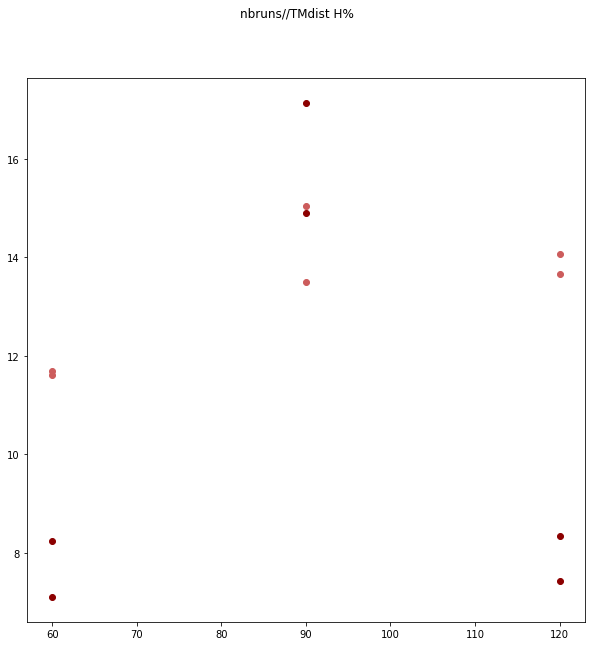

In [14]:
plt.figure(figsize=(10, 10))
plt.suptitle("nbruns//TMdist H%")
for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        if params[animal, session]['treadmillDist'] == 60:
            plt.scatter((60), np.mean([i/(int((params[animal, session]['blocks'][block][1]-params[animal, session]['blocks'][block][0])/60)) for block, i in enumerate(poolByReward([nb_runsBin[animal, session]], params[animal, session]["rewardP_ON"][0]))] ), color = rat_markers[animal][0])
        if params[animal, session]['treadmillDist'] == 90:
            plt.scatter((90), np.mean([i/(int((params[animal, session]['blocks'][block][1]-params[animal, session]['blocks'][block][0])/60)) for block, i in enumerate(poolByReward([nb_runsBin[animal, session]], params[animal, session]["rewardP_ON"][0]))] ), color = rat_markers[animal][0])
        if params[animal, session]['treadmillDist'] == 120:
            plt.scatter((120), np.mean([i/(int((params[animal, session]['blocks'][block][1]-params[animal, session]['blocks'][block][0])/60)) for block, i in enumerate(poolByReward([nb_runsBin[animal, session]], params[animal, session]["rewardP_ON"][0]))] ), color = rat_markers[animal][0])


/home/david/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/david/.local/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


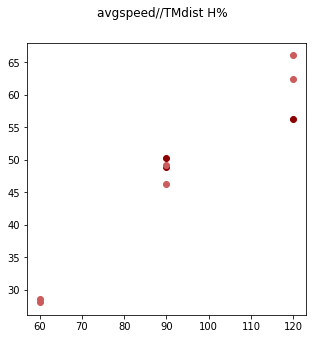

In [15]:
plt.figure(figsize=(5, 5))
plt.suptitle("avgspeed//TMdist H%")
for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        if params[animal, session]['treadmillDist'] == 60:
            plt.scatter((60), np.mean( [np.mean(i) for i in poolByReward([good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session]], params[animal, session]["rewardP_ON"][0])]), color = rat_markers[animal][0])
        if params[animal, session]['treadmillDist'] == 90:
            plt.scatter((90), np.mean( [np.mean(i) for i in poolByReward([good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session]], params[animal, session]["rewardP_ON"][0])]), color = rat_markers[animal][0])
        if params[animal, session]['treadmillDist'] == 120:
            plt.scatter((120), np.mean( [np.mean(i) for i in poolByReward([good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session]], params[animal, session]["rewardP_ON"][0])]), color = rat_markers[animal][0])




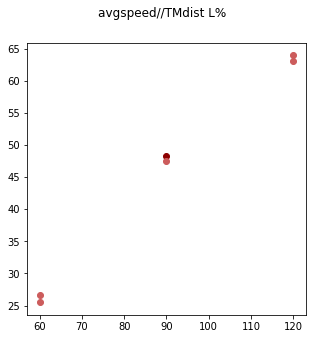

In [16]:
plt.figure(figsize=(5, 5))
plt.suptitle("avgspeed//TMdist L%")
for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        if params[animal, session]['treadmillDist'] == 60:
            plt.scatter((60), np.mean( [np.mean(i) for i in poolByReward([good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session]], params[animal, session]["rewardP_OFF"][0])]), color = rat_markers[animal][0])
        if params[animal, session]['treadmillDist'] == 90:
            plt.scatter((90), np.mean( [np.mean(i) for i in poolByReward([good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session]], params[animal, session]["rewardP_OFF"][0])]), color = rat_markers[animal][0])
        if params[animal, session]['treadmillDist'] == 120:
            plt.scatter((120), np.mean( [np.mean(i) for i in poolByReward([good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session]], params[animal, session]["rewardP_OFF"][0])]), color = rat_markers[animal][0])


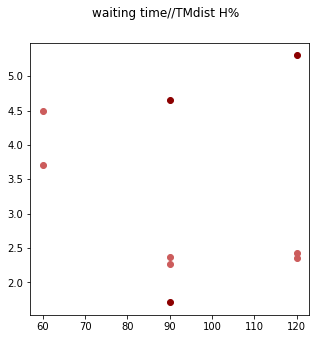

In [17]:
plt.figure(figsize=(5, 5))
plt.suptitle("waiting time//TMdist H%")
for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        if params[animal, session]['treadmillDist'] == 60:
            plt.scatter((60), np.mean([np.mean(i) for i in poolByReward([good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session]], params[animal, session]["rewardP_ON"][0])]), color = rat_markers[animal][0])
        if params[animal, session]['treadmillDist'] == 90:
            plt.scatter((90), np.mean([np.mean(i) for i in poolByReward([good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session]], params[animal, session]["rewardP_ON"][0])]), color = rat_markers[animal][0])
        if params[animal, session]['treadmillDist'] == 120:
            plt.scatter((120), np.mean([np.mean(i) for i in poolByReward([good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session]], params[animal, session]["rewardP_ON"][0])]), color = rat_markers[animal][0])


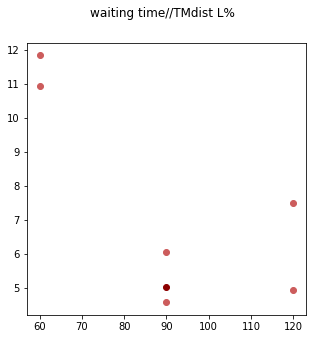

In [18]:
plt.figure(figsize=(5, 5))
plt.suptitle("waiting time//TMdist L%")
for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        if params[animal, session]['treadmillDist'] == 60:
            plt.scatter((60), np.mean([np.mean(i) for i in poolByReward([good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session]], params[animal, session]["rewardP_OFF"][0])]), color = rat_markers[animal][0])
        if params[animal, session]['treadmillDist'] == 90:
            plt.scatter((90), np.mean([np.mean(i) for i in poolByReward([good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session]], params[animal, session]["rewardP_OFF"][0])]), color = rat_markers[animal][0])
        if params[animal, session]['treadmillDist'] == 120:
            plt.scatter((120), np.mean([np.mean(i) for i in poolByReward([good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session]], params[animal, session]["rewardP_OFF"][0])]), color = rat_markers[animal][0])


# stuff in here to use for the final graphes.
def plot_figGRANT1(gooddataRight, gooddataLeft, baddataRight, baddataLeft, trials, rewardProbaBlock, blocks, barplotaxes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1):
    fig = plt.figure(figsize = [20, 5], constrained_layout=False)
    fig.suptitle(session)
    gs = fig.add_gridspec(2, 6)
    for i in range(0, len(blocks)):
        ax1 = fig.add_subplot(gs[0, 0:3])
        plt.axvspan(blocks[i][0], blocks[i][1], color='grey', alpha=rewardProbaBlock[i]/250, label = "%reward: " + str(rewardProbaBlock[i]) if animal == animalList[0] and (i == 0 or i == 1) else "")
        plt.plot(rawTime[animal, session], goodPos[animal, session], label = "run", color="c", linewidth = 0.2)
        plt.plot(rawTime[animal, session], badPos[animal, session], label = "wait", color="orange", linewidth = 0.2)
        ax1.set_title(title[0], fontsize = title[4])
        ax1.set_xlabel(xyLabels[0], fontsize = xyLabels[6])
        ax1.set_ylabel(xyLabels[2], fontsize = xyLabels[6])
        ax1.set_xlim([2400, 3000])
        ax1.set_ylim([barplotaxes[0], barplotaxes[3]+30])
        ax1.spines['bottom'].set_linewidth(linewidth[0])
        ax1.spines['left'].set_linewidth(linewidth[0])
        ax1.spines['top'].set_color("none")
        ax1.spines['right'].set_color("none")
        ax1.tick_params(width=2, labelsize = xyLabels[7])
        x_ticks = np.arange(1800, 3300, 300)
        ax1.set_xticks(x_ticks)
        ax1.set_xticklabels([int(val / 60) for val in ax1.get_xticks().tolist()])
    for i in range(0, len(blocks)):
        ax2 = fig.add_subplot(gs[0, 3:4])
        plt.axvspan(blocks[i][0]/60, blocks[i][1]/60, color='grey', alpha=rewardProbaBlock[i]/250, label = "%reward: " + str(rewardProbaBlock[i]) if animal == animalList[0] and (i == 0 or i == 1) else "")
        plt.scatter(np.full((1, 1), (blocks[i][1] + blocks[i][0])/120), trials[animal, session][i]/(int((blocks[i][1]-blocks[i][0])/60)), s=50, color = "k",label = animal if i == 0 else "")
        for i in range(0, len(blocks)-1):
            plt.plot(((blocks[i][1] + blocks[i][0])/120, (blocks[i+1][1] + blocks[i+1][0])/120), (trials[animal, session][i]/(int((blocks[i][1]-blocks[i][0])/60)), trials[animal, session][i+1]/(int((blocks[i+1][1]-blocks[i+1][0])/60))), color = "k", linewidth = 1)
        plt.scatter(([32.5, 37.5, 42.5, 47.5]), ([21, 21, 21, 21]), s=25, marker = "$\u25BE$", color = "k")
        ax2.set_title(title[1], fontsize = title[4])
        ax2.set_xlabel(xyLabels[0], fontsize = xyLabels[6])
        ax2.set_ylabel(xyLabels[4], fontsize = xyLabels[6])
        ax2.set_xlim([barplotaxes[0], barplotaxes[1]])
        ax2.set_ylim([barplotaxes[4], barplotaxes[5]])
        ax2.spines['bottom'].set_linewidth(linewidth[0])
        ax2.spines['left'].set_linewidth(linewidth[0])
        ax2.spines['top'].set_color("none")
        ax2.spines['right'].set_color("none")
        ax2.tick_params(width=2, labelsize = xyLabels[7])
    for i in range(0, len(blocks)):
        ax3 = fig.add_subplot(gs[0, 4:5])
        plt.axvspan(blocks[i][0]/60, blocks[i][1]/60, color='grey', alpha=rewardProbaBlock[i]/250,  label = "%reward: " + str(rewardProbaBlock[i]) if animal == animalList[0] and (i == 0 or i == 1) else "")
        plt.scatter(np.full((1, 1), (blocks[i][1] + blocks[i][0])/120), np.mean(gooddataLeft[i]+gooddataRight[i]), s=50, color = "c", label = animal if (i==0) else "")
        for i in range(0, len(blocks)-1):
            plt.plot(((blocks[i][1] + blocks[i][0])/120, (blocks[i+1][1] + blocks[i+1][0])/120), (np.mean(gooddataLeft[i]+gooddataRight[i]), np.mean(gooddataLeft[i+1]+gooddataRight[i+1])), color = "c", linewidth = 1)
        plt.scatter(([32.5, 37.5, 42.5, 47.5]), ([88.2, 88.2, 88.2, 88.2]), s=25, marker = "$\u25BE$", color = "k")
        ax3.set_title(title[2], fontsize = title[4])
        ax3.set_xlabel(xyLabels[0], fontsize = xyLabels[6])
        ax3.set_ylabel(xyLabels[1], fontsize = xyLabels[6])
        ax3.set_xlim([barplotaxes[0], barplotaxes[1]])
        ax3.set_ylim([barplotaxes[2], barplotaxes[3]])
        ax3.spines['bottom'].set_linewidth(linewidth[0])
        ax3.spines['left'].set_linewidth(linewidth[0])
        ax3.spines['top'].set_color("none")
        ax3.spines['right'].set_color("none")
        ax3.tick_params(width=2, labelsize = xyLabels[7])
    for i in range(0, len(blocks)):
        ax4 = fig.add_subplot(gs[0, 5:6])
        plt.axvspan(blocks[i][0]/60, blocks[i][1]/60, color='grey', alpha=rewardProbaBlock[i]/250,  label = "%reward: " + str(rewardProbaBlock[i]) if animal == animalList[0] and (i == 0 or i == 1) else "")
        plt.scatter(np.full((1, 1), (blocks[i][1] + blocks[i][0])/120), np.mean(baddataLeft[i]+baddataRight[i]), s=50, color = "orange", label = animal if (i==0) else "")
        for i in range(0, len(blocks)-1):
            plt.plot(((blocks[i][1] + blocks[i][0])/120, (blocks[i+1][1] + blocks[i+1][0])/120), (np.mean(baddataLeft[i]+baddataRight[i]), np.mean(baddataLeft[i+1]+baddataRight[i+1])), color = "orange", linewidth = 1)
        plt.scatter(([32.5, 37.5, 42.5, 47.5]), ([9.55, 9.55, 9.55, 9.55]), s=25, marker = "$\u25BE$", color = "k")
        ax4.set_title(title[3], fontsize = title[4])
        ax4.set_xlabel(xyLabels[0], fontsize = xyLabels[6])
        ax4.set_ylabel(xyLabels[3], fontsize = xyLabels[6])
        ax4.set_xlim([barplotaxes[0], barplotaxes[1]])
        ax4.set_ylim([barplotaxes[4], barplotaxes[6]])
        ax4.spines['bottom'].set_linewidth(linewidth[0])
        ax4.spines['left'].set_linewidth(linewidth[0])
        ax4.spines['top'].set_color("none")
        ax4.spines['right'].set_color("none")
        ax4.tick_params(width=2, labelsize = xyLabels[7])
    plt.tight_layout(pad=1.5)
    return plt
plt.figure(figsize = [21, 6])
for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        plot_figGRANT1(good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session], good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session], nb_runsBin, rewardProbaBlock[animal, session], params[animal, session]['blocks'], barplotaxes = [0, params[animal, session]['sessionDuration']/60, 50, 90, 0, 22, 10], xyLabels=["Time (min)","Avg. run speed (cm/s)", "Position (cm)", "Avg. wait time (s)", "\u0023 runs / min", "", 14, 12], title=["", "", "", "", 16], linewidth = [1.5]) #"Position", "Number of runs", "Speed of runs", "Waiting time",

# #####################################################################################################"
# not currently used
# #####################################################################################################"

# plot tracks with 1 plot per bin.
def plot_tracksBin(animal, session, good_PosdataRight, good_TimedataRight, bad_PosdataRight, bad_TimedataRight, index, blocks, bounds, xylim, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], suptitle = [""], linewidth = 1): 
    plt.figure(figsize = [5*len(blocks), 5])
    for m in range(0, len(blocks)):
        plt.suptitle(suptitle[0], fontsize = suptitle[1])
        ax9 = plt.subplot(1, len(blocks), m+1)
        for i, j in zip(good_PosdataRight[m], good_TimedataRight[m]):
            plt.plot(np.subtract(j, j[0]), i, color='g' , linewidth=0.3)#, label="Good Item" if i == good_PosdataRight[0] and index ==0 else "")
        for k, l in zip(bad_PosdataRight[m], bad_TimedataRight[m]):
            plt.plot(np.subtract(l, l[0]), k, color='r', linewidth=0.3)#,  label="Bad Item" if k == bad_PosdataRight[0] and index == 0 else "")
        ax9.set_title(title[0], fontsize = title[2])
        ax9.set_xlabel(xyLabels[0], fontsize = xyLabels[3])
        ax9.set_ylabel(xyLabels[1], fontsize = xyLabels[3])
        ax9.set_xlim([xylim[0], xylim[1]])
        ax9.set_ylim([xylim[2], xylim[3]])
        ax9.spines['top'].set_color("none")
        ax9.spines['right'].set_color("none")

for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        #plot_tracksBin(animal, session, good_XtrackRunToRightBin[animal, session], good_timeRunToRightBin[animal, session], bad_XtrackRunToRightBin[animal, session], bad_timeRunToRightBin[animal, session], index, params[animal, session]['blocks'], params[animal, session]["boundaries"], xylim = [-0.1, 2, 0, 120, 0, 120], xyLabels=["Run length (s)","X Position (cm)", 14, 12], title=["Run to Right", "Run to Left", 12], suptitle = [animal + " Run Tracks", 16], linewidth = [1.5])
        #plot_tracksBin(animal, session, good_XtrackRunToLeftBin[animal, session], good_timeRunToLeftBin[animal, session], bad_XtrackRunToLeftBin[animal, session], bad_timeRunToLeftBin[animal, session], index, params[animal, session]['blocks'], params[animal, session]["boundaries"], xylim = [-0.1, 2, 0, 120, 0, 120], xyLabels=["Run length (s)","X Position (cm)", 14, 12], title=["Run to Right", "Run to Left", 12], suptitle = [animal + " Run Tracks", 16], linewidth = [1.5])
        #plot_tracksBin(animal, session, good_XtrackStayInRightBin[animal, session], good_TtrackStayInRightBin[animal, session], bad_XtrackStayInRightBin[animal, session], bad_TtrackStayInRightBin[animal, session], index, params[animal, session]['blocks'], params[animal, session]["boundaries"], xylim = [-1, 10, params[animal, session]['treadmillDist']-40, params[animal, session]['treadmillDist']], xyLabels=["Time in zone (s)","X Position (cm)", 14, 12], title=["Time in Right", "Time in Left", 12], suptitle = [animal + " Time in extremities", 16], linewidth = [1.5])
        #plot_tracksBin(animal, session, good_XtrackStayInLeftBin[animal, session], good_TtrackStayInLeftBin[animal, session], bad_XtrackStayInLeftBin[animal, session], bad_TtrackStayInLeftBin[animal, session], index, params[animal, session]['blocks'], params[animal, session]["boundaries"], xylim = [-2, 20, 0, 40], xyLabels=["Time in zone (s)","X Position (cm)", 14, 12], title=["Time in Right", "Time in Left", 12], suptitle = [animal + " Time in extremities", 16], linewidth = [1.5])
        plt.show()

# cut each bin in 1min bins to see the evolution of speed/runs/stay inside bins (e.g. see if rats start running faster at the end of each bin, etc.)

#DRAFT. needs cleaning.
#compute and plot data per binbin --> cut each bin in subbins, to get the evolution of speed/wait inside the bins (e.g. see if arts start running faster/more at the end of the off bin), might be usefull to compare regular blocks and irregular blocks (effect of time keeping maybe).
def binbin_var(var, timevar, blocks):
    #first create the empty dictionary, for var{animal, session{bin{binbin}}}
    binbin_var = {}
    binbin_var[animal, session] = {}
    for i in range(0, len(blocks)):
        binbin_var[animal, session][i] = {}
        for j in range(int((blocks[i][1] - blocks[i][0]) / 60)):
            binbin_var[animal, session][i][j] = []
    #add to binbin if run or stay starts between binbin bounds (for now 60s)
    for i in range(0, len(blocks)):
        for v, t in zip(var[i], timevar[i]):
            for j in range(int((blocks[i][1] - blocks[i][0]) / 60)):
                if t[0] >= blocks[i][0] + j*60 and t[0] < blocks[i][0] + j*60+60:
                    binbin_var[animal, session][i][j].append(v)
    #fill binbins with 0 runs with zero instead of having []
    for i in range(0, len(blocks)):
        for j in range(int((blocks[i][1] - blocks[i][0]) / 60)):
            if binbin_var[animal, session][i][j] == []:
                continue
                #binbin_var[animal, session][i][j] = [0]
    return binbin_var
#maybe a problem with [animal, session] --> already defined inside the function
def plot_runSpeedBinbin(gooddataRight, gooddataLeft, baddataRight, baddataLeft, rewardProbaBlock, blocks, barplotaxes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1):
    fig = plt.figure(figsize = [20, 6])
    gs = gridspec.GridSpec(1, 3, width_ratios = [12, 2, 6])
    ax1 = plt.subplot(gs[0])
    for i in range(0, len(blocks)):
        ax1.axvspan(blocks[i][0]/60, blocks[i][1]/60, color='grey', alpha=rewardProbaBlock[i]/1000, label = "%reward: " + str(rewardProbaBlock[i]) if animal == animalList[0] and (i == 0 or i == 1) else "")
        for b in range(int((blocks[i][1] - blocks[i][0]) / 60)):
            ax1.scatter(np.full((1, 1), (blocks[i][0]+b*60)/60+0.5), np.mean(gooddataRight[animal, session][i][b]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0], label = animal if (i==0) and (b == 0) else "")  
    for i in range(0, len(blocks)):
        for b in range(int((blocks[i][1] - blocks[i][0]) / 60)-1):
            ax1.plot(((blocks[i][0]+b*60)/60+0.5, (blocks[i][0]+b*60+60)/60+0.5), (np.mean(gooddataRight[animal, session][i][b]), np.mean(gooddataRight[animal, session][i][b+1])), color = rat_markers[animal][0], linewidth = 0.5)    
    ax1.set_title(title[0], fontsize = title[3])
    ax1.set_xlabel(xyLabels[0], fontsize = xyLabels[6])
    ax1.set_ylabel(xyLabels[1], fontsize = xyLabels[6])
    ax1.set_xlim([barplotaxes[0], barplotaxes[1]])
    ax1.set_ylim([barplotaxes[2], barplotaxes[3]])
    ax1.spines['bottom'].set_linewidth(linewidth[0])
    ax1.spines['left'].set_linewidth(linewidth[0])
    ax1.spines['top'].set_color("none")
    ax1.spines['right'].set_color("none")
    ax1.tick_params(width=2, labelsize = xyLabels[7])
    plt.legend()
    axbl = plt.subplot(gs[1])
    axbl = blank_plot()
    a10, z10, c10, d10, e10 = [],[],[],[],[]
    a90, z90, c90, d90, e90 = [],[],[],[],[]
    ax2 = plt.subplot(gs[2])
    for i in range(0, len(blocks)):
        for b in range(int((blocks[i][1] - blocks[i][0]) / 60)):
            if b == 0 and rewardProbaBlock[i] == 10: a10.extend(gooddataRight[animal, session][i][b])
            if b == 1 and rewardProbaBlock[i] == 10: z10.extend(gooddataRight[animal, session][i][b])
            if b == 2 and rewardProbaBlock[i] == 10: c10.extend(gooddataRight[animal, session][i][b])
            if b == 3 and rewardProbaBlock[i] == 10: d10.extend(gooddataRight[animal, session][i][b])
            if b == 4 and rewardProbaBlock[i] == 10: e10.extend(gooddataRight[animal, session][i][b])
            if b == 0 and rewardProbaBlock[i] == 90: a90.extend(gooddataRight[animal, session][i][b])
            if b == 1 and rewardProbaBlock[i] == 90: z90.extend(gooddataRight[animal, session][i][b])
            if b == 2 and rewardProbaBlock[i] == 90: c90.extend(gooddataRight[animal, session][i][b])
            if b == 3 and rewardProbaBlock[i] == 90: d90.extend(gooddataRight[animal, session][i][b])
            if b == 4 and rewardProbaBlock[i] == 90: e90.extend(gooddataRight[animal, session][i][b])
    ax2.scatter([0.5, 1.5, 2.5, 3.5, 4.5], [np.mean(a10), np.mean(z10), np.mean(c10), np.mean(d10), np.mean(e10)], s=250, marker=rat_markers[animal][1], color = rat_markers[animal][0], label = "reward10%" )   
    ax2.scatter([0.5, 1.5, 2.5, 3.5, 4.5], [np.mean(a90), np.mean(z90), np.mean(c90), np.mean(d90), np.mean(e90)], s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0], label = "reward90%" ) 
    ax2.plot([0.5, 1.5, 2.5, 3.5, 4.5], [np.mean(a10), np.mean(z10), np.mean(c10), np.mean(d10), np.mean(e10)], color = rat_markers[animal][0], linewidth = 0.5)
    ax2.plot([0.5, 1.5, 2.5, 3.5, 4.5], [np.mean(a90), np.mean(z90), np.mean(c90), np.mean(d90), np.mean(e90)], color = rat_markers[animal][0], linewidth = 1.5) 
    ax2.set_title(title[2], fontsize = title[3])
    ax2.set_xlabel(xyLabels[0], fontsize = xyLabels[6])
    ax2.set_ylabel(xyLabels[1], fontsize = xyLabels[6])
    ax2.set_xlim([barplotaxes[0], barplotaxes[1]/10])
    ax2.set_ylim([barplotaxes[2], barplotaxes[3]])
    ax2.spines['bottom'].set_linewidth(linewidth[0])
    ax2.spines['left'].set_linewidth(linewidth[0])
    ax2.spines['top'].set_color("none")
    ax2.spines['right'].set_color("none")
    ax2.tick_params(width=2, labelsize = xyLabels[7])
    plt.legend()
    return plt   
def plot_nbtrialsBinbin(gooddataRight, gooddataLeft, baddataRight, baddataLeft, rewardProbaBlock, blocks, barplotaxes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1):
    fig = plt.figure(figsize = [20, 6])
    gs = gridspec.GridSpec(1, 3, width_ratios = [12, 2, 6])
    ax1 = plt.subplot(gs[0])
    for i in range(0, len(blocks)):
        ax1.axvspan(blocks[i][0]/60, blocks[i][1]/60, color='grey', alpha=rewardProbaBlock[i]/1000, label = "%reward: " + str(rewardProbaBlock[i]) if animal == animalList[0] and (i == 0 or i == 1) else "")
        for b in range(int((blocks[i][1] - blocks[i][0]) / 60)):
            ax1.scatter(np.full((1, 1), (blocks[i][0]+b*60)/60+0.5), len(gooddataRight[animal, session][i][b]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0], label = animal if (i==0) and (b == 0) else "")  
    for i in range(0, len(blocks)):
        for b in range(int((blocks[i][1] - blocks[i][0]) / 60)-1):
            ax1.plot(((blocks[i][0]+b*60)/60+0.5, (blocks[i][0]+b*60+60)/60+0.5), (len(gooddataRight[animal, session][i][b]), len(gooddataRight[animal, session][i][b+1])), color = rat_markers[animal][0], linewidth = 0.5)    
    ax1.set_title(title[0], fontsize = title[3])
    ax1.set_xlabel(xyLabels[0], fontsize = xyLabels[6])
    ax1.set_ylabel(xyLabels[1], fontsize = xyLabels[6])
    ax1.set_xlim([barplotaxes[0], barplotaxes[1]])
    ax1.set_ylim([barplotaxes[2], barplotaxes[3]])
    ax1.spines['bottom'].set_linewidth(linewidth[0])
    ax1.spines['left'].set_linewidth(linewidth[0])
    ax1.spines['top'].set_color("none")
    ax1.spines['right'].set_color("none")
    ax1.tick_params(width=2, labelsize = xyLabels[7])
    plt.legend()
    axbl = plt.subplot(gs[1])
    axbl = blank_plot()
    a10, z10, c10, d10, e10 = [],[],[],[],[]
    a90, z90, c90, d90, e90 = [],[],[],[],[]
    ax2 = plt.subplot(gs[2])
    for i in range(0, len(blocks)):
        for b in range(int((blocks[i][1] - blocks[i][0]) / 60)):
            if b == 0 and rewardProbaBlock[i] == 10: a10.extend([len(gooddataRight[animal, session][i][b])])
            if b == 1 and rewardProbaBlock[i] == 10: z10.extend([len(gooddataRight[animal, session][i][b])])
            if b == 2 and rewardProbaBlock[i] == 10: c10.extend([len(gooddataRight[animal, session][i][b])])
            if b == 3 and rewardProbaBlock[i] == 10: d10.extend([len(gooddataRight[animal, session][i][b])])
            if b == 4 and rewardProbaBlock[i] == 10: e10.extend([len(gooddataRight[animal, session][i][b])])
            if b == 0 and rewardProbaBlock[i] == 90: a90.extend([len(gooddataRight[animal, session][i][b])])
            if b == 1 and rewardProbaBlock[i] == 90: z90.extend([len(gooddataRight[animal, session][i][b])])
            if b == 2 and rewardProbaBlock[i] == 90: c90.extend([len(gooddataRight[animal, session][i][b])])
            if b == 3 and rewardProbaBlock[i] == 90: d90.extend([len(gooddataRight[animal, session][i][b])])
            if b == 4 and rewardProbaBlock[i] == 90: e90.extend([len(gooddataRight[animal, session][i][b])])
    ax2.scatter([0.5, 1.5, 2.5, 3.5, 4.5], [np.mean(a10), np.mean(z10), np.mean(c10), np.mean(d10), np.mean(e10)], s=250, marker=rat_markers[animal][1], color = rat_markers[animal][0], label = "reward10%" ) 
    ax2.plot([0.5, 1.5, 2.5, 3.5, 4.5], [np.mean(a10), np.mean(z10), np.mean(c10), np.mean(d10), np.mean(e10)], color = rat_markers[animal][0], linewidth = 0.5)
    ax2.scatter([0.5, 1.5, 2.5, 3.5, 4.5], [np.mean(a90), np.mean(z90), np.mean(c90), np.mean(d90), np.mean(e90)], s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0], label = "reward90%" )
    ax2.plot([0.5, 1.5, 2.5, 3.5, 4.5], [np.mean(a90), np.mean(z90), np.mean(c90), np.mean(d90), np.mean(e90)], color = rat_markers[animal][0], linewidth = 1.5)
    ax2.set_title(title[2], fontsize = title[3])
    ax2.set_xlabel(xyLabels[0], fontsize = xyLabels[6])
    ax2.set_ylabel(xyLabels[1], fontsize = xyLabels[6])
    ax2.set_xlim([barplotaxes[0], barplotaxes[1]/10])
    ax2.set_ylim([barplotaxes[2], barplotaxes[3]])
    ax2.spines['bottom'].set_linewidth(linewidth[0])
    ax2.spines['left'].set_linewidth(linewidth[0])
    ax2.spines['top'].set_color("none")
    ax2.spines['right'].set_color("none")
    ax2.tick_params(width=2, labelsize = xyLabels[7])
    plt.legend()
    return plt
#not in terms of [animal, session]
s, st, w, wt = {}, {}, {}, {} 
for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        s[animal, session], st[animal, session], w[animal, session], wt[animal, session] = {}, {}, {}, {} 
        for i in range(0, len(blocks)): 
            s[animal, session][i], st[animal, session][i], w[animal, session][i], wt[animal, session][i] = [], [], [], []
            for s1, s2, st1, st2, w1, w2, wt1, wt2 in zip(good_speedRunToRightBin[animal, session][i], good_speedRunToLeftBin[animal, session][i], good_timeRunToRightBin[animal, session][i], good_timeRunToLeftBin[animal, session][i], 
            good_timeStayInRightBin[animal, session][i], good_timeStayInLeftBin[animal, session][i], good_TtrackStayInRightBin[animal, session][i], good_TtrackStayInLeftBin[animal, session][i]):
                s[animal, session][i].extend([s1, s2])
                st[animal, session][i].extend([st1, st2])
                w[animal, session][i].extend([w1, w2])
                wt[animal, session][i].extend([wt1, wt2])
for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        continue
        #plot_runSpeedBinbin(binbin_var(s[animal, session], st[animal, session], params[animal, session]['blocks']), [], [], [], rewardProbaBlock[animal, session], params[animal, session]['blocks'], barplotaxes = [0, params[animal, session]['sessionDuration']/60, 0, 90], xyLabels=["Time (min)","Speed(cm/s)", "Time (min)", "Speed(cm/s)", "To Right", "To Left", 14, 12], title=["All Rats Speed runs to Left AND Runs to Right per minute", "", "All Rats"+"\n"+ "Speed to L+R per bin pooled", 16], linewidth = [1.5])
for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):      
        continue
        #plot_runSpeedBinbin(binbin_var(w[animal, session], wt[animal, session], params[animal, session]['blocks']), [], [], [], rewardProbaBlock[animal, session], params[animal, session]['blocks'], barplotaxes = [0, params[animal, session]['sessionDuration']/60, 0, 20], xyLabels=["Time (min)","Waiting time (s)", "Time (min)", "Waiting Time (s)", "To Right", "To Left", 14, 12], title=["All Rats Waiting Time in Left AND Waiting time in Right per minute", "", "All Rats"+"\n"+ "Waiting time L+R per bin pooled", 16], linewidth = [1.5])
for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        continue
        #plot_nbtrialsBinbin(binbin_var(s[animal, session], st[animal, session], params[animal, session]['blocks']), [], [], [], rewardProbaBlock[animal, session], params[animal, session]['blocks'], barplotaxes = [0, params[animal, session]['sessionDuration']/60, 0, 30], xyLabels=["Time (min)","Nb runs", "Time (min)", "Speed(cm/s)", "To Right", "To Left", 14, 12], title=["All Rats NB runs to Left AND to Right per minute", "", "All Rats"+"\n"+ "number of runs L+R per bin pooled", 16], linewidth = [1.5])
for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        plot_runSpeedBinbin(binbin_var(good_speedRunToRightBin[animal, session], good_timeRunToRightBin[animal, session], params[animal, session]['blocks']), [], [], [], rewardProbaBlock[animal, session], params[animal, session]['blocks'], barplotaxes = [0, params[animal, session]['sessionDuration']/60, 0, 90], xyLabels=["Time (min)","Speed(cm/s)", "Time (min)", "Speed(cm/s)", "To Right", "To Left", 14, 12], title=["All Rats"+"\n"+ "-->", "All Rats"+"\n"+ "<--", "All Rats"+"\n"+ "Speed runs to Left AND Runs to Right", 16], linewidth = [1.5])
        #plot_runSpeedBinbin(binbin_var(good_speedRunToLeftBin[animal, session], good_timeRunToLeftBin[animal, session], params[animal, session]['blocks']), [], [], [], rewardProbaBlock[animal, session], params[animal, session]['blocks'], barplotaxes = [0, params[animal, session]['sessionDuration']/60, 0, 90], xyLabels=["Time (min)","Speed(cm/s)", "Time (min)", "Speed(cm/s)", "To Right", "To Left", 14, 12], title=["All Rats"+"\n"+ "<--", "All Rats"+"\n"+ "<--", "All Rats"+"\n"+ "Speed runs to Left AND Runs to Right", 16], linewidth = [1.5])
        #plot_runSpeedBinbin(binbin_var(good_timeStayInRightBin[animal, session], good_TtrackStayInRightBin[animal, session], params[animal, session]['blocks']), [], [], [], rewardProbaBlock[animal, session], params[animal, session]['blocks'], barplotaxes = [0, params[animal, session]['sessionDuration']/60, 0, 90], xyLabels=["Time (min)","witing time (s)", "Time (min)", "Speed(cm/s)", "To Right", "To Left", 14, 12], title=["All Rats"+"\n"+ "-->", "All Rats"+"\n"+ "<--", "All Rats"+"\n"+ "waiting time in Left AND Right", 16], linewidth = [1.5])
        #plot_runSpeedBinbin(binbin_var(good_timeStayInLeftBin[animal, session], good_TtrackStayInLeftBin[animal, session], params[animal, session]['blocks']), [], [], [], rewardProbaBlock[animal, session], params[animal, session]['blocks'], barplotaxes = [0, params[animal, session]['sessionDuration']/60, 0, 90], xyLabels=["Time (min)","Waiting time (s)", "Time (min)", "Speed(cm/s)", "To Right", "To Left", 14, 12], title=["All Rats"+"\n"+ "<--", "All Rats"+"\n"+ "<--", "All Rats"+"\n"+ "waiting time in Left AND Right", 16], linewidth = [1.5])

# pool all animals to see global effect. not used bc we want to see indiv variability.
#Old draft, need cleaning.
#function to pool the data
#function to plot
#create vars then pool the data
def poolbins(input_var, animal, session):
    out_var = {bin : [] for bin in range(0, len(params[animal, session]['blocks']))}
    for i in range(0, len(params[animal, session]['blocks'])):
        for animal in animalList:
            for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
                out_var[i].extend(input_var[animal, session][i])
    return out_var 

def plot_runSpeedBinPooled(gooddataRight, gooddataLeft, baddataRight, baddataLeft, rewardProbaBlock, blocks, barplotaxes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1):
    for i in range(0, len(blocks)):
        ax2 = plt.gca()
        plt.axvspan(blocks[i][0]/60, blocks[i][1]/60, color='grey', alpha=rewardProbaBlock[i]/1000, label = "%reward: " + str(rewardProbaBlock[i]) if (i == 0 or i == 1) else "")
        plt.scatter(np.full((1, 1), (blocks[i][1] + blocks[i][0])/120), np.mean(gooddataRight[i]), s=25, color = 'c', label = "Right" if i == 0 else "")
        plt.scatter(np.full((1, 1), (blocks[i][1] + blocks[i][0])/120), np.mean(gooddataLeft[i]), s=25, color = 'b', label = "Left" if i == 0 else "")
        for i in range(0, len(blocks)-1):
            plt.plot(((blocks[i][1] + blocks[i][0])/120, (blocks[i+1][1] + blocks[i+1][0])/120), (np.mean(gooddataRight[i]), np.mean(gooddataRight[i+1])), color = 'c', linewidth = 0.5)
        for i in range(0, len(blocks)-1):
            plt.plot(((blocks[i][1] + blocks[i][0])/120, (blocks[i+1][1] + blocks[i+1][0])/120), (np.mean(gooddataLeft[i]), np.mean(gooddataLeft[i+1])), color = 'b', linewidth = 0.5)
        plt.scatter(np.full((1, 1), (blocks[i][1] + blocks[i][0])/120), np.mean(gooddataRight[i] + baddataRight[i]), s=25, color = 'c', label = "Right" if i == 0 else "", alpha = 0.1)
        plt.scatter(np.full((1, 1), (blocks[i][1] + blocks[i][0])/120), np.mean(gooddataLeft[i] + baddataLeft[i]), s=25, color = 'b', label = "Left" if i == 0 else "", alpha = 0.1)
        for i in range(0, len(blocks)-1):
            plt.plot(((blocks[i][1] + blocks[i][0])/120, (blocks[i+1][1] + blocks[i+1][0])/120), (np.mean(gooddataRight[i] + baddataRight[i]), np.mean(gooddataRight[i+1] + baddataRight[i+1])), color = 'c', linewidth = 0.5, alpha = 0.1)
        for i in range(0, len(blocks)-1):
            plt.plot(((blocks[i][1] + blocks[i][0])/120, (blocks[i+1][1] + blocks[i+1][0])/120), (np.mean(gooddataLeft[i] + baddataLeft[i]), np.mean(gooddataLeft[i+1] + baddataLeft[i+1])), color = 'b', linewidth = 0.5, alpha = 0.1)
        ax2.set_title(title[0], fontsize = title[3])
        ax2.set_xlabel(xyLabels[0], fontsize = xyLabels[6])
        ax2.set_ylabel(xyLabels[1], fontsize = xyLabels[6])
        ax2.set_xlim([barplotaxes[0], barplotaxes[1]])
        ax2.set_ylim([barplotaxes[2], barplotaxes[3]])
        ax2.spines['bottom'].set_linewidth(linewidth[0])
        ax2.spines['left'].set_linewidth(linewidth[0])
        ax2.spines['top'].set_color("none")
        ax2.spines['right'].set_color("none")
        ax2.tick_params(width=2, labelsize = xyLabels[7])
        plt.legend()
    plt.tight_layout(pad=0.5)
    return plt

all_speedRunToRightPooledBin, all_speedRunToLeftPooledBin, all_timeRunToRightPooledBin, all_timeRunToLeftPooledBin, all_timeStayInRightPooledBin, all_timeStayInLeftPooledBin, all_TtrackStayInRightPooledBin, all_TtrackStayInLeftPooledBin, all_instantSpeedRightPooledBin, all_instantSpeedLeftPooledBin, all_maxSpeedRightPooledBin, all_maxSpeedLeftPooledBin, good_speedRunToRightPooledBin, good_speedRunToLeftPooledBin, good_XtrackRunToRightPooledBin, good_XtrackRunToLeftPooledBin, good_timeRunToRightPooledBin, good_timeRunToLeftPooledBin, bad_speedRunToRightPooledBin, bad_speedRunToLeftPooledBin, bad_XtrackRunToRightPooledBin, bad_XtrackRunToLeftPooledBin, bad_timeRunToRightPooledBin, bad_timeRunToLeftPooledBin, good_instantSpeedRightPooledBin, good_instantSpeedLeftPooledBin, good_maxSpeedRightPooledBin, good_maxSpeedLeftPooledBin, bad_instantSpeedRightPooledBin, bad_instantSpeedLeftPooledBin, bad_maxSpeedRightPooledBin, bad_maxSpeedLeftPooledBin, good_timeStayInRightPooledBin, good_timeStayInLeftPooledBin, good_XtrackStayInRightPooledBin, good_XtrackStayInLeftPooledBin, good_TtrackStayInRightPooledBin, good_TtrackStayInLeftPooledBin, bad_timeStayInRightPooledBin, bad_timeStayInLeftPooledBin, bad_XtrackStayInRightPooledBin, bad_XtrackStayInLeftPooledBin, bad_TtrackStayInRightPooledBin, bad_TtrackStayInLeftPooledBin, lick_arrivalRightPooledBin, lick_drinkingRightPooledBin, lick_waitRightPooledBin, lick_arrivalLeftPooledBin, lick_drinkingLeftPooledBin, lick_waitLeftPooledBin = ({} for i in range(50))
all_speedRunToRightPooledBin, all_speedRunToLeftPooledBin, all_timeRunToRightPooledBin, all_timeRunToLeftPooledBin, all_timeStayInRightPooledBin, all_timeStayInLeftPooledBin, all_TtrackStayInRightPooledBin, all_TtrackStayInLeftPooledBin, all_instantSpeedRightPooledBin, all_instantSpeedLeftPooledBin, all_maxSpeedRightPooledBin, all_maxSpeedLeftPooledBin, good_speedRunToRightPooledBin, good_speedRunToLeftPooledBin, good_XtrackRunToRightPooledBin, good_XtrackRunToLeftPooledBin, good_timeRunToRightPooledBin, good_timeRunToLeftPooledBin, bad_speedRunToRightPooledBin, bad_speedRunToLeftPooledBin, bad_XtrackRunToRightPooledBin, bad_XtrackRunToLeftPooledBin, bad_timeRunToRightPooledBin, bad_timeRunToLeftPooledBin, good_instantSpeedRightPooledBin, good_instantSpeedLeftPooledBin, good_maxSpeedRightPooledBin, good_maxSpeedLeftPooledBin, bad_instantSpeedRightPooledBin, bad_instantSpeedLeftPooledBin, bad_maxSpeedRightPooledBin, bad_maxSpeedLeftPooledBin, good_timeStayInRightPooledBin, good_timeStayInLeftPooledBin, good_XtrackStayInRightPooledBin, good_XtrackStayInLeftPooledBin, good_TtrackStayInRightPooledBin, good_TtrackStayInLeftPooledBin, bad_timeStayInRightPooledBin, bad_timeStayInLeftPooledBin, bad_XtrackStayInRightPooledBin, bad_XtrackStayInLeftPooledBin, bad_TtrackStayInRightPooledBin, bad_TtrackStayInLeftPooledBin, lick_arrivalRightPooledBin, lick_drinkingRightPooledBin, lick_waitRightPooledBin, lick_arrivalLeftPooledBin, lick_drinkingLeftPooledBin, lick_waitLeftPooledBin = poolbins(all_speedRunToRightBin, animal, session), poolbins(all_speedRunToLeftBin, animal, session), poolbins(all_timeRunToRightBin, animal, session), poolbins(all_timeRunToLeftBin, animal, session), poolbins(all_timeStayInRightBin, animal, session), poolbins(all_timeStayInLeftBin, animal, session), poolbins(all_TtrackStayInRightBin, animal, session), poolbins(all_TtrackStayInLeftBin, animal, session), poolbins(all_instantSpeedRightBin, animal, session), poolbins(all_instantSpeedLeftBin, animal, session), poolbins(all_maxSpeedRightBin, animal, session), poolbins(all_maxSpeedLeftBin, animal, session), poolbins(good_speedRunToRightBin, animal, session), poolbins(good_speedRunToLeftBin, animal, session), poolbins(good_XtrackRunToRightBin, animal, session), poolbins(good_XtrackRunToLeftBin, animal, session), poolbins(good_timeRunToRightBin, animal, session), poolbins(good_timeRunToLeftBin, animal, session), poolbins(bad_speedRunToRightBin, animal, session), poolbins(bad_speedRunToLeftBin, animal, session), poolbins(bad_XtrackRunToRightBin, animal, session), poolbins(bad_XtrackRunToLeftBin, animal, session), poolbins(bad_timeRunToRightBin, animal, session), poolbins(bad_timeRunToLeftBin, animal, session), poolbins(good_instantSpeedRightBin, animal, session), poolbins(good_instantSpeedLeftBin, animal, session), poolbins(good_maxSpeedRightBin, animal, session), poolbins(good_maxSpeedLeftBin, animal, session), poolbins(bad_instantSpeedRightBin, animal, session), poolbins(bad_instantSpeedLeftBin, animal, session), poolbins(bad_maxSpeedRightBin, animal, session), poolbins(bad_maxSpeedLeftBin, animal, session), poolbins(good_timeStayInRightBin, animal, session), poolbins(good_timeStayInLeftBin, animal, session), poolbins(good_XtrackStayInRightBin, animal, session), poolbins(good_XtrackStayInLeftBin, animal, session), poolbins(good_TtrackStayInRightBin, animal, session), poolbins(good_TtrackStayInLeftBin, animal, session), poolbins(bad_timeStayInRightBin, animal, session), poolbins(bad_timeStayInLeftBin, animal, session), poolbins(bad_XtrackStayInRightBin, animal, session), poolbins(bad_XtrackStayInLeftBin, animal, session), poolbins(bad_TtrackStayInRightBin, animal, session), poolbins(bad_TtrackStayInLeftBin, animal, session), poolbins(lick_arrivalRightBin, animal, session), poolbins(lick_drinkingRightBin, animal, session), poolbins(lick_waitRightBin, animal, session), poolbins(lick_arrivalLeftBin, animal, session), poolbins(lick_drinkingLeftBin, animal, session), poolbins(lick_waitLeftBin, animal, session)

fig = plt.figure(constrained_layout = False, figsize=(30, 7))
fig.suptitle("POOLED", y= 1, fontsize = 24)
gs = fig.add_gridspec(1, 30)
ax00 = fig.add_subplot(gs[0, 0:15])
ax00 = plot_runSpeedBinPooled(good_speedRunToRightPooledBin, good_speedRunToLeftPooledBin, bad_speedRunToRightPooledBin, bad_speedRunToLeftPooledBin, rewardProbaBlock[animal, session], params[animal, session]['blocks'], barplotaxes = [0.5, params[animal, session]['sessionDuration']/60, 0, 100], xyLabels=["Time (min)","Speed(cm/s)", "Time (min)", "Speed(cm/s)", "", "", 14, 12], title=["All Rats Pooled"+"\n"+ "To Left vs. To Right", "All Rats Pooled"+"\n"+ "In Left vs. In Right", "", 16], linewidth = [1.5])
ax01 = fig.add_subplot(gs[0, 15:30])
ax01 = plot_runSpeedBinPooled(good_timeStayInRightPooledBin, good_timeStayInLeftPooledBin, bad_timeStayInRightPooledBin, bad_timeStayInLeftPooledBin, rewardProbaBlock[animal, session], params[animal, session]['blocks'], barplotaxes = [0.5, params[animal, session]['sessionDuration']/60, 0, 15], xyLabels=["Time (min)","Time in zone (s)", "Time (min)", "Speed(cm/s)", "", "", 14, 12], title=["All Rats Pooled"+"\n"+ "In Left vs. In Right", "All Rats Pooled"+"\n"+ "In Left vs. In Right", "", 16], linewidth = [1.5])

# plot speed in apparatus for each bin 

bingoodPos, binbadPos = {}, {}
bingoodSpeed, binbadSpeed = {}, {}
for animal in animalList: 
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        for bin in range(0, len(params[animal, session]['blocks'])):
            fig = plt.figure(constrained_layout=True, figsize=(21,3))
            #plt.plot(binPositionX[animal,session][bin], binSpeed[animal,session][bin], linewidth=0.5)
            bingoodPos[animal, session] = reCutBins(goodPos[animal, session], binMask[animal, session])
            binbadPos[animal,session]   = reCutBins(badPos[animal, session], binMask[animal, session])
            bingoodSpeed[animal,session] = reCutBins(goodSpeed[animal, session], binMask[animal, session])
            binbadSpeed[animal,session] = reCutBins(badSpeed[animal, session], binMask[animal, session])
            plt.plot(binPositionX[animal,session][bin], bingoodSpeed[animal,session][bin], linewidth=0.5)
            plt.plot(binPositionX[animal,session][bin], binbadSpeed[animal,session][bin], linewidth=0.5)
            plt.xlabel('position (cm)')
            plt.ylabel('speed (cm/s)')
            plt.xlim(0,130)
            plt.ylim(-150,150)
            yline = [0, 120]
            xline = [0,0]
            plt.plot(yline, xline, ":", color='k')

# plot XY trajectory
plt.figure(figsize = [20, 5])
for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]): 
        plt.figure(figsize = [30, 5])
        print(animal, session)
        plt.plot(rawPositionX[animal, session],rawPositionY[animal, session],[0,120,1],[0,15,1], linewidth=0.1)
        plt.plot([None if x == 0 else x for x in  rawLickLeftX[animal, session]],rawPositionY[animal, session],[0,120,1],[0,15,1], linewidth=0.1, marker='o', markersize=0.1)
        plt.plot([None if x == 0 else x for x in rawLickRightX[animal, session]],rawPositionY[animal, session],[0,120,1],[0,15,1], linewidth=0.1, marker='o', markersize=0.1)
        xa, xb, ya, yb = 0, 116, 11, 1
        plt.plot((xa, xb), (yb, yb), linewidth=2, color = 'k')
        plt.plot((xa, xb), (ya, ya), linewidth=2, color = 'k')
        plt.plot((xa, xa), (ya, yb), linewidth=2, color = 'k')
        plt.plot((xb, xb), (ya, yb), linewidth=2, color = 'k')

# donut for each block
plt.figure(figsize = [20, 5])
for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]): 
        for i in range(0, len(params[animal, session]['blocks'])):
            plt.figure(figsize = [30, 5])
            print(animal, session)
            plt.plot(binPositionX[animal, session][i], binPositionY[animal, session][i],[0,120,1],[0,15,1], linewidth=0.1)
            plt.plot([None if x == 0 else x for x in binLickLeftX[animal, session][i]],binPositionY[animal, session][i],[0,120,1],[0,15,1], linewidth=0.1, marker='o', markersize=0.1)
            plt.plot([None if x == 0 else x for x in binLickRightX[animal, session][i]],binPositionY[animal, session][i],[0,120,1],[0,15,1], linewidth=0.1, marker='o', markersize=0.1)
            xa, xb, ya, yb = 0, 116, 11, 1
            plt.plot((xa, xb), (yb, yb), linewidth=2, color = 'k')
            plt.plot((xa, xb), (ya, ya), linewidth=2, color = 'k')
            plt.plot((xa, xa), (ya, yb), linewidth=2, color = 'k')
            plt.plot((xb, xb), (ya, yb), linewidth=2, color = 'k')

# plot speed as function of weight
plt.figure(figsize = [6, 8])
for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        xline = [params[animal, session]["weight"], params[animal, session]["weight"]]
        yline = [np.mean(good_speedRunToRight[animal, session]),np.mean(good_speedRunToLeft[animal, session])]
        plt.xlabel('Rat Weight (g)')
        plt.ylabel('speed(cm/s)')
        plt.title('Effect of weight on speed')
        plt.scatter(params[animal, session]["weight"], np.mean(good_speedRunToRight[animal, session]), s=25, color =rat_markers[animal][0], marker=rat_markers[animal][1], label = "toRight")
        plt.scatter(params[animal, session]["weight"], np.mean(good_speedRunToLeft[animal, session]), s=25, color =rat_markers[animal][0], marker=rat_markers[animal][1], label = "toLeft")
        plt.scatter(params[animal, session]["weight"], abs(np.mean(good_speedRunToRight[animal, session]) - np.mean(good_speedRunToLeft[animal, session])), s=25, color =rat_markers[animal][0], marker=rat_markers[animal][1], label = "|Right-left|")
        plt.plot(xline, yline, ":", color='k')
        plt.axis([100, 500, 0, 80 ])
        plt.legend()

# compute the average position at which we detect the start/end of the runs (starttoright, endtoright, starttoleft, endtoleft) and the average speed recorded at this position
runrightstart, runrightend, runleftstart, runleftend, speedrightstart, speedrightend, speedleftstart, speedleftend = ({} for i in range(8))
for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        runrightstart[animal, session], runrightend[animal, session], runleftstart[animal, session], runleftend[animal, session], speedrightstart[animal, session], speedrightend[animal, session], speedleftstart[animal, session], speedleftend[animal, session] = ([] for i in range(8))
        for i, j, k, l in zip(good_XtrackRunToRight[animal, session], good_XtrackRunToLeft[animal, session], good_instantSpeedRight[animal, session], good_instantSpeedLeft[animal, session]):
            runrightstart[animal, session].append(i[0])
            runrightend[animal, session].append(i[-1])
            runleftstart[animal, session].append(j[0])
            runleftend[animal, session].append(j[-1])
            speedrightstart[animal, session].append(k[0])
            speedrightend[animal, session].append(k[-1])
            speedleftstart[animal, session].append(l[0])
            speedleftend[animal, session].append(l[-1])
        print(session)
        print(np.mean(runrightstart[animal, session]), scipy.stats.sem(runrightstart[animal, session]))
        print(np.mean(runrightend[animal, session]), scipy.stats.sem(runrightend[animal, session]))
        print(np.mean(runleftstart[animal, session]), scipy.stats.sem(runleftstart[animal, session]))
        print(np.mean(runleftend[animal, session]), scipy.stats.sem(runleftend[animal, session]))
        print()
        print(np.mean(speedrightstart[animal, session]), scipy.stats.sem(speedrightstart[animal, session]))
        print(np.mean(speedrightend[animal, session]), scipy.stats.sem(speedrightend[animal, session]))
        print(np.mean(speedleftstart[animal, session]), scipy.stats.sem(speedleftstart[animal, session]))
        print(np.mean(speedleftend[animal, session]), scipy.stats.sem(speedleftend[animal, session]))
        print()

# compute acceleration, plot acceleration histogram, no real application yet. 
def compute_acceleration(dataSpeed, dataTime): #speed only computed along X axis. Compute along X AND Y axis?
    rawdata_acc = {}
    deltaXSpeed = (np.diff(dataSpeed))
    deltaTime = (np.diff(dataTime))
    rawdata_acc = np.divide(deltaXSpeed, deltaTime)
    rawdata_acc = np.append(rawdata_acc, 0)
    return rawdata_acc.astype('float32')

rawAcceleration = {}
for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        rawAcceleration[animal, session] = compute_acceleration(rawSpeed[animal, session], rawTime[animal, session])

fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(8, 4))
fig.suptitle(animal + " " + session)

ax1.hist([[val for val in goodSpeed[animal,session] if val], [val for val in badSpeed[animal,session] if val]], 50, histtype = 'bar', stacked = True);
ax2.hist(rawAcceleration[animal,session], np.arange(-300,300, 12));
ax1.set_xlabel("speed (cm*s)")
ax1.set_ylabel("#")
ax2.set_xlabel("acc (cm*s^-2)")
ax2.set_ylabel("#")

# visual example smoothing
xa = 1280
xb = 1300
ya= -20
yb= 150
yline = [0, 3600]
xline = [0,0]
truerawPositionX, truerawSpeed, truerawSpeed2 = ({} for i in range(3)) 
for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        truerawPositionX[animal, session]  = extractPositionX[animal, session][extractTime[animal, session] <= params[animal, session]["sessionDuration"]]
        truerawPositionX[animal, session] = datapx2cm(truerawPositionX[animal, session])
        truerawSpeed[animal, session] = compute_speed(truerawPositionX[animal, session], rawTime[animal, session])
        truerawSpeed2[animal, session] = compute_speed(rawPositionX[animal, session], rawTime[animal, session])

fig = plt.figure(constrained_layout=True, figsize=(30,6))
plot_BASEtrajectory(rawTime[animal, session],rawPositionX[animal, session], rawLickLeftX[animal, session], rawLickRightX[animal, session], [xa+1, xb-1 ,1],[ya,yb,1],  color = ["b", "c"], marker = ["", "", 0], linewidth = [1], xyLabels=["Position (cm)", "Time(s)"])
plot_BASEtrajectory(rawTime[animal, session],truerawPositionX[animal, session], rawLickLeftX[animal, session], rawLickRightX[animal, session], [xa+1, xb-1 ,1],[ya,yb,1],  color = ["r", "k"], marker = ["", "", 0], linewidth = [2], xyLabels=["Position (cm)", "Time(s)"])
plt.plot()
fig2 = plt.figure(constrained_layout=True, figsize=(30,6))
plt.plot(rawTime[animal,session], rawSpeed[animal,session], 'c', linewidth = 3)
plt.plot(rawTime[animal,session], truerawSpeed[animal, session], "r", linewidth = 2)
plt.plot(yline, xline, ":", color='k')
plt.xlabel('time (s)')
plt.ylabel('speed (cm/s)')
plt.xlim(xa+1, xb-1)
plt.ylim(-150,150)
plt.plot()

# almost duplicate baseTrajectory function.
def plot_fig(rewardProbaBlock, blocks, barplotaxes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1):
    fig = plt.figure(figsize = [30, 5], constrained_layout=False)
    ax1 = plt.gca()
    for i in range(0, len(blocks)):
        plt.axvspan(blocks[i][0], blocks[i][1], color='grey', alpha=rewardProbaBlock[i]/250, label = "%reward: " + str(rewardProbaBlock[i]) if animal == animalList[0] and (i == 0 or i == 1) else "")
    plt.plot(rawTime[animal, session], goodPos[animal, session], label = "run", color="c", linewidth = 1)
    plt.plot(rawTime[animal, session], badPos[animal, session], label = "wait", color="orange", linewidth = 1)
    ax1.set_title(title[0], fontsize = title[4])
    ax1.set_xlabel(xyLabels[0], fontsize = xyLabels[6])
    ax1.set_ylabel(xyLabels[2], fontsize = xyLabels[6])
    ax1.set_xlim([barplotaxes[0], barplotaxes[1]])
    ax1.set_ylim([barplotaxes[2], barplotaxes[3]])
    ax1.spines['bottom'].set_linewidth(linewidth[0])
    ax1.spines['left'].set_linewidth(linewidth[0])
    ax1.spines['top'].set_color("none")
    ax1.spines['right'].set_color("none")
    ax1.tick_params(width=2, labelsize = xyLabels[7])
    #ax1_ticks = np.arange(1800, 3300, 300)
    #ax1.set_xticks(x_ticks)
    #ax1.set_xticklabels([int(val / 60) for val in ax1.get_xticks().tolist()])
for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        continue
plot_fig(rewardProbaBlock[animal, session], params[animal, session]['blocks'], barplotaxes = [0, params[animal, session]['sessionDuration'], 0, 120, 0, 22, 10], xyLabels=["Time (min)","", "Position (cm)", "", "", "", 14, 12], title=[session, "", "", "", 16], linewidth = [1.5])
        #plt.plot()

# compare NbRuns, Speed, Stay to/in Right Left between 10% reward and 90% reward

#old way of separating high% and low%
#left/right separation
ON = {}
OFF = {}
ON1 = {}
OFF1 = {}
ON2 = {}
OFF2 = {}
ON3 = {}
OFF3 = {}
ON4 = {}
OFF4 = {}
plt.figure(figsize = [30, 6])
for animal in animalList:
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        ON[animal, session] = []
        OFF[animal, session] = []
        ON1[animal, session] = []
        OFF1[animal, session] = [] 
        ON2[animal, session] = []
        OFF2[animal, session] = [] 
        ON3[animal, session] = []
        OFF3[animal, session] = [] 
        ON4[animal, session] = []
        OFF4[animal, session] = [] 
        for i in range(0, len(params[animal, session]['blocks'])):
            ax1 = plt.subplot(1,5,1)
            ax2 = plt.subplot(1,5,2)
            ax3 = plt.subplot(1,5,3)
            ax4 = plt.subplot(1,5,4)
            ax5 = plt.subplot(1,5,5)
            #normalize number of runs per minute: number of runs in block / lenght of block in minutes {block end - block start}
            ax1.scatter(np.random.normal(rewardProbaBlock[animal, session][i], 1, 1), nb_runsBin[animal, session][i]/(int((params[animal, session]['blocks'][i][1]-params[animal, session]['blocks'][i][0])/60)), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0],label = animal if i == 0 else "")
            ax2.scatter(np.random.normal(rewardProbaBlock[animal, session][i], 1, 1), np.mean(good_speedRunToRightBin[animal, session][i]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0],label = animal if i == 0 else "")
            ax3.scatter(np.random.normal(rewardProbaBlock[animal, session][i], 1, 1), np.mean(good_speedRunToLeftBin[animal, session][i]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0],label = animal if i == 0 else "")
            ax4.scatter(np.random.normal(rewardProbaBlock[animal, session][i], 1, 1), np.mean(good_timeStayInRightBin[animal, session][i]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0],label = animal if i == 0 else "")
            ax5.scatter(np.random.normal(rewardProbaBlock[animal, session][i], 1, 1), np.mean(good_timeStayInLeftBin[animal, session][i]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0],label = animal if i == 0 else "")
            if rewardProbaBlock[animal, session][i] == params[animal, session]["rewardP_ON"][0]:
                ON[animal, session].append(nb_runsBin[animal, session][i]/(int((params[animal, session]['blocks'][i][1]-params[animal, session]['blocks'][i][0])/60)))
                ON1[animal, session].append(np.mean(good_speedRunToRightBin[animal, session][i]))
                ON2[animal, session].append(np.mean(good_speedRunToLeftBin[animal, session][i]))
                ON3[animal, session].append(np.mean(good_timeStayInRightBin[animal, session][i]))
                ON4[animal, session].append(np.mean(good_timeStayInLeftBin[animal, session][i]))
            if rewardProbaBlock[animal, session][i] == params[animal, session]["rewardP_OFF"][0]:
                OFF[animal, session].append(nb_runsBin[animal, session][i]/(int((params[animal, session]['blocks'][i][1]-params[animal, session]['blocks'][i][0])/60)))
                OFF1[animal, session].append(np.mean(good_speedRunToRightBin[animal, session][i]))
                OFF2[animal, session].append(np.mean(good_speedRunToLeftBin[animal, session][i]))
                OFF3[animal, session].append(np.mean(good_timeStayInRightBin[animal, session][i]))
                OFF4[animal, session].append(np.mean(good_timeStayInLeftBin[animal, session][i]))
        print("nb trials ON-OFF", np.mean(ON[animal, session]), np.mean(OFF[animal, session]))
        print("to right", np.mean(ON1[animal, session]), np.mean(OFF1[animal, session]))
        print("to left", np.mean(ON2[animal, session]), np.mean(OFF2[animal, session]))
        print("in right", np.mean(ON3[animal, session]), np.mean(OFF3[animal, session]))
        print("in left", np.mean(ON4[animal, session]), np.mean(OFF4[animal, session]))
        ax1.boxplot(ON[animal, session], positions = [params[animal, session]["rewardP_ON"][0]+10], widths = 5, manage_ticks= False, patch_artist=True, boxprops=dict(facecolor=rat_markers[animal][0], color=rat_markers[animal][0]))
        ax1.boxplot(OFF[animal, session], positions = [params[animal, session]["rewardP_OFF"][0]+10], widths = 5, manage_ticks= False, patch_artist=True, boxprops=dict(facecolor=rat_markers[animal][0], color=rat_markers[animal][0]))
        ax2.boxplot(ON1[animal, session], positions = [params[animal, session]["rewardP_ON"][0]+10], widths = 5, manage_ticks= False, patch_artist=True, boxprops=dict(facecolor=rat_markers[animal][0], color=rat_markers[animal][0]))
        ax2.boxplot(OFF1[animal, session], positions = [params[animal, session]["rewardP_OFF"][0]+10], widths = 5, manage_ticks= False, patch_artist=True, boxprops=dict(facecolor=rat_markers[animal][0], color=rat_markers[animal][0]))
        ax3.boxplot(ON2[animal, session], positions = [params[animal, session]["rewardP_ON"][0]+10], widths = 5, manage_ticks= False, patch_artist=True, boxprops=dict(facecolor=rat_markers[animal][0], color=rat_markers[animal][0]))
        ax3.boxplot(OFF2[animal, session], positions = [params[animal, session]["rewardP_OFF"][0]+10], widths = 5, manage_ticks= False, patch_artist=True, boxprops=dict(facecolor=rat_markers[animal][0], color=rat_markers[animal][0]))
        ax4.boxplot(ON3[animal, session], positions = [params[animal, session]["rewardP_ON"][0]+10], widths = 5, manage_ticks= False, patch_artist=True, boxprops=dict(facecolor=rat_markers[animal][0], color=rat_markers[animal][0]))
        ax4.boxplot(OFF3[animal, session], positions = [params[animal, session]["rewardP_OFF"][0]+10], widths = 5, manage_ticks= False, patch_artist=True, boxprops=dict(facecolor=rat_markers[animal][0], color=rat_markers[animal][0]))
        ax5.boxplot(ON4[animal, session], positions = [params[animal, session]["rewardP_ON"][0]+10], widths = 5, manage_ticks= False, patch_artist=True, boxprops=dict(facecolor=rat_markers[animal][0], color=rat_markers[animal][0]))
        ax5.boxplot(OFF4[animal, session], positions = [params[animal, session]["rewardP_OFF"][0]+10], widths = 5, manage_ticks= False, patch_artist=True, boxprops=dict(facecolor=rat_markers[animal][0], color=rat_markers[animal][0]))
    ax1.set_xlim(-5, 105)
    ax1.set_ylim(-5, 20)
    ax1.set_title("nb of runs")
    ax1.set_xlabel("Reward probability", fontsize = 12)
    ax1.set_ylabel("number of crossings per block / block_time", fontsize = 12)
    ax2.set_xlim(-5, 105)
    ax2.set_ylim(20, 100)
    ax2.set_title("speed to right")
    ax2.set_xlabel("Reward probability", fontsize = 12)
    ax2.set_ylabel("average speed to right per block (cm/s)", fontsize = 12)
    ax3.set_xlim(-5, 105)
    ax3.set_ylim(20, 100)
    ax3.set_title("speed to left")
    ax3.set_xlabel("Reward probability", fontsize = 12)
    ax3.set_ylabel("average speed to left per block (cm/s)", fontsize = 12)
    ax4.set_xlim(-5, 105)
    ax4.set_ylim(0, 15)
    ax4.set_title("time in right")
    ax4.set_xlabel("Reward probability", fontsize = 12)
    ax4.set_ylabel("average time in right per block (s)", fontsize = 12)
    ax5.set_xlim(-5, 105)
    ax5.set_ylim(0, 15)
    ax5.set_title("time in left")
    ax5.set_xlabel("Reward probability", fontsize = 12)
    ax5.set_ylabel("average time in left per block (s)", fontsize = 12)

In [19]:
###TODO###
#explain how data is processed
# Look at all the stuff in the bottom, possible cool stuff (explore weight effect and evolution /speed /peakspeed /number of runs, etc.)
# look at speed by computing it on X and Y axis, not only X
#compare between days
#add stats on figs
#average track per animal/group , dimension reduction
#analyse training data
#stats timeBins
#spread in scatter plot proportional to density*

# test multiprocessing
#choose whether to recompute all behav. General switch that will either recompute all or nothing. Can specify whether to redo or not in the specific computation cells.
redoAll_Override = True
if redoAll_Override is not None:
    if redoAll_Override == False:
        redoBoundKDE, redoExtractRuns_wBounds, redoMask, redoExtractRuns_wSpeed, redoExtractRunsBin_wSpeed = False, False, False, False, False
    if redoAll_Override == True:
        redoBoundKDE, redoExtractRuns_wBounds, redoMask, redoExtractRuns_wSpeed, redoExtractRunsBin_wSpeed = True, True, True, True, True
#Use previously defined functions to compute the boundaries and store them in params. Result is saved as pickle. 
if redoAll_Override is None: redoBoundKDE = False #redo computation YES/NO
if redoAll_Override is None: redoMask = False #redo computation YES/NO
if redoAll_Override is None: redoExtractRuns_wSpeed = False #redo computation YES/NO
if redoAll_Override is None: redoExtractRunsBin_wSpeed = False
leftBoundaryPeak, rightBoundaryPeak, kde = {}, {}, {}
smoothMask, rawMask, binSpeed, binMask = {}, {}, {}, {}
goodPos, badPos, goodSpeed, badSpeed = {}, {}, {}, {}
speedToRightCharacteristics, speedToLeftCharacteristics, speedToRightCharacteristicsBin, speedToLeftCharacteristicsBin = {}, {}, {}, {}
limspeedRunToRight, limspeedRunToLeft, limstayRight, limstayLeft, all_speedRunToRight, all_speedRunToLeft, all_timeRunToRight, all_timeRunToLeft, all_timeStayInRight, all_timeStayInLeft, all_TtrackStayInRight, all_TtrackStayInLeft, all_instantSpeedRight, all_instantSpeedLeft, all_maxSpeedRight, all_maxSpeedLeft, good_speedRunToRight, good_speedRunToLeft, good_XtrackRunToRight, good_XtrackRunToLeft, good_timeRunToRight, good_timeRunToLeft, bad_speedRunToRight, bad_speedRunToLeft, bad_XtrackRunToRight,bad_XtrackRunToLeft, bad_timeRunToRight, bad_timeRunToLeft, good_instantSpeedRight, good_instantSpeedLeft, good_maxSpeedRight, good_maxSpeedLeft, bad_instantSpeedRight, bad_instantSpeedLeft, bad_maxSpeedRight, bad_maxSpeedLeft, good_timeStayInRight, good_timeStayInLeft, good_XtrackStayInRight, good_XtrackStayInLeft, good_TtrackStayInRight, good_TtrackStayInLeft, bad_timeStayInRight, bad_timeStayInLeft, bad_XtrackStayInRight, bad_XtrackStayInLeft, bad_TtrackStayInRight, bad_TtrackStayInLeft, lick_arrivalRight, lick_drinkingRight, lick_waitRight, lick_arrivalLeft, lick_drinkingLeft, lick_waitLeft = ({} for i in range(54))
limspeedRunToRightBin, limspeedRunToLeftBin, limstayRightBin, limstayLeftBin, all_speedRunToRightBin, all_speedRunToLeftBin, all_timeRunToRightBin, all_timeRunToLeftBin, all_timeStayInRightBin, all_timeStayInLeftBin, all_TtrackStayInRightBin, all_TtrackStayInLeftBin, all_instantSpeedRightBin, all_instantSpeedLeftBin, all_maxSpeedRightBin, all_maxSpeedLeftBin, good_speedRunToRightBin, good_speedRunToLeftBin, good_XtrackRunToRightBin, good_XtrackRunToLeftBin, good_timeRunToRightBin, good_timeRunToLeftBin, bad_speedRunToRightBin, bad_speedRunToLeftBin, bad_XtrackRunToRightBin, bad_XtrackRunToLeftBin, bad_timeRunToRightBin, bad_timeRunToLeftBin, good_instantSpeedRightBin, good_instantSpeedLeftBin, good_maxSpeedRightBin, good_maxSpeedLeftBin, bad_instantSpeedRightBin, bad_instantSpeedLeftBin, bad_maxSpeedRightBin, bad_maxSpeedLeftBin, good_timeStayInRightBin, good_timeStayInLeftBin, good_XtrackStayInRightBin, good_XtrackStayInLeftBin, good_TtrackStayInRightBin, good_TtrackStayInLeftBin, bad_timeStayInRightBin, bad_timeStayInLeftBin, bad_XtrackStayInRightBin, bad_XtrackStayInLeftBin, bad_TtrackStayInRightBin, bad_TtrackStayInLeftBin, lick_arrivalRightBin, lick_drinkingRightBin, lick_waitRightBin, lick_arrivalLeftBin, lick_drinkingLeftBin, lick_waitLeftBin = ({} for i in range(54))
nb_runs_to_rightBin, nb_runs_to_leftBin, nb_runsBin, total_trials = {}, {}, {}, {}
def processData(ID):
    animal = ID
    prog = 0
    print("Sessions to analyze:", sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]))
    for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]):
        update_progress(animal, session, prog/len(sessionList))
        boundarypicklePath = root+os.sep+animal+os.sep+"Experiments"+os.sep+session+os.sep+"Analysis"+os.sep+"boundaries.p"
        maskpicklePath = root+os.sep+animal+os.sep+"Experiments"+os.sep+session+os.sep+"Analysis"+os.sep+"mask.p"
        behavBinpicklePath = root+os.sep+animal+os.sep+"Experiments"+os.sep+session+os.sep+"Analysis"+os.sep+"behav_speedBin.p"
        if os.path.exists(boundarypicklePath) and (not redoBoundKDE):
            params[animal, session]["boundaries"], leftBoundaryPeak[animal, session], rightBoundaryPeak[animal, session], kde[animal, session] = get_from_pickle(animal, session, name="boundaries.p")     
        else:
            border = 5 #define arbitrary border
            leftBoundaryPeak[animal, session], rightBoundaryPeak[animal, session], kde[animal, session]= extract_boundaries(rawPositionX[animal, session], animal, session, height = 0.001)
            params[animal, session]["boundaries"] = [rightBoundaryPeak[animal, session] - border, leftBoundaryPeak[animal, session] + border]
            save_as_pickle([params[animal, session]["boundaries"], leftBoundaryPeak[animal, session], rightBoundaryPeak[animal, session], kde[animal, session]], animal, session, "boundaries.p")
        if os.path.exists(maskpicklePath) and (not redoMask):
            smoothMask[animal,session], goodPos[animal,session], badPos[animal,session], goodSpeed[animal,session], badSpeed[animal,session], binMask[animal,session] = get_from_pickle(animal, session, name="mask.p")
        else:
            rawMask[animal,session] = filterspeed(animal, session, rawPositionX[animal, session], rawSpeed[animal, session], rawTime[animal, session], 0.0002)#threshold 0.0004 seems to work ok for all TM distances. lower the thresh the bigger the wait blob zone taken, which caused problems in 60cm configuration.
            #update_progress(animal, session, prog+0.6/len(sessionList))
            #old smoothmasks, eventually get rid of them. 
            #smoothMask[animal,session] = cutoff_smooth(cutoff_smooth(rawMask[animal,session], 3), 10)#Have to do 2 passes, maybe modify the function to have N == [10, 20] and loop through these values. Done but does not give intended results, check that later not important and previous version works fine. Maybe improve computation by skipping stuff that we don't have to compute. Modified into a one liner, directly feeding the first line to the second one.
            #smoothMask[animal,session] = rawMask[animal,session]#no processing on mask
            smoothMask[animal, session] = removeSplits_Mask(rawMask, rawPositionX, animal, session)
            binMask[animal,session]     = fixSplittedRunsMask(animal, session, bin_session(animal, session, smoothMask, rawTime, blocks))
            smoothMask[animal, session] = stitch([binMask[animal, session]])[0]
            goodPos[animal,session] = [val[0] if val[1] == True  else None for val in [[i, j] for i, j in zip(rawPositionX[animal,session], smoothMask[animal,session])]]
            badPos[animal,session]  = [val[0] if val[1] == False else None for val in [[i, j] for i, j in zip(rawPositionX[animal,session], smoothMask[animal,session])]]
            goodSpeed[animal,session] = [val[0] if val[1] == True  else None for val in [[i, j] for i, j in zip(rawSpeed[animal,session], smoothMask[animal,session])]]
            badSpeed[animal,session]  = [val[0] if val[1] == False else None for val in [[i, j] for i, j in zip(rawSpeed[animal,session], smoothMask[animal,session])]]
            save_as_pickle([smoothMask[animal,session], goodPos[animal,session], badPos[animal,session], goodSpeed[animal,session], badSpeed[animal,session], binMask[animal,session]], animal, session, "mask.p")
        binSpeed[animal, session] = reCutBins(rawSpeed[animal, session], binMask[animal, session]) 
        binTime[animal, session] = reCutBins(rawTime[animal, session], binMask[animal, session]) 
        binPositionX[animal, session] = reCutBins(rawPositionX[animal, session], binMask[animal, session])
        binPositionY[animal, session] = reCutBins(rawPositionY[animal, session], binMask[animal, session])
        binLickLeftX[animal, session] = reCutBins(rawLickLeftX[animal, session], binMask[animal, session])
        binLickRightX[animal, session] = reCutBins(rawLickRightX[animal, session], binMask[animal, session])
        binSolenoid_ON_Left[animal, session] = reCutBins(solenoid_ON_Left[animal, session], binMask[animal, session])
        binSolenoid_ON_Right[animal, session] = reCutBins(solenoid_ON_Right[animal, session], binMask[animal, session]) 
        if os.path.exists(behavBinpicklePath) and (not redoExtractRunsBin_wSpeed):
            all_speedRunToRightBin[animal, session], all_speedRunToLeftBin[animal, session], all_timeRunToRightBin[animal, session], all_timeRunToLeftBin[animal, session], all_timeStayInRightBin[animal, session], all_timeStayInLeftBin[animal, session], all_TtrackStayInRightBin[animal, session], all_TtrackStayInLeftBin[animal, session], all_instantSpeedRightBin[animal, session], all_instantSpeedLeftBin[animal, session], all_maxSpeedRightBin[animal, session], all_maxSpeedLeftBin[animal, session], good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session], good_XtrackRunToRightBin[animal, session], good_XtrackRunToLeftBin[animal, session], good_timeRunToRightBin[animal, session], good_timeRunToLeftBin[animal, session], bad_speedRunToRightBin[animal, session], bad_speedRunToLeftBin[animal, session], bad_XtrackRunToRightBin[animal, session], bad_XtrackRunToLeftBin[animal, session], bad_timeRunToRightBin[animal, session], bad_timeRunToLeftBin[animal, session], good_instantSpeedRightBin[animal, session], good_instantSpeedLeftBin[animal, session], good_maxSpeedRightBin[animal, session], good_maxSpeedLeftBin[animal, session], bad_instantSpeedRightBin[animal, session], bad_instantSpeedLeftBin[animal, session], bad_maxSpeedRightBin[animal, session], bad_maxSpeedLeftBin[animal, session], good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session], good_XtrackStayInRightBin[animal, session], good_XtrackStayInLeftBin[animal, session], good_TtrackStayInRightBin[animal, session], good_TtrackStayInLeftBin[animal, session], bad_timeStayInRightBin[animal, session], bad_timeStayInLeftBin[animal, session], bad_XtrackStayInRightBin[animal, session], bad_XtrackStayInLeftBin[animal, session], bad_TtrackStayInRightBin[animal, session], bad_TtrackStayInLeftBin[animal, session], lick_arrivalRightBin[animal, session], lick_drinkingRightBin[animal, session], lick_waitRightBin[animal, session], lick_arrivalLeftBin[animal, session], lick_drinkingLeftBin[animal, session], lick_waitLeftBin[animal, session], limspeedRunToRightBin[animal, session], limspeedRunToLeftBin[animal, session], limstayRightBin[animal, session], limstayLeftBin[animal, session],     speedToRightCharacteristicsBin[animal, session], speedToLeftCharacteristicsBin[animal, session], speedToRightCharacteristics[animal, session], speedToLeftCharacteristics[animal, session] = get_from_pickle(animal, session, name="behav_speedBin.p")[0:58]
            all_speedRunToRight[animal, session],    all_speedRunToLeft[animal, session],    all_timeRunToRight[animal, session],    all_timeRunToLeft[animal, session],    all_timeStayInRight[animal, session],    all_timeStayInLeft[animal, session],    all_TtrackStayInRight[animal, session],    all_TtrackStayInLeft[animal, session],    all_instantSpeedRight[animal, session],    all_instantSpeedLeft[animal, session],    all_maxSpeedRight[animal, session],    all_maxSpeedLeft[animal, session],    good_speedRunToRight[animal, session],    good_speedRunToLeft[animal, session],    good_XtrackRunToRight[animal, session],    good_XtrackRunToLeft[animal, session],    good_timeRunToRight[animal, session],    good_timeRunToLeft[animal, session],    bad_speedRunToRight[animal, session],    bad_speedRunToLeft[animal, session],    bad_XtrackRunToRight[animal, session],    bad_XtrackRunToLeft[animal, session],    bad_timeRunToRight[animal, session],    bad_timeRunToLeft[animal, session],    good_instantSpeedRight[animal, session],    good_instantSpeedLeft[animal, session],    good_maxSpeedRight[animal, session],    good_maxSpeedLeft[animal, session],    bad_instantSpeedRight[animal, session],    bad_instantSpeedLeft[animal, session],    bad_maxSpeedRight[animal, session],    bad_maxSpeedLeft[animal, session],    good_timeStayInRight[animal, session],    good_timeStayInLeft[animal, session],    good_XtrackStayInRight[animal, session],    good_XtrackStayInLeft[animal, session],    good_TtrackStayInRight[animal, session],    good_TtrackStayInLeft[animal, session],    bad_timeStayInRight[animal, session],    bad_timeStayInLeft[animal, session],    bad_XtrackStayInRight[animal, session],    bad_XtrackStayInLeft[animal, session],    bad_TtrackStayInRight[animal, session],    bad_TtrackStayInLeft[animal, session],    lick_arrivalRight[animal, session],    lick_drinkingRight[animal, session],    lick_waitRight[animal, session],    lick_arrivalLeft[animal, session],    lick_drinkingLeft[animal, session],    lick_waitLeft[animal, session]    = stitch([all_speedRunToRightBin[animal, session], all_speedRunToLeftBin[animal, session], all_timeRunToRightBin[animal, session], all_timeRunToLeftBin[animal, session], all_timeStayInRightBin[animal, session], all_timeStayInLeftBin[animal, session], all_TtrackStayInRightBin[animal, session], all_TtrackStayInLeftBin[animal, session], all_instantSpeedRightBin[animal, session], all_instantSpeedLeftBin[animal, session], all_maxSpeedRightBin[animal, session], all_maxSpeedLeftBin[animal, session], good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session], good_XtrackRunToRightBin[animal, session], good_XtrackRunToLeftBin[animal, session], good_timeRunToRightBin[animal, session], good_timeRunToLeftBin[animal, session], bad_speedRunToRightBin[animal, session], bad_speedRunToLeftBin[animal, session], bad_XtrackRunToRightBin[animal, session], bad_XtrackRunToLeftBin[animal, session], bad_timeRunToRightBin[animal, session], bad_timeRunToLeftBin[animal, session], good_instantSpeedRightBin[animal, session], good_instantSpeedLeftBin[animal, session], good_maxSpeedRightBin[animal, session], good_maxSpeedLeftBin[animal, session], bad_instantSpeedRightBin[animal, session], bad_instantSpeedLeftBin[animal, session], bad_maxSpeedRightBin[animal, session], bad_maxSpeedLeftBin[animal, session], good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session], good_XtrackStayInRightBin[animal, session], good_XtrackStayInLeftBin[animal, session], good_TtrackStayInRightBin[animal, session], good_TtrackStayInLeftBin[animal, session], bad_timeStayInRightBin[animal, session], bad_timeStayInLeftBin[animal, session], bad_XtrackStayInRightBin[animal, session], bad_XtrackStayInLeftBin[animal, session], bad_TtrackStayInRightBin[animal, session], bad_TtrackStayInLeftBin[animal, session], lick_arrivalRightBin[animal, session], lick_drinkingRightBin[animal, session], lick_waitRightBin[animal, session], lick_arrivalLeftBin[animal, session], lick_drinkingLeftBin[animal, session], lick_waitLeftBin[animal, session]])
        else:
            all_speedRunToRightBin[animal, session], all_speedRunToLeftBin[animal, session], all_timeRunToRightBin[animal, session], all_timeRunToLeftBin[animal, session], all_timeStayInRightBin[animal, session], all_timeStayInLeftBin[animal, session], all_TtrackStayInRightBin[animal, session], all_TtrackStayInLeftBin[animal, session], all_instantSpeedRightBin[animal, session], all_instantSpeedLeftBin[animal, session], all_maxSpeedRightBin[animal, session], all_maxSpeedLeftBin[animal, session] = extract_runSpeedBin(binPositionX, binSpeed, binTime, binLickRightX, binLickLeftX, binMask, animal, session, params[animal, session]["boundaries"], [None, None], False)[0:12]
            all_speedRunToRight[animal, session],    all_speedRunToLeft[animal, session],    all_timeRunToRight[animal, session],    all_timeRunToLeft[animal, session],    all_timeStayInRight[animal, session],    all_timeStayInLeft[animal, session],    all_TtrackStayInRight[animal, session],    all_TtrackStayInLeft[animal, session],    all_instantSpeedRight[animal, session],    all_instantSpeedLeft[animal, session],    all_maxSpeedRight[animal, session],    all_maxSpeedLeft[animal, session]    = stitch([all_speedRunToRightBin[animal, session], all_speedRunToLeftBin[animal, session], all_timeRunToRightBin[animal, session], all_timeRunToLeftBin[animal, session], all_timeStayInRightBin[animal, session], all_timeStayInLeftBin[animal, session], all_TtrackStayInRightBin[animal, session], all_TtrackStayInLeftBin[animal, session], all_instantSpeedRightBin[animal, session], all_instantSpeedLeftBin[animal, session], all_maxSpeedRightBin[animal, session], all_maxSpeedLeftBin[animal, session]])
            limspeedRunToRight[animal, session] = [np.mean(all_speedRunToRight[animal, session]) - 2*statistics.stdev(all_speedRunToRight[animal, session]), np.mean(all_speedRunToRight[animal, session]) + 2*statistics.stdev(all_speedRunToRight[animal, session])]
            limspeedRunToLeft[animal, session]  = [np.mean(all_speedRunToLeft[animal, session]) - 2*statistics.stdev(all_speedRunToLeft[animal, session]), np.mean(all_speedRunToLeft[animal, session]) + 2*statistics.stdev(all_speedRunToLeft[animal, session])]
            limstayRight[animal, session]       = [np.mean(all_timeStayInRight[animal, session]) - 2*statistics.stdev(all_timeStayInRight[animal, session]), np.mean(all_timeStayInRight[animal, session]) + 2*statistics.stdev(all_timeStayInRight[animal, session])]
            limstayLeft[animal, session]        = [np.mean(all_timeStayInLeft[animal, session]) - 2*statistics.stdev(all_timeStayInLeft[animal, session]), np.mean(all_timeStayInLeft[animal, session]) + 2*statistics.stdev(all_timeStayInLeft[animal, session])]
            good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session], good_XtrackRunToRightBin[animal, session], good_XtrackRunToLeftBin[animal, session], good_timeRunToRightBin[animal, session], good_timeRunToLeftBin[animal, session], bad_speedRunToRightBin[animal, session], bad_speedRunToLeftBin[animal, session], bad_XtrackRunToRightBin[animal, session], bad_XtrackRunToLeftBin[animal, session], bad_timeRunToRightBin[animal, session], bad_timeRunToLeftBin[animal, session], good_instantSpeedRightBin[animal, session], good_instantSpeedLeftBin[animal, session], good_maxSpeedRightBin[animal, session], good_maxSpeedLeftBin[animal, session], bad_instantSpeedRightBin[animal, session], bad_instantSpeedLeftBin[animal, session], bad_maxSpeedRightBin[animal, session], bad_maxSpeedLeftBin[animal, session] = extract_runSpeedBin(binPositionX, binSpeed, binTime, binLickRightX, binLickLeftX, binMask, animal, session, boundary = params[animal, session]["boundaries"], limspeed = [limspeedRunToRight[animal, session], limspeedRunToLeft[animal, session]], hasLick = params[animal, session]["hasLick"])[12:32]
            good_speedRunToRight[animal, session],    good_speedRunToLeft[animal, session],    good_XtrackRunToRight[animal, session],    good_XtrackRunToLeft[animal, session],    good_timeRunToRight[animal, session],    good_timeRunToLeft[animal, session],    bad_speedRunToRight[animal, session],    bad_speedRunToLeft[animal, session],    bad_XtrackRunToRight[animal, session],    bad_XtrackRunToLeft[animal, session],    bad_timeRunToRight[animal, session],    bad_timeRunToLeft[animal, session],    good_instantSpeedRight[animal, session],    good_instantSpeedLeft[animal, session],    good_maxSpeedRight[animal, session],    good_maxSpeedLeft[animal, session],    bad_instantSpeedRight[animal, session],    bad_instantSpeedLeft[animal, session],    bad_maxSpeedRight[animal, session],    bad_maxSpeedLeft[animal, session]    = stitch([good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session], good_XtrackRunToRightBin[animal, session], good_XtrackRunToLeftBin[animal, session], good_timeRunToRightBin[animal, session], good_timeRunToLeftBin[animal, session], bad_speedRunToRightBin[animal, session], bad_speedRunToLeftBin[animal, session], bad_XtrackRunToRightBin[animal, session], bad_XtrackRunToLeftBin[animal, session], bad_timeRunToRightBin[animal, session], bad_timeRunToLeftBin[animal, session], good_instantSpeedRightBin[animal, session], good_instantSpeedLeftBin[animal, session], good_maxSpeedRightBin[animal, session], good_maxSpeedLeftBin[animal, session], bad_instantSpeedRightBin[animal, session], bad_instantSpeedLeftBin[animal, session], bad_maxSpeedRightBin[animal, session], bad_maxSpeedLeftBin[animal, session]])     
            if params[animal, session]["hasLick"] == True:
                good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session], good_XtrackStayInRightBin[animal, session], good_XtrackStayInLeftBin[animal, session], good_TtrackStayInRightBin[animal, session], good_TtrackStayInLeftBin[animal, session], bad_timeStayInRightBin[animal, session], bad_timeStayInLeftBin[animal, session], bad_XtrackStayInRightBin[animal, session], bad_XtrackStayInLeftBin[animal, session], bad_TtrackStayInRightBin[animal, session], bad_TtrackStayInLeftBin[animal, session], lick_arrivalRightBin[animal, session], lick_drinkingRightBin[animal, session], lick_waitRightBin[animal, session], lick_arrivalLeftBin[animal, session], lick_drinkingLeftBin[animal, session], lick_waitLeftBin[animal, session] = extract_runSpeedBin(binPositionX, binSpeed, binTime, binLickRightX, binLickLeftX, binMask, animal, session, boundary = params[animal, session]["boundaries"], limspeed = [limstayRight[animal, session], limstayLeft[animal, session]], hasLick = params[animal, session]["hasLick"])[32:50]
                good_timeStayInRight[animal, session],    good_timeStayInLeft[animal, session],    good_XtrackStayInRight[animal, session],    good_XtrackStayInLeft[animal, session],    good_TtrackStayInRight[animal, session],    good_TtrackStayInLeft[animal, session],    bad_timeStayInRight[animal, session],    bad_timeStayInLeft[animal, session],    bad_XtrackStayInRight[animal, session],    bad_XtrackStayInLeft[animal, session],    bad_TtrackStayInRight[animal, session],    bad_TtrackStayInLeft[animal, session],    lick_arrivalRight[animal, session],    lick_drinkingRight[animal, session],    lick_waitRight[animal, session],    lick_arrivalLeft[animal, session],    lick_drinkingLeft[animal, session],    lick_waitLeft[animal, session]    = stitch([good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session], good_XtrackStayInRightBin[animal, session], good_XtrackStayInLeftBin[animal, session], good_TtrackStayInRightBin[animal, session], good_TtrackStayInLeftBin[animal, session], bad_timeStayInRightBin[animal, session], bad_timeStayInLeftBin[animal, session], bad_XtrackStayInRightBin[animal, session], bad_XtrackStayInLeftBin[animal, session], bad_TtrackStayInRightBin[animal, session], bad_TtrackStayInLeftBin[animal, session], lick_arrivalRightBin[animal, session], lick_drinkingRightBin[animal, session], lick_waitRightBin[animal, session], lick_arrivalLeftBin[animal, session], lick_drinkingLeftBin[animal, session], lick_waitLeftBin[animal, session]])
            if params[animal, session]["hasLick"] == False:
                good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session], good_XtrackStayInRightBin[animal, session], good_XtrackStayInLeftBin[animal, session], good_TtrackStayInRightBin[animal, session], good_TtrackStayInLeftBin[animal, session], bad_timeStayInRightBin[animal, session], bad_timeStayInLeftBin[animal, session], bad_XtrackStayInRightBin[animal, session], bad_XtrackStayInLeftBin[animal, session], bad_TtrackStayInRightBin[animal, session], bad_TtrackStayInLeftBin[animal, session] = extract_runSpeedBin(binPositionX, binSpeed, binTime, binLickRight1X, binLickLeft1X, binMask, animal, session, boundary = params[animal, session]["boundaries"], limspeed = [limstayRight[animal, session], limstayLeft[animal, session]], hasLick = params[animal, session]["hasLick"])[32:44]
                good_timeStayInRight[animal, session],    good_timeStayInLeft[animal, session],    good_XtrackStayInRight[animal, session],    good_XtrackStayInLeft[animal, session],    good_TtrackStayInRight[animal, session],    good_TtrackStayInLeft[animal, session],    bad_timeStayInRight[animal, session],    bad_timeStayInLeft[animal, session],    bad_XtrackStayInRight[animal, session],    bad_XtrackStayInLeft[animal, session],    bad_TtrackStayInRight[animal, session],    bad_TtrackStayInLeft[animal, session]    = stitch([good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session], good_XtrackStayInRightBin[animal, session], good_XtrackStayInLeftBin[animal, session], good_TtrackStayInRightBin[animal, session], good_TtrackStayInLeftBin[animal, session], bad_timeStayInRightBin[animal, session], bad_timeStayInLeftBin[animal, session], bad_XtrackStayInRightBin[animal, session], bad_XtrackStayInLeftBin[animal, session], bad_TtrackStayInRightBin[animal, session], bad_TtrackStayInLeftBin[animal, session]])
                lick_arrivalRightBin[animal, session], lick_drinkingRightBin[animal, session], lick_waitRightBin[animal, session], lick_arrivalLeftBin[animal, session], lick_drinkingLeftBin[animal, session], lick_waitLeftBin[animal, session] = [], [], [], [], [], []
                lick_arrivalRight[animal, session],    lick_drinkingRight[animal, session],    lick_waitRight[animal, session],    lick_arrivalLeft[animal, session],    lick_drinkingLeft[animal, session],    lick_waitLeft[animal, session]    = [], [], [], [], [], []
            
            speedToRightCharacteristics[animal, session] = extract_speedCharacteristics(animal, session, good_instantSpeedRight[animal, session], good_XtrackRunToRight[animal, session], good_timeRunToRight[animal, session], bad_instantSpeedRight[animal, session], bad_XtrackRunToRight[animal, session], bad_timeRunToRight[animal, session], params[animal, session]['treadmillSpeed'])
            speedToLeftCharacteristics[animal, session]  = extract_speedCharacteristics(animal, session, good_instantSpeedLeft[animal, session], good_XtrackRunToLeft[animal, session], good_timeRunToLeft[animal, session], bad_instantSpeedLeft[animal, session], bad_XtrackRunToLeft[animal, session], bad_timeRunToLeft[animal, session], params[animal, session]['treadmillSpeed'])
            speedToRightCharacteristicsBin[animal, session], speedToLeftCharacteristicsBin[animal, session] = {}, {}
            for i in range (0, len(params[animal, session]['blocks'])):
                speedToRightCharacteristicsBin[animal, session][i] = extract_speedCharacteristics(animal, session, good_instantSpeedRightBin[animal, session][i], good_XtrackRunToRightBin[animal, session][i], good_timeRunToRightBin[animal, session][i], bad_instantSpeedRightBin[animal, session][i], bad_XtrackRunToRightBin[animal, session][i], bad_timeRunToRightBin[animal, session][i], params[animal, session]['treadmillSpeed'])
                speedToLeftCharacteristicsBin[animal, session][i] = extract_speedCharacteristics(animal, session, good_instantSpeedLeftBin[animal, session][i], good_XtrackRunToLeftBin[animal, session][i], good_timeRunToLeftBin[animal, session][i], bad_instantSpeedLeftBin[animal, session][i], bad_XtrackRunToLeftBin[animal, session][i], bad_timeRunToLeftBin[animal, session][i], params[animal, session]['treadmillSpeed'])
            save_as_pickle([all_speedRunToRightBin[animal, session], all_speedRunToLeftBin[animal, session], all_timeRunToRightBin[animal, session], all_timeRunToLeftBin[animal, session], all_timeStayInRightBin[animal, session], all_timeStayInLeftBin[animal, session], all_TtrackStayInRightBin[animal, session], all_TtrackStayInLeftBin[animal, session], all_instantSpeedRightBin[animal, session], all_instantSpeedLeftBin[animal, session], all_maxSpeedRightBin[animal, session], all_maxSpeedLeftBin[animal, session], good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session], good_XtrackRunToRightBin[animal, session], good_XtrackRunToLeftBin[animal, session], good_timeRunToRightBin[animal, session], good_timeRunToLeftBin[animal, session], bad_speedRunToRightBin[animal, session], bad_speedRunToLeftBin[animal, session], bad_XtrackRunToRightBin[animal, session], bad_XtrackRunToLeftBin[animal, session], bad_timeRunToRightBin[animal, session], bad_timeRunToLeftBin[animal, session], good_instantSpeedRightBin[animal, session], good_instantSpeedLeftBin[animal, session], good_maxSpeedRightBin[animal, session], good_maxSpeedLeftBin[animal, session], bad_instantSpeedRightBin[animal, session], bad_instantSpeedLeftBin[animal, session], bad_maxSpeedRightBin[animal, session], bad_maxSpeedLeftBin[animal, session], good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session], good_XtrackStayInRightBin[animal, session], good_XtrackStayInLeftBin[animal, session], good_TtrackStayInRightBin[animal, session], good_TtrackStayInLeftBin[animal, session], bad_timeStayInRightBin[animal, session], bad_timeStayInLeftBin[animal, session], bad_XtrackStayInRightBin[animal, session], bad_XtrackStayInLeftBin[animal, session], bad_TtrackStayInRightBin[animal, session], bad_TtrackStayInLeftBin[animal, session], lick_arrivalRightBin[animal, session], lick_drinkingRightBin[animal, session], lick_waitRightBin[animal, session], lick_arrivalLeftBin[animal, session], lick_drinkingLeftBin[animal, session], lick_waitLeftBin[animal, session], limspeedRunToRight[animal, session], limspeedRunToLeft[animal, session], limstayRight[animal, session], limstayLeft[animal, session],     speedToRightCharacteristicsBin[animal, session], speedToLeftCharacteristicsBin[animal, session], speedToRightCharacteristics[animal, session], speedToLeftCharacteristics[animal, session]], animal, session, "behav_speedBin.p")
        nb_runs_to_rightBin[animal, session], nb_runs_to_leftBin[animal, session], nb_runsBin[animal, session], total_trials[animal, session] = {}, {}, {}, 0
        for i in range (0, len(params[animal, session]['blocks'])):
            nb_runs_to_rightBin[animal, session][i] = len(good_speedRunToRightBin[animal, session][i])
            nb_runs_to_leftBin[animal, session][i] = len(good_speedRunToLeftBin[animal, session][i])
            nb_runsBin[animal, session][i] = len(good_speedRunToRightBin[animal, session][i]) + len(good_speedRunToLeftBin[animal, session][i])
            total_trials[animal, session] = total_trials[animal, session] + nb_runsBin[animal, session][i]  
        prog += 1
        update_progress(animal, session, prog/len(sessionList))
    print("------------------------------------------------------------------------------------")
#for animal in animalList:
#    processData(animal)
import multiprocessing
p = {}
for index, animal in enumerate(animalList):
    p[animal] = multiprocessing.Process(target = processData, args=(animal, ))
for index, animal in enumerate(animalList):
    p[animal].start()
for index, animal in enumerate(animalList):
    p[animal].join()    
print("end")